# 0. Libs and functions

## Libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.special import boxcox1p

# preprocess, split and metric
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,plot_confusion_matrix,precision_recall_curve,roc_curve,make_scorer, f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict

from sklearn import preprocessing
import joblib
# classifier algo
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

#!conda install -c conda-forge py-xgboost
import xgboost as xgb

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN

#random
np.random.seed(42)
import random
random.seed(42)

# Settings
import warnings
warnings.filterwarnings("ignore")
import time
pd.set_option('display.max_columns', None)


# deep learning algo
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras import backend
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Fixing the seed for random number generators
tf.random.set_seed(42)

# keras tuner
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

C:\Users\nguye_5159g\anaconda3\envs\newbase010323\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## EDA functions

In [2]:
# calculate upper and lower bound
def upper_whisker(feature):
    if type(feature) == str: 
        feature=df[feature]
    Q1 ,Q3 = feature.quantile([0.25,0.75])
    upper = Q3 + 1.5*(Q3 - Q1)
    return upper
def lower_whisker(feature):
    if type(feature) == str: 
        feature=df[feature]
    Q1 ,Q3 = feature.quantile([0.25,0.75])
    lower = Q1 - 1.5*(Q3 - Q1)
    return lower

In [3]:
# box + kde plot for numerical variables
def histbox(feature, kde=True, bins=20, outlier=True, hue=None, line=0):
    # input 'feature' either as string input 'column name' or pd.Series df['column_name']
    # if input string (column name), convert to pd.Series
    if type(feature) == str: 
        feature=df[feature]
    if outlier:
        non_zero = feature[feature!=0].count()
        print(f'Non-zero values: {non_zero} ({round(100*non_zero/feature.notna().sum(),2)}% of total non null), null: {feature.isna().sum()}')
        print(f'Upper whisker: {round(upper_whisker(feature),2)}, amount: {(feature>upper_whisker(feature)).sum()}')
        print(f'Lower whisker: {round(lower_whisker(feature),2)}, amount: {(feature<lower_whisker(feature)).sum()}')
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(6,3), gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(feature, ax=ax_box, showmeans=True)
    if line !=0:
        ax_box.axvline(line)
        ax_hist.axvline(line)
    if hue!=None:
        if type(hue) == str: 
            hue=df[hue]
        
        sns.kdeplot(feature, ax=ax_hist, hue=hue, alpha=0.2)
    else:
        sns.histplot(feature, ax=ax_hist, kde=kde, bins=bins, edgecolor=None)
    ax_box.set(xlabel='')
    plt.show

In [4]:
# stacked plot for categorical
def stacked(feature, figsize=(6,3)):
    if type(feature) == str: 
        feature=df[feature]
    pd.crosstab(feature,df['Default']).plot(kind='bar',stacked=True,figsize=figsize)
    plt.xticks(rotation=0)
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()

In [5]:
# scatterplot for 2 numerical feature, with option to enable kde plot
def make_scatter(data_x,data_y,data_hue='Default', kde=False, alpha = 0.03):
    if type(data_x) == str:
        data_x = df[data_x]
    if type(data_y) == str:
        data_y = df[data_y]
    if type(data_hue) == str:
        data_hue = df[data_hue]
    fig, [ax1,ax2,ax3] = plt.subplots(ncols=3, sharex=True, sharey=True,figsize=(15,4))  
    color_dict = dict({data_hue.value_counts().index[0]:'steelblue',data_hue.value_counts().index[1]:'darkorange'})
    sns.scatterplot(y=data_y, x = data_x, hue = data_hue, alpha = alpha, s=40, palette = color_dict, ax = ax1)
    sns.scatterplot(y=data_y[data_hue == data_hue.value_counts().index[0]], x = data_x[data_hue == data_hue.value_counts().index[0]],hue = data_hue, alpha = alpha/2, s=30, palette = color_dict, ax = ax2)
    sns.scatterplot(y=data_y[data_hue == data_hue.value_counts().index[1]], x = data_x[data_hue == data_hue.value_counts().index[1]],hue = data_hue, alpha = alpha/2, s=30, palette = color_dict, ax = ax3)
    plt.show()
    if kde == True:
        fig, [ax1,ax2,ax3] = plt.subplots(ncols=3, sharex=True, sharey=False,figsize=(15,2))
        color_dict = dict({data_hue.value_counts().index[0]:'steelblue',data_hue.value_counts().index[1]:'darkorange'})
        sns.kdeplot(data_x, hue = data_hue, palette = color_dict, ax = ax1)
        sns.boxplot(data_x[data_hue == data_hue.value_counts().index[0]], ax = ax2)
        sns.boxplot(data_x[data_hue == data_hue.value_counts().index[1]], ax = ax3)

In [6]:
# boxplot for numerical + categorical feature, with option for custom sorting
def boxcount(data_y, data_x, data_hue='Default', sort_order=None, figsize=(6,6)):
    if type(data_y)==str:
        data_y = df[data_y]
    if type(data_x)==str:
        data_x = df[data_x]
    if type(data_hue)==str:
        data_hue = df[data_hue]
    fig,[ax1,ax2] = plt.subplots(2, figsize=figsize)  
    sns.boxplot(y = data_y, x=data_x, hue=data_hue, order=sort_order, ax=ax1)
    sns.countplot(data_x,hue=data_hue,order=sort_order, ax=ax2)
    if data_hue is not None:
        ax1.legend(bbox_to_anchor=(1.1, 1.05)),ax2.legend(bbox_to_anchor=(1.1, 1.05))
    plt.tight_layout()
    plt.show()

In [7]:
# heatmap for 2 categorical features
def catheatmap(data_y, data_x, figsize=(6,3), annot=False, cmap='mako', ax=None):
    if type(data_x)==str:
        data_x = df[data_x]
    if type(data_y)==str:
        data_y = df[data_y]    
    df_plot=pd.DataFrame(columns=sorted(data_x.unique()))
    for col in df_plot.columns:
        df_plot[col]=df[data_x==col].groupby(data_y).count()['Default']    
    plt.figure(figsize=figsize)
    sns.heatmap(df_plot,annot=annot,cmap=cmap, ax=ax)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    del df_plot

## Train functions

In [8]:
metrics_columns = ['model', 'data', 'time', 'train_acc', 'train_PRF1','   ','test_acc', 'test_PRF1', '   ', 'cv_acc', 'cv_range', 'pred_ratio']
df_metrics = pd.DataFrame(columns = metrics_columns)

def reset(df_metrics):
    df_metrics.drop(df_metrics.index, inplace=True)
    return df_metrics

In [9]:
def model_performance(model, model_name, X_name, X_train, X_test, y_train, y_test, cv=0, fit=True, start_tuning=0):
    print('Training: ', model_name, '/', X_name)
    
    if start_tuning == 0:
        start = time.time()
    else:
        start = start_tuning
        
    if fit:
        model.fit(X_train, y_train)
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test)
    
    # Train ##############
    # accuracy
    accuracy_train = round(100*accuracy_score(y_train, y_hat_train),4)
    # pre/rec/f1 for True
    precision_train_True = round(precision_score(y_train, y_hat_train, pos_label = 1),2)
    recall_train_True = round(recall_score(y_train, y_hat_train, pos_label = 1),2)
    F1_train_True = round(f1_score(y_train, y_hat_train, pos_label = 1),2)
    
    # pre/rec/f1 for false
    precision_train_False = round(precision_score(y_train, y_hat_train, pos_label = 0),2)
    recall_train_False = round(recall_score(y_train, y_hat_train, pos_label = 0),2)
    F1_train_False = round(f1_score(y_train, y_hat_train, pos_label = 0),2)
    
    # Test ##############
    # accuracy
    accuracy_test = round(100*accuracy_score(y_test, y_hat_test),4)
    # pre/rec/f1 for True
    precision_test_True = round(precision_score(y_test, y_hat_test, pos_label = 1),2)
    recall_test_True = round(recall_score(y_test, y_hat_test, pos_label = 1),2)
    F1_test_True = round(f1_score(y_test, y_hat_test, pos_label = 1),2)

    # pre/rec/f1 for false
    precision_test_False = round(precision_score(y_test, y_hat_test, pos_label = 0),2)
    recall_test_False = round(recall_score(y_test, y_hat_test, pos_label = 0),2)
    F1_test_False = round(f1_score(y_test, y_hat_test, pos_label = 0),2)
    
    # combine metrics to cell
    # train_metrics = str(precision_train_True)+' - '+str(recall_train_True)+' - '+str(F1_train_True) + '  |  ' + str(precision_train_False)+' - '+str(recall_train_False)+' - '+str(F1_train_False)
    # test_metrics = str(precision_test_True)+' - '+str(recall_test_True)+' - '+str(F1_test_True)  + '  |  ' + str(precision_test_False)+' - '+str(recall_test_False)+' - '+str(F1_test_False)
    train_metrics = f'{precision_train_True} - {recall_train_True} - {F1_train_True}  |  {precision_train_False} - {recall_train_False} - {F1_train_False}'
    test_metrics = f'{precision_test_True} - {recall_test_True} - {F1_test_True}  |  {precision_test_False} - {recall_test_False} - {F1_test_False}'
    
    # CROSS VAL ###########################
    if cv>0:
        y_cv = pd.concat([y_train, y_test], axis=0)
        cv_score = cross_val_score(model, pd.concat([X_train, X_test], axis=0), y_cv, cv = cv)
        cv_range = str(round(cv_score.max(),4)) + ' - ' + str(round(cv_score.min(),4))
        y_hat_cv = cross_val_predict(model, pd.concat([X_train, X_test], axis=0), y_cv, cv = cv)

        # accuracy cv
        accuracy_cv = round(100*accuracy_score(y_cv, y_hat_cv),4)
        pred_0, pred_1 = np.unique(y_hat_cv, return_counts=True)[1]
        pred_ratio = f'{100*pred_0/len(y_hat_cv):.2f} / {100*pred_1/len(y_hat_cv):.2f}'

#         # pre/rec/f1 for True
#         precision_cv_True = round(precision_score(y_cv, y_hat_cv, pos_label = 1),2)
#         recall_cv_True = round(recall_score(y_cv, y_hat_cv, pos_label = 1),2)
#         F1_cv_True = round(f1_score(y_cv, y_hat_cv, pos_label = 1),2)

#          # pre/rec/f1 for false
#         precision_cv_False = round(precision_score(y_cv, y_hat_cv, pos_label = 0),2)
#         recall_cv_False = round(recall_score(y_cv, y_hat_cv, pos_label = 0),2)
#         F1_cv_False = round(f1_score(y_cv, y_hat_cv, pos_label = 0),2)

#         # combine metrics to cell
#         cv_metrics = str(precision_cv_True)+' - '+str(recall_cv_True)+' - '+str(F1_cv_True) + '  |  ' + str(precision_cv_False)+' - '+str(recall_cv_False)+' - '+str(F1_cv_False)
    else:
        accuracy_cv = 0 
        cv_range = 0  
        #cv_metrics = 0
        pred_0, pred_1 = np.unique(y_hat_test, return_counts=True)[1]
        pred_ratio = f'{100*pred_0/len(y_hat_test):.2f} / {100*pred_1/len(y_hat_test):.2f}'
    
         
        
    # store result
    complete_time = str(round(time.time() - start,2))
    df_metrics.loc[len(df_metrics.index)] = [model_name, X_name, complete_time, accuracy_train, train_metrics, '   ', accuracy_test, test_metrics, '   ',accuracy_cv, cv_range,  pred_ratio]
    print('Finished in',complete_time)
    print('='*50)
    #print(df_metrics.loc[len(df_metrics.index)-1])

In [33]:
# plot feature importance of tree models
# input: the same models_list used after the pipeline
# list looks like [(model1,'model_name1'), (model2,'model_name2'), ...]
def feature_imp(models_list, limit=25):
    ncols = len(models_list)
    fig, ax = plt.subplots(ncols=ncols, sharex=False, sharey=False, figsize=(4*ncols,8))  
    if ncols == 1:
        ax=[ax]
    for (model, model_name),ax in zip(models_list,ax):
        ax.set_title(model_name)
        importance_df = pd.DataFrame(model.feature_importances_, index = X_train.columns, 
                                     columns = ['Importance']).sort_values(by = 'Importance', ascending = False)
        importance_df = importance_df.head(limit)
        sns.barplot(x= importance_df['Importance'], y = importance_df.index, ax=ax)
        ax.set_yticks([])
        
        for index,y in zip(importance_df.index, np.arange(0.25, len(importance_df.index),1)):
            ax.annotate(index, xy=(0.005,y))
    plt.show()
    
def get_importance(models_list, limit=25):
    importance_df = pd.DataFrame(model.feature_importances_, 
                                 index = X_train.columns,
                                 columns = ['Importance']).sort_values(by = 'Importance', ascending = False)
    return importance_df.head(limit).index

In [26]:
def make_CF( 
    y_test, 
    y_hat, 
    group_names=None, 
    categories='auto', 
    count=True, 
    percent=True, 
    cbar=True, 
    xyticks=True, 
    xyplotlabels=True, 
    sum_stats=True, 
    figsize=None, 
    cmap='Blues', 
    title=None): 
    cf = confusion_matrix(y_test, y_hat) 
    blanks = ['' for i in range(cf.size)] 
    if group_names and len(group_names)==cf.size: 
        group_labels = ["{}\n".format(value) for value in group_names] 
    else: 
        group_labels = blanks 
    if count: 
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()] 
    else: 
        group_counts = blanks 
    if percent: 
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)] 
    else: 
        group_percentages = blanks 
    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)] 
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1]) 
    if figsize==None: 
        figsize = plt.rcParams.get('figure.figsize') 
    if xyticks==False: 
        categories=False 
    # MAKE THE HEATMAP VISUALIZATION 
    plt.figure(figsize=figsize) 
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories) 
     
    if title: 
        plt.title(title) 
    plt.show() 
    print(classification_report(y_test,y_hat))

In [11]:
# MAKE PREDICTION for XGB
# input: models_list used in training, file/path name, retrain = Yes, early stopping=None, 
def make_submission(models_list, file_name, retrain=True, early_stopping=None, concat=''):
    # combine X = pd concat X_train, X_test or np concat axis 0 , also y
    if isinstance(X_train, pd.DataFrame):
        X = pd.concat([X_train, X_test], axis=0)
    elif isinstance(X_train, np.ndarray):
        X = np.vstack([X_train, X_test])
    Y = pd.concat([y_train, y_test], axis=0)
    if len(concat)>0:
        df_concat = pd.read_csv(concat)
        X = pd.concat([X, df_submit], axis=0)
        Y = pd.concat([Y, df_concat['Default']], axis=0)
    # retrain
    for model, model_name in models_list:
        if retrain:
            model.fit(X, Y, early_stopping_rounds=early_stopping, eval_metric='aucpr', eval_set=[(X_test, y_test)],)
        y_submit = model.predict(df_submit)
        df_submission = pd.read_csv('download\\testing_data.csv', usecols=['ID'])
        df_submission['Default'] = y_submit
        df_submission.to_csv(f'SUBMISSIONS\\{file_name}_{model_name}.csv', index=False)
        pred_0, pred_1 = np.unique(y_submit, return_counts=True)[1]
        pred_ratio = f'{100*pred_0/len(y_submit):.2f} / {100*pred_1/len(y_submit):.2f}'
        joblib.dump(model, 'saved_models\\' + file_name + '_' + model_name + '.sav')
        print(pred_ratio)
        print(f'Exported {file_name}_{model_name}.csv')

In [12]:
# MAKE PREDICTION for other
# input: models_list used in training, file/path name, retrain = Yes, early stopping=None, 
def make_submission_tree(models_list, file_name, retrain=True, concat='', threshold = 0.5):
    # combine X = pd concat X_train, X_test or np concat axis 0 , also y
    if isinstance(X_train, pd.DataFrame):
        X = pd.concat([X_train, X_test], axis=0)
    elif isinstance(X_train, np.ndarray):
        X = np.vstack([X_train, X_test])
    Y = pd.concat([y_train, y_test], axis=0)
    
    if len(concat)>0:
        df_concat = pd.read_csv(concat)
        X = pd.concat([X, df_submit], axis=0)
        Y = pd.concat([Y, df_concat['Default']], axis=0)
    
    # retrain
    for model, model_name in models_list:
        if retrain:
            model.fit(X, Y)
        if threshold == 0.5:
            y_submit = model.predict(df_submit)
        else:
            y_submit = np.where(model.predict_proba(df_submit)[:,1]> threshold,1,0)
        
        df_submission = pd.read_csv('download\\testing_data.csv', usecols=['ID'])
        df_submission['Default'] = y_submit
        df_submission.to_csv(f'SUBMISSIONS\\{file_name}_{model_name}.csv', index=False)
        pred_0, pred_1 = np.unique(y_submit, return_counts=True)[1]
        pred_ratio = f'0: {pred_0} / 1: {pred_1}'
        joblib.dump(model, 'saved_models\\' + file_name + '_' + model_name + '.sav')
        print(pred_ratio)
        print(f'Exported {file_name}_{model_name}.csv')

In [13]:
def accuracy_vs_epochs(history, from_epoc=0):
    df = pd.DataFrame(history.history).iloc[from_epoc:]
    plt.figure(figsize = (4,2))
    plt.plot(df['accuracy'])
    plt.plot(df['val_accuracy'])
    plt.xlim(left=from_epoc-2)
    plt.title('Accuracy vs Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.show()

In [14]:
def dl_performance(model, model_name, X_name, X_train, X_test, y_train, y_test, epochs=20, callback = None, validation_data=None):
    print('Training: ', model_name, '/', X_name)
    start = time.time()
    if validation_data != None:
        history = model.fit(X_train,y_train,batch_size=32,epochs=epochs, callbacks=callback, verbose=1,validation_data = validation_data)
    else:
        history = model.fit(X_train,y_train,batch_size=32,epochs=epochs, callbacks=callback, verbose=1,validation_split = 0.1)
    completion_time = round(time.time() - start,2) 
    
    accuracy_vs_epochs(history)
    
    threshold = 0.5
    y_hat_train = np.where(model.predict(X_train) > threshold,1,0)
    y_hat_test = np.where(model.predict(X_test) > threshold,1,0)
    pred_ratio = f'{100*pred_0/len(y_hat_test):.2f} / {100*pred_1/len(y_hat_test):.2f}'
    
    # Train ##############
    # accuracy
    accuracy_train = round(100*accuracy_score(y_train, y_hat_train),3)
    # pre/rec/f1 for True
    precision_train_True = round(precision_score(y_train, y_hat_train, pos_label = 1),2)
    recall_train_True = round(recall_score(y_train, y_hat_train, pos_label = 1),2)
    F1_train_True = round(f1_score(y_train, y_hat_train, pos_label = 1),2)
    
    # pre/rec/f1 for false
    precision_train_False = round(precision_score(y_train, y_hat_train, pos_label = 0),2)
    recall_train_False = round(recall_score(y_train, y_hat_train, pos_label = 0),2)
    F1_train_False = round(f1_score(y_train, y_hat_train, pos_label = 0),2)
    
    # Test ##############
    # accuracy
    accuracy_test = round(100*accuracy_score(y_test, y_hat_test),4)
    # pre/rec/f1 for True
    precision_test_True = round(precision_score(y_test, y_hat_test, pos_label = 1),2)
    recall_test_True = round(recall_score(y_test, y_hat_test, pos_label = 1),2)
    F1_test_True = round(f1_score(y_test, y_hat_test, pos_label = 1),2)

    # pre/rec/f1 for false
    precision_test_False = round(precision_score(y_test, y_hat_test, pos_label = 0),2)
    recall_test_False = round(recall_score(y_test, y_hat_test, pos_label = 0),2)
    F1_test_False = round(f1_score(y_test, y_hat_test, pos_label = 0),2)
    
    # combine metrics to cell
    # train_metrics = str(precision_train_True)+' - '+str(recall_train_True)+' - '+str(F1_train_True) + '  |  ' + str(precision_train_False)+' - '+str(recall_train_False)+' - '+str(F1_train_False)
    # test_metrics = str(precision_test_True)+' - '+str(recall_test_True)+' - '+str(F1_test_True)  + '  |  ' + str(precision_test_False)+' - '+str(recall_test_False)+' - '+str(F1_test_False)
    train_metrics = f'{precision_train_True} - {recall_train_True} - {F1_train_True}  |  {precision_train_False} - {recall_train_False} - {F1_train_False}'
    test_metrics = f'{precision_test_True} - {recall_test_True} - {F1_test_True}  |  {precision_test_False} - {recall_test_False} - {F1_test_False}'
    
    
    
    # store result
    df_metrics.loc[len(df_metrics.index)] = [model_name, X_name, completion_time, accuracy_train, train_metrics, '   ', accuracy_test, test_metrics, '   ', 0, 0,pred_ratio]
    print(f'Train acc:   {accuracy_train:.2f}')
    print(f'Test acc :   {accuracy_test:.2f}')
    print('Finished in',completion_time)
    print('='*50)
    #return df_metrics.loc[len(df_metrics.index)-1]

In [15]:
# MAKE PREDICTION for other
# input: models_list used in training, file/path name, retrain = Yes, early stopping=None, 
def make_submission_DL(models_list, file_name, retrain=True, concat='',epochs=20, callback = None):
    # combine X = pd concat X_train, X_test or np concat axis 0 , also y
    if isinstance(X_train, pd.DataFrame):
        X = pd.concat([X_train, X_test], axis=0)
    elif isinstance(X_train, np.ndarray):
        X = np.vstack([X_train, X_test])
    Y = pd.concat([y_train, y_test], axis=0)
    
    if len(concat)>0:
        df_concat = pd.read_csv(concat)
        X = np.vstack([X, df_submit])
        Y = pd.concat([Y, df_concat['Default']], axis=0)
    
    # retrain
    for model, model_name in models_list:
        if retrain:
            start = time.time()
            history = model.fit(X_train,y_train,batch_size=32,epochs=epochs, callbacks=callback, verbose=1,validation_split = 0.1)
        completion_time = round(time.time() - start,2) 
        
        threshold = 0.5
        y_submit = np.where(model.predict(df_submit) > threshold,1,0)
        
        df_submission = pd.read_csv('download\\testing_data.csv', usecols=['ID'])
        df_submission['Default'] = y_submit
        df_submission.to_csv(f'SUBMISSIONS\\{file_name}_{model_name}.csv', index=False)
        pred_0, pred_1 = np.unique(y_submit, return_counts=True)[1]
        pred_ratio = f'{100*pred_0/len(y_submit):.2f} / {100*pred_1/len(y_submit):.2f}'
        joblib.dump(model, 'saved_models\\' + file_name + '_' + model_name + '.sav')
        print(pred_ratio)
        print(f'Exported {file_name}_{model_name}.csv')

# 1. Data

## 1.1 Data Processing

In [9]:
df_train = pd.read_csv('download\\training_data.csv')
df_submit = pd.read_csv('download\\testing_data.csv')

print('Train set:')
print(df_train.isna().sum()[df_train.isna().sum()!=0])
print('*'*40)
print('Test set:')
print(df_submit.isna().sum()[df_submit.isna().sum()!=0])

Train set:
Date_Of_Disbursement      235
Business                   15
Borrower_Name               3
Low_Documentation_Loan    367
Revolving_Credit_Line     491
dtype: int64
****************************************
Test set:
Date_Of_Disbursement        108
Business                      6
Borrower_Name                 2
Low_Documentation_Loan      133
Borrower_State               49
Revolving_Credit_Line     13825
dtype: int64


In [10]:
columns_reorder = [
    # 'ID',
    # Business related
    'Business',
    'Jobs_Reatained',
    'Jobs_Created',
    'Count_Employees', 
    'Classification_Code',
    'Code_Franchise',
    'Demography',
    
    # Loan related
    'Loan_Term',
    'Guaranteed_Approved_Loan',
    'Loan_Approved_Gross', 
    'Gross_Amount_Disbursed',
    'Gross_Amount_Balance',
    'ChargedOff_Amount',
    'Low_Documentation_Loan',
    'Revolving_Credit_Line',
    'Primary_Loan_Digit',
    
    # Date
    'Commitment_Date',     
    'Date_Of_Disbursement', 
    'Year_Of_Commitment',
    
    # Name and city/state
    'Borrower_Name',
    'Borrower_City', 
    'Borrower_State', 
    'Name_Of_Bank',
    'State_Of_Bank',
    'Default'
]

rs_remove = ['Guaranteed_Approved_Loan',
             'Loan_Approved_Gross',
             'Gross_Amount_Disbursed',
             'Gross_Amount_Balance',
             'ChargedOff_Amount']

loan_rename = {
    'Guaranteed_Approved_Loan': 'Guaranteed_Approved',
    'Loan_Approved_Gross': 'Gross_Approved',
    'Gross_Amount_Disbursed': 'Gross_Disbursed',
}

In [11]:
# import
df_train = pd.read_csv('download\\training_data.csv')
df_submit = pd.read_csv('download\\testing_data.csv')


# column name
df_train.columns = df_train.columns.str.replace(' ', '')
df_submit.columns = df_submit.columns.str.replace(' ', '')

# column rearrange
df_train = df_train[columns_reorder]
df_submit = df_submit[columns_reorder[:-1]]

# remove Rs.
for feature in rs_remove:
    df_train[feature] = df_train[feature].str.replace('Rs.', '').astype(float)
    df_submit[feature] = df_submit[feature].str.replace('Rs.', '').astype(float)
    
# loan rename
df_train.rename(columns = loan_rename, inplace=True)
df_submit.rename(columns = loan_rename, inplace=True)


# fill na Business
df_train['Business'].fillna('Existing', inplace=True)
df_submit['Business'].fillna('Existing', inplace=True)

# fill na Low_Documentation_Loan
df_train['Low_Documentation_Loan'].fillna('A', inplace=True)
df_submit['Low_Documentation_Loan'].fillna('A', inplace=True)


# fill na Revolving_Credit_Line
df_train['Revolving_Credit_Line'].fillna('NaN', inplace=True)
df_submit['Revolving_Credit_Line'].fillna('NaN', inplace=True)

# cleanup Name_Of_Bank
df_train['Name_Of_Bank'] = df_train['Name_Of_Bank'].apply(lambda x: x.strip('%# ')).str.split().str.join(' ')
df_submit['Name_Of_Bank'] = df_submit['Name_Of_Bank'].apply(lambda x: x.strip('%# ')).str.split().str.join(' ')

# cleanup Borrower_State
df_train['Borrower_State'] = df_train['Borrower_State'].apply(lambda x: x.strip('%# ')).str.split().str.join(' ')
df_submit['Borrower_State'][df_submit['Borrower_State'].isna()] = 'Maharashtra'
df_submit['Borrower_State'] = df_submit['Borrower_State'].apply(lambda x: x.strip('%# ')).str.split().str.join(' ')

In [12]:
df_extra = pd.DataFrame()
df_submit_extra = pd.DataFrame()

### to odd before grouping #### 

### Low_Documentation_Loan 
Low_Documentation_Loan_map = {'No': 2.4142, 'Yes': 5.6972, 'A': 0.8728, 'S': 0.6667, '0': 18.2222, 'C': 4.2353, 'R': 0.5000,} 
df_extra['Low_Documentation_Loan_Odd'] = df_train.Low_Documentation_Loan.map(Low_Documentation_Loan_map)
df_submit_extra['Low_Documentation_Loan_Odd'] = df_submit.Low_Documentation_Loan.map(Low_Documentation_Loan_map)

### Revolving_Credit_Line
Revolving_Credit_Line_map = {'No': 3.2616, '0': 3.1973, 'Yes': 1.5954, 'T': 0.7083, 'NaN': 23.5500, 'R': 3.0000, '`': 23.5500, '2': 23.5500, '4': 23.5500, '.': 23.5500, '1': 23.5500, 'C': 23.5500, }
df_extra['Revolving_Credit_Line_Odd'] = df_train.Revolving_Credit_Line.map(Revolving_Credit_Line_map)
df_submit_extra['Revolving_Credit_Line_Odd'] = df_submit.Revolving_Credit_Line.map(Revolving_Credit_Line_map)


### Name_Of_Bank
# check if there's any bank in test set that wasn't in train set
# set(df_submit.Name_Of_Bank.unique()).difference(set(df_train.Name_Of_Bank.unique()))

Name_Of_Bank_map = {
    'AB Bank Ltd.': 4.6452, 
    'Abu Dhabi Commercial Bank Ltd.': 6.6400, 
    'Airtel Payments Bank Ltd': 5.4076, 
    'American Express Banking Corp.': 5.3250, 
    'Andhra Pradesh Grameena Vikas Bank': 2.4539, 
    'Andhra Pragathi Grameena Bank': 4.7455, 
    'Arunachal Pradesh Rural Bank': 3.2955, 
    'Aryavart Bank': 4.8547, 
    'Assam Gramin Vikash Bank': 5.6667, 
    'Au Small Finance Bank Ltd.': 6.0274, 
    'Australia and New Zealand Banking Group Ltd.': 19.1579, 
    'Axis Bank Ltd.': 4.5658, 
    'BNP Paribas': 3.6379, 
    'Bandhan Bank Ltd.': 2.4657, 
    'Bangiya Gramin Vikash Bank': 9.4884, 
    'Bank of America': 3.8788, 
    'Bank of Bahrain & Kuwait BSC': 4.1143, 
    'Bank of Baroda': 0.8637, 
    'Bank of Ceylon': 4.3378, 
    'Bank of India': 3.7654, 
    'Bank of Maharashtra': 4.5904, 
    'Bank of Nova Scotia': 5.8571, 
    'Barclays Bank Plc.': 4.1667, 
    'Baroda Gujarat Gramin Bank': 4.5238, 
    'Baroda Rajasthan Kshetriya Gramin Bank': 5.5122, 
    'Baroda UP Bank': 4.0750, 
    'CSB Bank Limited': 2.4305, 
    'CTBC Bank Co., Ltd.': 4.2400, 
    'Canara Bank': 3.3810, 
    'Capital Small Finance Bank Ltd': 5.0375, 
    'Central Bank of India': 16.7419, 
    'Chaitanya Godavari GB': 9.6667, 
    'Chhattisgarh Rajya Gramin Bank': 7.6774, 
    'Citibank N.A.': 5.2453, 
    'City Union Bank Ltd.': 2.0766, 
    'Coastal Local Area Bank Ltd': 7.2941, 
    'Cooperatieve Rabobank U.A.': 4.7650, 
    'Credit Agricole Corporate & Investment Bank': 8.7407, 
    'Credit Suisse A.G': 4.7642, 
    'DCB Bank Ltd.': 4.3878, 
    'Dakshin Bihar Gramin Bank': 3.1803, 
    'Deutsche Bank': 3.3974, 
    'Dhanlaxmi Bank Ltd.': 1.6471, 
    'Doha Bank': 7.1389, 
    'ESAF Small Finance Bank Ltd.': 1.9445, 
    'Ellaquai Dehati Bank': 12.0000, 
    'Emirates NBD Bank PJSC': 9.2308, 
    'Equitas Small Finance Bank Ltd': 8.5200, 
    'Export-Import Bank of India': 6.4000, 
    'FINO Payments Bank Ltd': 0.3796, 
    'Federal Bank Ltd.': 5.2115, 
    'Fincare Small Finance Bank Ltd.': 3.9112, 
    'First Abu Dhabi Bank PJSC': 6.2414, 
    'FirstRand Bank Ltd.': 3.5862, 
    'HDFC Bank Ltd': 4.6277, 
    'HSBC Ltd': 3.5568, 
    'Himachal Pradesh Gramin Bank': 7.0000, 
    'ICICI Bank Ltd.': 1.4621, 
    'IDBI Bank Limited': 3.6803, 
    'IDFC FIRST Bank Limited': 4.5378, 
    'India Post Payments Bank Ltd': 5.6892, 
    'Indian Bank': 5.6364, 
    'Indian Overseas Bank': 5.9355, 
    'IndusInd Bank Ltd': 7.2477, 
    'Industrial & Commercial Bank of China Ltd.': 2.7083, 
    'Industrial Bank of Korea': 6.5455, 
    'J&K Grameen Bank': 4.3939, 
    'J.P. Morgan Chase Bank N.A.': 6.8750, 
    'JSC VTB Bank': 6.6207, 
    'Jammu & Kashmir Bank Ltd.': 5.9783, 
    'Jana Small Finance Bank Ltd': 5.5857, 
    'Jharkhand Rajya Gramin Bank': 5.1186, 
    'Jio Payments Bank Ltd': 4.3690, 
    'KEB Hana Bank': 5.3810, 
    'Karnataka Bank Ltd.': 4.9355, 
    'Karnataka Gramin Bank': 4.6579, 
    'Karnataka Vikas Gramin Bank': 3.3420, 
    'Karur Vysya Bank Ltd.': 2.6488, 
    'Kerala Gramin Bank': 7.3226, 
    'Kotak Mahindra Bank Ltd': 5.9200, 
    'Krishna Bhima Samruddhi LAB Ltd': 4.8222, 
    'Krung Thai Bank Public Co. Ltd.': 5.5476, 
    'MUFG Bank, Ltd.': 7.7561, 
    'Madhya Pradesh Gramin Bank': 7.1071, 
    'Madhyanchal Gramin Bank': 4.9844, 
    'Maharashtra Gramin Bank': 4.5625, 
    'Manipur Rural Bank': 3.7500, 
    'Mashreq Bank PSC': 4.4194, 
    'Meghalaya Rural Bank': 2.7800, 
    'Mizoram Rural Bank': 4.9789, 
    'Mizuho Bank Ltd.': 1.5939, 
    'NSDL Payments Bank Limited': 4.2603, 
    'Nagaland Rural Bank': 5.1321, 
    'Nainital bank Ltd.': 2.6716, 
    'NatWest Markets plc': 5.5000, 
    'National Australia Bank': 4.0185, 
    'National Bank for Agriculture and Rural Development': 6.7742, 
    'National Housing Bank': 2.6214, 
    'North East Small finance Bank Ltd': 19.1000, 
    'Odisha Gramya Bank': 5.1642, 
    'PT Bank Maybank Indonesia TBK': 6.0732, 
    'Paschim Banga Gramin Bank': 6.2439, 
    'Paytm Payments Bank Ltd': 3.6291, 
    'Prathama U.P. Gramin Bank': 8.0238, 
    'Puduvai Bharathiar Grama Bank': 13.2333, 
    'Punjab & Sind Bank': 4.3291, 
    'Punjab Gramin Bank': 2.3421, 
    'Punjab National Bank': 2.9750, 
    'Qatar National Bank SAQ': 2.5578, 
    'RBL Bank Ltd.': 4.0137, 
    'Rajasthan Marudhara Gramin Bank': 4.4124, 
    'Saptagiri Grameena Bank': 1.1620, 
    'Sarva Haryana Gramin Bank': 4.2941, 
    'Saurashtra Gramin Bank': 2.7175, 
    'Sberbank': 3.6875, 
    'Shinhan Bank': 1.8278, 
    'Shivalik Small Finance Bank Ltd': 5.0333, 
    'Small Industries Development Bank of India': 7.2632, 
    'Societe Generale': 3.8070, 
    'Sonali Bank Ltd.': 7.3036, 
    'South Indian Bank Ltd.': 6.6486, 
    'Standard Chartered Bank': 4.2727, 
    'State Bank of India': 5.5556, 
    'Subhadra Local Bank Ltd': 0.8951, 
    'Sumitomo Mitsui Banking Corporation': 2.9442, 
    'Suryoday Small Finance Bank Ltd.': 8.2105, 
    'Tamil Nadu Grama Bank': 6.2800, 
    'Tamilnad Mercantile Bank Ltd.': 0.5500, 
    'Telangana Grameena Bank': 1.5688, 
    'Tripura Gramin Bank': 6.9459, 
    'UCO Bank': 4.1034, 
    'Ujjivan Small Finance Bank Ltd.': 13.7879, 
    'Union Bank of India': 7.2174, 
    'United Overseas Bank Ltd.': 4.8966, 
    'Unity Small Finance Bank Ltd': 4.9048, 
    'Utkal Grameen Bank': 5.3896, 
    'Utkarsh Small Finance Bank Ltd.': 5.3478, 
    'Uttar Bihar Gramin Bank': 8.7143, 
    'Uttarakhand Gramin Bank': 3.1481, 
    'Uttarbanga Kshetriya Gramin Bank': 4.4872, 
    'Vidharbha Konkan Gramin Bank': 2.8462, 
    'Woori Bank': 8.2941, 
    'YES Bank Ltd.': 4.1316, }

df_extra['Name_Of_Bank_Odd'] = df_train.Name_Of_Bank.map(Name_Of_Bank_map)
df_submit_extra['Name_Of_Bank_Odd'] = df_submit.Name_Of_Bank.map(Name_Of_Bank_map)


##### Borrower_State ######
Borrower_State_map = {'Agra': 2.4286, 
    'Ajmer': 5.0909, 
    'Andaman and Nicobar Islands': 3.8750, 
    'Andhra Pradesh': 2.7429, 
    'Arunachal Pradesh': 2.5500, 
    'Assam': 2.4647, 
    'Bihar': 2.5839, 
    'Bulandshahr': 3.2500, 
    'Chandigarh': 2.6800, 
    'Chhattisgarh': 2.8746, 
    'Dadra and Nagar Haveli': 11.3333, 
    'Delhi': 3.5443, 
    'Farrukhabad': 3.5714, 
    'Goa': 3.2716, 
    'Gujarat': 2.6284, 
    'Hardoi': 3.1000, 
    'Haryana': 2.9215, 
    'Himachal Pradesh': 2.9367, 
    'India': 2.9231, 
    'Jammu and Kashmir': 2.0055, 
    'Jharkhand': 2.0757, 
    'Karnataka': 2.8454, 
    'Karnatka': 3.0000, 
    'Kerala': 2.6156, 
    'Madhya Pradesh': 2.6022, 
    'Maharashtra': 2.5238, 
    'Manipur': 2.8835, 
    'Meghalaya': 2.1942, 
    'Mizoram': 2.6889, 
    'Nagaland': 3.6145, 
    'Odisha': 2.6531, 
    'Puducherry': 2.8228, 
    'Punjab': 2.5086, 
    'Rajasthan': 2.7437, 
    'Rampur': 2.7273, 
    'Tamil Nadu': 2.6688, 
    'Telangana': 2.4611, 
    'Tripura': 3.5057, 
    'Uttar Pradesh': 2.4669, 
    'Uttarakhand': 2.8665, 
    'West Bengal': 2.5947}

df_extra['Borrower_State_Odd'] = df_train.Borrower_State.map(Borrower_State_map)
df_submit_extra['Borrower_State_Odd'] = df_submit.Borrower_State.map(Borrower_State_map)

In [13]:
############### GROUPING/COMBINE/ ONSET TRANSFORM #######

# Business Nan = Existing, 0 = others ##############################
df_train.Business[df_train.Business=='Nan'] = 'Existing'
df_train.Business[df_train.Business=='0'] = 'Others'

df_submit.Business[df_submit.Business=='Nan'] = 'Existing'
df_submit.Business[df_submit.Business=='0'] = 'Others'


# Sum of job, drop Jobs_Reatained Jobs_Created #############################################
df_train['Job_Metrics'] = df_train.Jobs_Reatained + df_train.Jobs_Created
df_train.drop(columns=['Jobs_Reatained', 'Jobs_Created'], inplace=True)

df_submit['Job_Metrics'] = df_submit.Jobs_Reatained + df_submit.Jobs_Created
df_submit.drop(columns=['Jobs_Reatained', 'Jobs_Created'], inplace=True)
              
              
# Code franchise group ### 0, 1, others  #############################################
df_train.Code_Franchise = df_train.Code_Franchise.apply(lambda x: 'Code_'+str(x) if x<=1 else 'Code_Other')
df_submit.Code_Franchise = df_submit.Code_Franchise.apply(lambda x: 'Code_'+str(x) if x<=1 else 'Code_Other')


# Low_Documentation_Loan ### Merge: (0,C,Yes) , (No), Other(NaN, S, A, R)
df_train.Low_Documentation_Loan[df_train.Low_Documentation_Loan.isin(['0', 'C'])] = 'Yes'
df_train.Low_Documentation_Loan[df_train.Low_Documentation_Loan.isin(['A', 'S', 'R'])] = 'Other'
df_submit.Low_Documentation_Loan[df_submit.Low_Documentation_Loan.isin(['0', 'C'])] = 'Yes'
df_submit.Low_Documentation_Loan[df_submit.Low_Documentation_Loan.isin(['A', 'S', 'R'])] = 'Other'


# Revolving credit line ### Combine: (No and 0, R: same odd) (Yes (38.5, T, 41.4)) (The rest + Nan)
df_train.Revolving_Credit_Line[df_train.Revolving_Credit_Line.isin(['0','R'])] = 'No'
df_train.Revolving_Credit_Line[df_train.Revolving_Credit_Line.isin(['T'])] = 'Yes'
df_train.Revolving_Credit_Line[~df_train.Revolving_Credit_Line.isin(['0','R','T','Yes','No'])] = 'Other'
df_submit.Revolving_Credit_Line[df_submit.Revolving_Credit_Line.isin(['0','R'])] = 'No'
df_submit.Revolving_Credit_Line[df_submit.Revolving_Credit_Line.isin(['T'])] = 'Yes'
df_submit.Revolving_Credit_Line[~df_submit.Revolving_Credit_Line.isin(['0','R','T','Yes','No'])] = 'Other'


# create classification group
df_train['Classification_Code'] = df_train['Classification_Code'].apply(lambda x: 'Class_'+str(x)[0])
df_submit['Classification_Code'] = df_submit['Classification_Code'].apply(lambda x: 'Class_'+str(x)[0])

# Year_Of_Commitment to int
df_train['Year_Of_Commitment'][df_train['Year_Of_Commitment']=='1976A']=1976
df_train['Year_Of_Commitment'] = df_train['Year_Of_Commitment'].astype(int)
df_train['Year_Of_Commitment'] = 2022 - df_train['Year_Of_Commitment']
df_submit['Year_Of_Commitment'][df_submit['Year_Of_Commitment']=='1976A']=1976
df_submit['Year_Of_Commitment'] = df_submit['Year_Of_Commitment'].astype(int)
df_submit['Year_Of_Commitment'] = 2022 - df_submit['Year_Of_Commitment']



# DROP
to_drop = ['Commitment_Date','Date_Of_Disbursement','Primary_Loan_Digit', 'State_Of_Bank', 'Borrower_City', 'Borrower_State', 'Borrower_Name',
           'Gross_Amount_Balance','Name_Of_Bank']
df_train.drop(columns=to_drop, inplace=True)
df_submit.drop(columns=to_drop, inplace=True)


In [14]:
# to odd after 

# Business
Business_map = {'Existing': 2.6867, 'New': 2.4170, 'Others': 6.5000}
df_extra['Business_Odd'] = df_train.Business.map(Business_map)
df_submit_extra['Business_Odd'] = df_submit.Business.map(Business_map)

# Demography
Demography_map = {'Rural': 2.4052, 'Undefined': 7.2238, 'Urban': 1.7139, }
df_extra['Demography_Odd'] = df_train.Demography.map(Demography_map)
df_submit_extra['Demography_Odd'] = df_submit.Demography.map(Demography_map)

# Classification_Code
Classification_Code_map = {'Class_0': 6.1550, 'Class_1': 5.6013, 'Class_2': 1.8603, 'Class_3': 3.0499, 'Class_4': 1.9178, 'Class_5': 1.9388, 'Class_6': 4.3367, 'Class_7': 1.9720, 'Class_8': 2.2763, 'Class_9': 3.6000, }
df_extra['Classification_Code_Odd'] = df_train.Classification_Code.map(Classification_Code_map)
df_submit_extra['Classification_Code_Odd'] = df_submit.Classification_Code.map(Classification_Code_map)

# Code_Franchise
Code_Franchise_map = {'Code_0': 1.0662, 'Code_1': 3.9534, 'Code_Other': 3.1202,}
df_extra['Code_Franchise_Odd'] = df_train.Code_Franchise.map(Code_Franchise_map)
df_submit_extra['Code_Franchise_Odd'] = df_submit.Code_Franchise.map(Code_Franchise_map)

# >- (1) Guaranteed_Approved < (2) Gross_Approved: always
# >- (1) Guaranteed_Approved < (3) Gross_Disbursed: 98%
# >- (2) Gross_Approved < (3) Gross_Disbursed: 95%

# >- (1) Guaranteed_Approved < (3) Gross_Disbursed: 98%
df_extra['Loan1_Loan3_pct'] = df_train.Guaranteed_Approved / df_train.Gross_Disbursed
df_extra['Loan1_Loan3_diff'] = df_train.Gross_Disbursed - df_train.Guaranteed_Approved
df_submit_extra['Loan1_Loan3_pct'] = df_submit.Guaranteed_Approved / df_submit.Gross_Disbursed
df_submit_extra['Loan1_Loan3_diff'] = df_submit.Gross_Disbursed - df_submit.Guaranteed_Approved


# >- (2) Gross_Approved < (3) Gross_Disbursed: 95%
df_extra['Loan2_Loan3_pct'] = df_train.Gross_Approved / df_train.Gross_Disbursed
df_extra['Loan2_Loan3_diff'] = df_train.Gross_Disbursed - df_train.Gross_Approved
df_submit_extra['Loan2_Loan3_pct'] = df_submit.Gross_Approved / df_submit.Gross_Disbursed
df_submit_extra['Loan2_Loan3_diff'] = df_submit.Gross_Disbursed - df_submit.Gross_Approved

In [15]:
df_train.to_csv('DFs\\df_train_filled.csv', index=None)
df_submit.to_csv('DFs\\df_submit_filled.csv', index=None)
df_extra.to_csv('DFs\\df_extra.csv', index=None)
df_submit_extra.to_csv('DFs\\df_submit_extra.csv', index=None)

In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105000 entries, 0 to 104999
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Business                105000 non-null  object 
 1   Count_Employees         105000 non-null  int64  
 2   Classification_Code     105000 non-null  object 
 3   Code_Franchise          105000 non-null  object 
 4   Demography              105000 non-null  object 
 5   Loan_Term               105000 non-null  int64  
 6   Guaranteed_Approved     105000 non-null  float64
 7   Gross_Approved          105000 non-null  float64
 8   Gross_Disbursed         105000 non-null  float64
 9   ChargedOff_Amount       105000 non-null  float64
 10  Low_Documentation_Loan  105000 non-null  object 
 11  Revolving_Credit_Line   105000 non-null  object 
 12  Year_Of_Commitment      105000 non-null  int32  
 13  Default                 105000 non-null  int64  
 14  Job_Metrics         

## 1.2 Function for data transform pipeline

In [16]:
def data_transform_pipeline(
    sample_test = -1,
    # replace categorical with odd
    Low_Documentation_Loan_Odd  = False, 
    Low_Documentation_Loan_drop = False,
    Revolving_Credit_Line_Odd   = False,
    Revolving_Credit_Line_drop  = False,
    Business_Odd          = False,
    Business_drop         = False,
    Demography_Odd        = False,
    Demography_drop       = False,
    Classification_Code_Odd  = False,
    Classification_Code_drop = False,
    Code_Franchise_Odd       = False,
    Code_Franchise_drop      = False,
    Name_Of_Bank_Odd   = False,
    Borrower_State_Odd = False,
    
    # replace loan amount with pct/diff
    Loan1_Loan3_pct  = False,
    Loan1_Loan3_diff = False,
    Loan2_Loan3_pct  = False,
    Loan2_Loan3_diff = False,
    Loan1_drop = False,
    Loan2_drop = False,
    Loan3_drop = False,
    
    # add engineered features
    add_multiply = False,
    add_sum      = False,
    add_subtract = False,
    add_divide   = False,
    
    # processing
    drop_cols     = [],
    drop_first    = False,
    std_scale     = False,
    to_array      = False,
    test_size     = 0.2):
    
    ######################### import ##################################
    df = pd.read_csv('DFs\\df_train_filled.csv')
    df_submit = pd.read_csv('DFs\\df_submit_filled.csv')

    # import df_extra, df_submit_extra
    df_extra = pd.read_csv('DFs\\df_extra.csv')
    df_submit_extra = pd.read_csv('DFs\\df_submit_extra.csv')
    
    ######################### sample test ##################################
    if sample_test>0:
        df = df.head(sample_test)
        
    ################ Low_Documentation_Loan_Odd  #########################    
    if Low_Documentation_Loan_Odd:
        df['Low_Documentation_Loan_Odd'] = df_extra['Low_Documentation_Loan_Odd']
        df_submit['Low_Documentation_Loan_Odd'] = df_submit_extra['Low_Documentation_Loan_Odd']
    if Low_Documentation_Loan_drop:    
        df.drop(columns='Low_Documentation_Loan', inplace=True)
        df_submit.drop(columns='Low_Documentation_Loan', inplace=True)
    
    ################ Revolving_Credit_Line_Odd  #########################    
    if Revolving_Credit_Line_Odd:
        df['Revolving_Credit_Line_Odd'] = df_extra['Revolving_Credit_Line_Odd']
        df_submit['Revolving_Credit_Line_Odd'] = df_submit_extra['Revolving_Credit_Line_Odd']
    if Revolving_Credit_Line_drop:    
        df.drop(columns='Revolving_Credit_Line', inplace=True)
        df_submit.drop(columns='Revolving_Credit_Line', inplace=True)
    
    ################ Business_Odd  #########################    
    if Business_Odd:
        df['Business_Odd'] = df_extra['Business_Odd']
        df_submit['Business_Odd'] = df_submit_extra['Business_Odd']
    if Business_drop:    
        df.drop(columns='Business', inplace=True)
        df_submit.drop(columns='Business', inplace=True)
        
    ################ Demography_Odd  #########################    
    if Demography_Odd:
        df['Demography_Odd'] = df_extra['Demography_Odd']
        df_submit['Demography_Odd'] = df_submit_extra['Demography_Odd']
    if Demography_drop:    
        df.drop(columns='Demography', inplace=True)
        df_submit.drop(columns='Demography', inplace=True)
        
    ################ Classification_Code_Odd  #########################    
    if Classification_Code_Odd:
        df['Classification_Code_Odd'] = df_extra['Classification_Code_Odd']
        df_submit['Classification_Code_Odd'] = df_submit_extra['Classification_Code_Odd']
    if Classification_Code_drop:    
        df.drop(columns='Classification_Code', inplace=True)
        df_submit.drop(columns='Classification_Code', inplace=True)
        
    ################ Code_Franchise_Odd  #########################    
    if Code_Franchise_Odd:
        df['Code_Franchise_Odd'] = df_extra['Code_Franchise_Odd']
        df_submit['Code_Franchise_Odd'] = df_submit_extra['Code_Franchise_Odd']
    if Code_Franchise_drop:    
        df.drop(columns='Code_Franchise', inplace=True)
        df_submit.drop(columns='Code_Franchise', inplace=True)
        
    ################ Name_Of_Bank_Odd, Borrower_State_Odd  #########################    
    if Name_Of_Bank_Odd:
        df['Name_Of_Bank_Odd'] = df_extra['Name_Of_Bank_Odd']
        df_submit['Name_Of_Bank_Odd'] = df_submit_extra['Name_Of_Bank_Odd']
        
    if Borrower_State_Odd:
        df['Borrower_State_Odd'] = df_extra['Borrower_State_Odd']
        df_submit['Borrower_State_Odd'] = df_submit_extra['Borrower_State_Odd']
        
    ################ loan columns  #########################      
    if Loan1_Loan3_pct:
        df['Loan1_Loan3_pct'] = df_extra['Loan1_Loan3_pct']
        df_submit['Loan1_Loan3_pct'] = df_submit_extra['Loan1_Loan3_pct']
        
    if Loan1_Loan3_diff:
        df['Loan1_Loan3_diff'] = df_extra['Loan1_Loan3_diff']
        df_submit['Loan1_Loan3_diff'] = df_submit_extra['Loan1_Loan3_diff']
    
    if Loan2_Loan3_pct:
        df['Loan2_Loan3_pct'] = df_extra['Loan2_Loan3_pct']
        df_submit['Loan2_Loan3_pct'] = df_submit_extra['Loan2_Loan3_pct']
        
    if Loan2_Loan3_diff:
        df['Loan2_Loan3_pct'] = df_extra['Loan2_Loan3_pct']
        df_submit['Loan2_Loan3_pct'] = df_submit_extra['Loan2_Loan3_pct']
    
    
    if Loan1_drop:
        df.drop(columns='Guaranteed_Approved', inplace=True)
        df_submit.drop(columns='Guaranteed_Approved', inplace=True)
    
    if Loan2_drop:
        df.drop(columns='Gross_Approved', inplace=True)
        df_submit.drop(columns='Gross_Approved', inplace=True)
        
    if Loan3_drop:
        df.drop(columns='Gross_Approved', inplace=True)
        df_submit.drop(columns='Gross_Disbursed', inplace=True)
          
    
    ############## add random multiply/divide/sum/subtract ######################################
    if add_multiply != False:
        df_multiply = pd.read_csv('DFs\df_multiply.csv')
        df_submit_multiply = pd.read_csv('DFs\df_submit_multiply.csv')
        # if True, concat the whole df
        if add_multiply: 
            df = pd.concat([df,df_multiply], axis=1)
            df_submit = pd.concat([df_submit,df_submit_multiply], axis=1) 
        else: # if list-like, concat the df[features]
            df = pd.concat([df,df_multiply[add_multiply]], axis=1)
            df_submit = pd.concat([df_submit,df_submit_multiply[add_multiply]], axis=1)
    
    if add_divide != False:
        df_divide = pd.read_csv('DFs\df_divide.csv')
        df_submit_divide = pd.read_csv('DFs\df_submit_divide.csv')
        if add_divide:
            df = pd.concat([df,df_divide], axis=1)
            df_submit = pd.concat([df_submit,df_submit_divide], axis=1)    
        else:
            df = pd.concat([df,df_divide[add_divide]], axis=1)
            df_submit = pd.concat([df_submit,df_submit_divide[add_divide]], axis=1)
    
    if add_sum != False:
        df_sum = pd.read_csv('DFs\df_sum.csv')
        df_submit_sum = pd.read_csv('DFs\df_submit_sum.csv')
        # if True, concat the whole df
        if add_sum: 
            df = pd.concat([df,df_sum], axis=1)
            df_submit = pd.concat([df_submit,df_submit_sum], axis=1) 
        else: # if list-like, concat the df[features]
            df = pd.concat([df,df_sum[add_sum]], axis=1)
            df_submit = pd.concat([df_submit,df_submit_sum[add_sum]], axis=1)
            
    if add_subtract != False:
        df_subtract = pd.read_csv('DFs\df_subtract.csv')
        df_submit_subtract = pd.read_csv('DFs\df_submit_subtract.csv')
        # if True, concat the whole df
        if add_subtract: 
            df = pd.concat([df,df_subtract], axis=1)
            df_submit = pd.concat([df_submit,df_submit_subtract], axis=1) 
        else: # if list-like, concat the df[features]
            df = pd.concat([df,df_subtract[add_subtract]], axis=1)
            df_submit = pd.concat([df_submit,df_submit_subtract[add_subtract]], axis=1)
            
    ######################### drop features ##################################
    if len(drop_cols)>0:
        df.drop(columns=drop_cols, inplace=True)
        df_submit.drop(columns=drop_cols, inplace=True)
        
    ######################### to_dummy ##################################
    to_dummies_default = ['Business','Classification_Code','Code_Franchise','Demography','Low_Documentation_Loan','Revolving_Credit_Line']
    to_dummy = set(to_dummies_default).intersection(df.columns)
    
    df = pd.get_dummies(data = df, columns = to_dummy, drop_first = drop_first)
    df_submit = pd.get_dummies(data = df_submit, columns = to_dummy, drop_first = drop_first)
    
    #################### Split data / Scale ##############################
    X = df.drop(columns='Default')
    Y = df['Default']

    if to_array:
        X = X.values.astype(float)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=test_size, random_state=14)
    
    if std_scale:
        scaler = preprocessing.StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test, df_submit

## 1.3 Create new features

# Base model

In [17]:
DTree_base = DecisionTreeClassifier(random_state = 14)
RF_base = RandomForestClassifier(random_state = 14)
ADA_base = AdaBoostClassifier(random_state = 14)
GB_base = GradientBoostingClassifier(random_state = 14)
LG_base = LogisticRegression(random_state = 14)
SVM_linear = SVC(kernel='linear', random_state = 14)
SVM_rbf = SVC(kernel='rbf', random_state = 14)
XGB_base = xgb.XGBClassifier(objective='binary:logistic', seed=14)
XGB_9 = xgb.XGBClassifier(objective='binary:logistic', n_estimators=200, reg_lambda= 0.0, max_depth= 9, learning_rate= 0.1, gamma= 0.00, seed=14)

## 1. Vanilla data
0.9947333

In [18]:
data_name = '1. Vanilla'

X_train, X_test, y_train, y_test, df_submit = data_transform_pipeline(
    sample_test = -1,
    test_size     = 0.2
)

models_list = [
    (DTree_base,'DTree_base'),
    (RF_base,'RF_base'),
    (ADA_base,'ADA_base'),
    (GB_base,'GB_base'),
    (LG_base,'LG_base'),
    (XGB_base,'XGB_base'),
    (XGB_9,'XGB_9')
]

for model, model_name in models_list:
    print('Model:',model_name)
    model_performance(model, model_name, data_name, X_train, X_test, y_train, y_test, cv=5)

Model: DTree_base
Training:  DTree_base / 1. Vanilla
Finished in 4.58
Model: RF_base
Training:  RF_base / 1. Vanilla
Finished in 58.75
Model: ADA_base
Training:  ADA_base / 1. Vanilla
Finished in 39.14
Model: GB_base
Training:  GB_base / 1. Vanilla
Finished in 129.7
Model: LG_base
Training:  LG_base / 1. Vanilla
Finished in 4.0
Model: XGB_base
Training:  XGB_base / 1. Vanilla
[18:10:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:10:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd l

In [19]:
df_metrics

model        data   time  train_acc  \
0  DTree_base  1. Vanilla   4.58   100.0000   
1     RF_base  1. Vanilla  58.75    99.9988   
2    ADA_base  1. Vanilla  39.14    99.4060   
3     GB_base  1. Vanilla  129.7    99.4786   
4     LG_base  1. Vanilla    4.0    98.3571   
5    XGB_base  1. Vanilla  24.15    99.6167   
6       XGB_9  1. Vanilla  76.48    99.8607   

                                  train_PRF1       test_acc  \
0        1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        98.7333   
1        1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4190   
2     0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0        99.3857   
3     0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0        99.4333   
4  0.99 - 0.96 - 0.97  |  0.98 - 0.99 - 0.99        98.2524   
5      0.99 - 1.0 - 0.99  |  1.0 - 1.0 - 1.0        99.4429   
6        1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4286   

                                   test_PRF1        cv_acc         cv_range  \
0  0.98 - 0.97 - 0.98  |  0.99 - 0.99 - 0.99       98.8362  0.9897 - 0.9873   
1     0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4267  0.9952 - 0.9937   
2     0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4010   0.995 - 0.9933   
3     0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4276  0.9951 - 0.9936   
4  0.98 - 0.95 - 0.97  |  0.98 - 0.99 - 0.99       98.6676  0.9895 - 0.9825   
5     0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4343  0.9952 - 0.9938   
6     0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4400  0.9953 - 0.9938   

      pred_ratio  
0  72.42 / 27.58  
1  71.89 / 28.11  
2  71.92 / 28.08  
3  71.88 / 28.12  
4  72.76 / 27.24  
5  71.87 / 28.13  
6  71.87 / 28.13

**ROC curve**

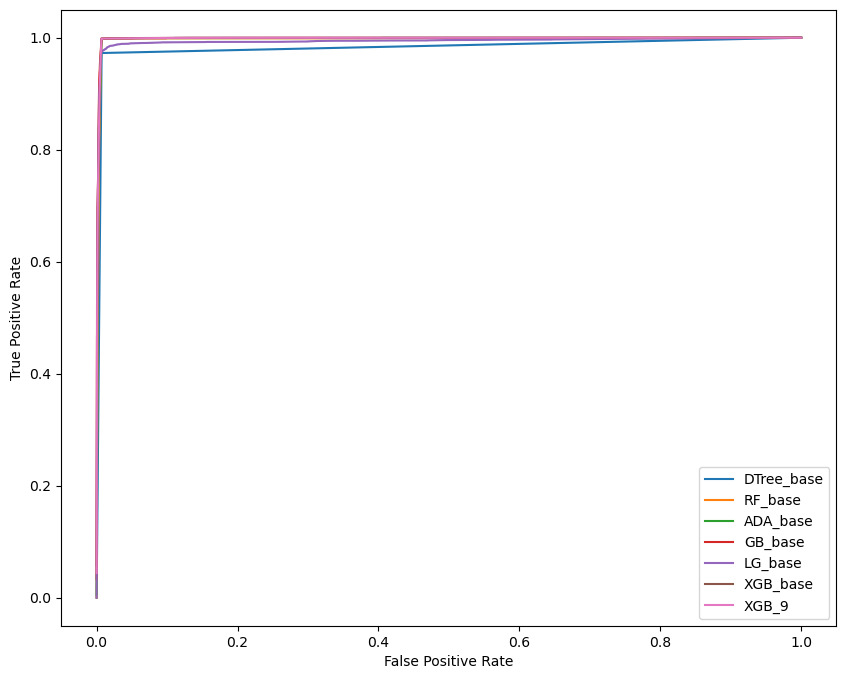

In [21]:
plt.figure(figsize=(8,6))
for model, model_name in models_list:
    yhat_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test, yhat_proba)
    sns.lineplot(x=fpr,y=tpr, label=model_name)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()   

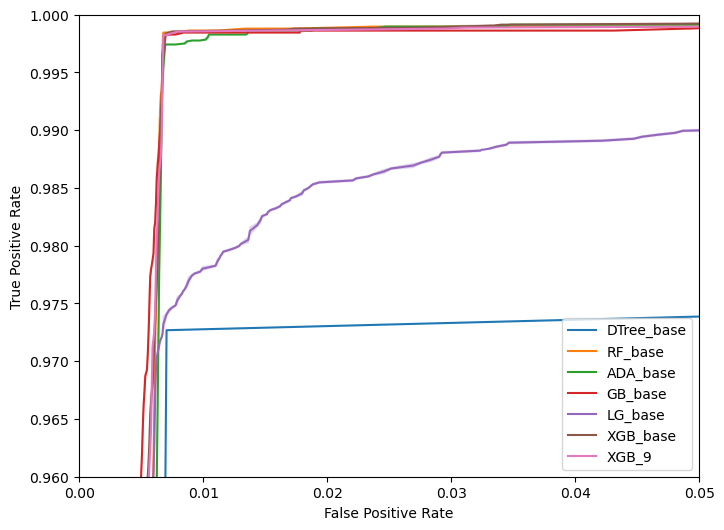

In [25]:
plt.figure(figsize=(8,6))
for model, model_name in models_list:
    yhat_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test, yhat_proba)
    sns.lineplot(x=fpr,y=tpr, label=model_name)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.ylim((0.96,1)),plt.xlim((0.0,0.05))
plt.show()   

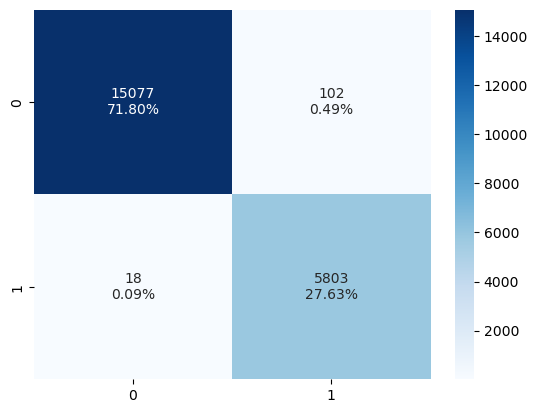

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     15179
           1       0.98      1.00      0.99      5821

    accuracy                           0.99     21000
   macro avg       0.99      1.00      0.99     21000
weighted avg       0.99      0.99      0.99     21000



In [28]:
yhat_test = XGB_9.predict(X_test)
make_CF(y_test, yhat_test)

In [35]:
# make_submission(models_list[-1:], 'Test1.Vanilla', retrain=True, early_stopping=None)

## 2. Work with categorical odds

### 2.1 Add All odds
GB 0.9945778

Model: RF_base
Training:  RF_base / Test2.1 Add_All_Odd
Finished in 66.83
Model: ADA_base
Training:  ADA_base / Test2.1 Add_All_Odd
Finished in 44.63
Model: GB_base
Training:  GB_base / Test2.1 Add_All_Odd
Finished in 158.64
Model: XGB_base
Training:  XGB_base / Test2.1 Add_All_Odd
[18:54:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recip

TypeError: barplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 1 keyword-only argument) were given

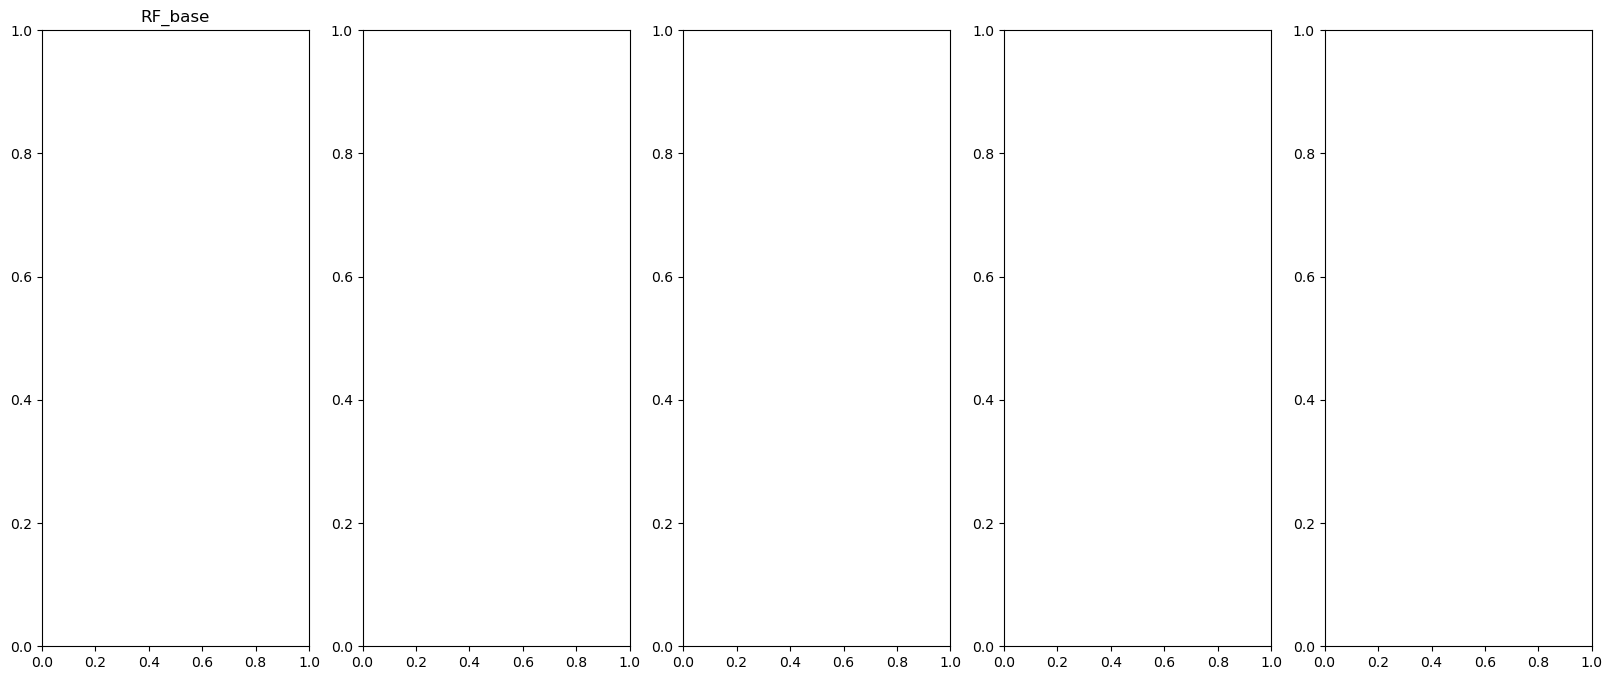

In [29]:
data_name = 'Test2.1 Add_All_Odd'

X_train, X_test, y_train, y_test, df_submit = data_transform_pipeline(
    sample_test = -1,
    # replace categorical with odd
    Low_Documentation_Loan_Odd  = True, 
    Low_Documentation_Loan_drop = False,
    Revolving_Credit_Line_Odd   = True,
    Revolving_Credit_Line_drop  = False,
    Business_Odd          = True,
    Business_drop         = False,
    Demography_Odd        = True,
    Demography_drop       = False,
    Classification_Code_Odd  = True,
    Classification_Code_drop = False,
    Code_Franchise_Odd       = True,
    Code_Franchise_drop      = False,
    Name_Of_Bank_Odd   = True,
    Borrower_State_Odd = True,
    
    # replace loan amount with pct/diff
    Loan1_Loan3_pct  = False,
    Loan1_Loan3_diff = False,
    Loan2_Loan3_pct  = False,
    Loan2_Loan3_diff = False,
    Loan1_drop = False,
    Loan2_drop = False,
    Loan3_drop = False,
    
    # add engineered features
    add_multiply = False,
    add_sum      = False,
    add_subtract = False,
    add_divide   = False,
    
    # processing
    drop_cols     = [],
    drop_first    = False,
    std_scale     = False,
    to_array      = False,
    test_size     = 0.2)


models_list = [
    (RF_base,'RF_base'),
    (ADA_base,'ADA_base'),
    (GB_base,'GB_base'),
    (XGB_base,'XGB_base'),
    (XGB_9,'XGB_9')
]

for model, model_name in models_list:
    print('Model:',model_name)
    model_performance(model, model_name, data_name, X_train, X_test, y_train, y_test, cv=5)
    
feature_imp(models_list)

In [36]:
df_metrics

model                   data    time  train_acc  \
0   DTree_base             1. Vanilla    4.58   100.0000   
1      RF_base             1. Vanilla   58.75    99.9988   
2     ADA_base             1. Vanilla   39.14    99.4060   
3      GB_base             1. Vanilla   129.7    99.4786   
4      LG_base             1. Vanilla     4.0    98.3571   
5     XGB_base             1. Vanilla   24.15    99.6167   
6        XGB_9             1. Vanilla   76.48    99.8607   
7      RF_base    Test2.1 Add_All_Odd   66.83    99.9988   
8     ADA_base    Test2.1 Add_All_Odd   44.63    99.4060   
9      GB_base    Test2.1 Add_All_Odd  158.64    99.4798   
10    XGB_base    Test2.1 Add_All_Odd   28.97    99.6738   
11       XGB_9    Test2.1 Add_All_Odd   83.31    99.9274   
12    XGB_base  Test2.4_Name_Bank_odd    24.2    99.6452   
13       XGB_9  Test2.4_Name_Bank_odd   74.18    99.8679   

                                   train_PRF1       test_acc  \
0         1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        98.7333   
1         1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4190   
2      0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0        99.3857   
3      0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0        99.4333   
4   0.99 - 0.96 - 0.97  |  0.98 - 0.99 - 0.99        98.2524   
5       0.99 - 1.0 - 0.99  |  1.0 - 1.0 - 1.0        99.4429   
6         1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4286   
7         1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4095   
8      0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0        99.3857   
9      0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0        99.4476   
10      0.99 - 1.0 - 0.99  |  1.0 - 1.0 - 1.0        99.4238   
11        1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4381   
12      0.99 - 1.0 - 0.99  |  1.0 - 1.0 - 1.0        99.4143   
13        1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4333   

                                    test_PRF1        cv_acc         cv_range  \
0   0.98 - 0.97 - 0.98  |  0.99 - 0.99 - 0.99       98.8362  0.9897 - 0.9873   
1      0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4267  0.9952 - 0.9937   
2      0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4010   0.995 - 0.9933   
3      0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4276  0.9951 - 0.9936   
4   0.98 - 0.95 - 0.97  |  0.98 - 0.99 - 0.99       98.6676  0.9895 - 0.9825   
5      0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4343  0.9952 - 0.9938   
6      0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4400  0.9953 - 0.9938   
7      0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4267  0.9952 - 0.9936   
8      0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4010   0.995 - 0.9933   
9      0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4314  0.9951 - 0.9935   
10     0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4371  0.9954 - 0.9938   
11     0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4400  0.9955 - 0.9937   
12     0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4352  0.9954 - 0.9938   
13     0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4438  0.9955 - 0.9937   

       pred_ratio  
0   72.42 / 27.58  
1   71.89 / 28.11  
2   71.92 / 28.08  
3   71.88 / 28.12  
4   72.76 / 27.24  
5   71.87 / 28.13  
6   71.87 / 28.13  
7   71.89 / 28.11  
8   71.92 / 28.08  
9   71.88 / 28.12  
10  71.88 / 28.12  
11  71.87 / 28.13  
12  71.88 / 28.12  
13  71.87 / 28.13

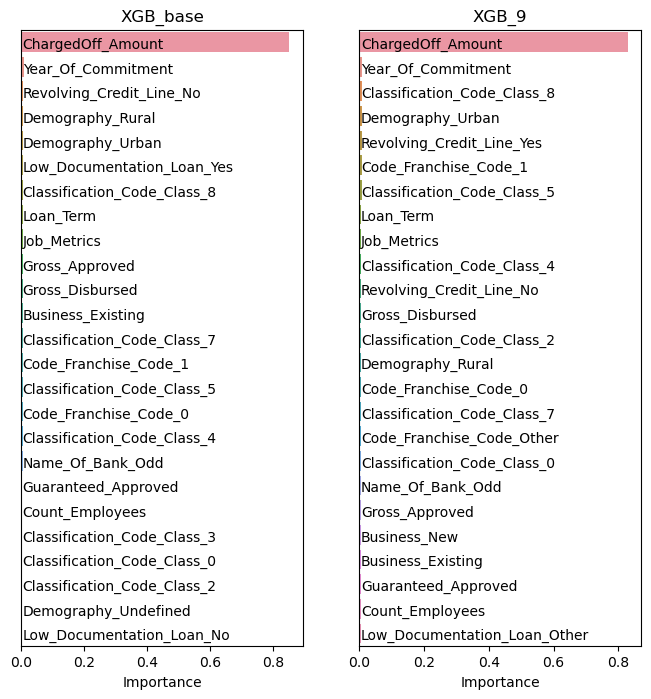

In [37]:
feature_imp(models_list)

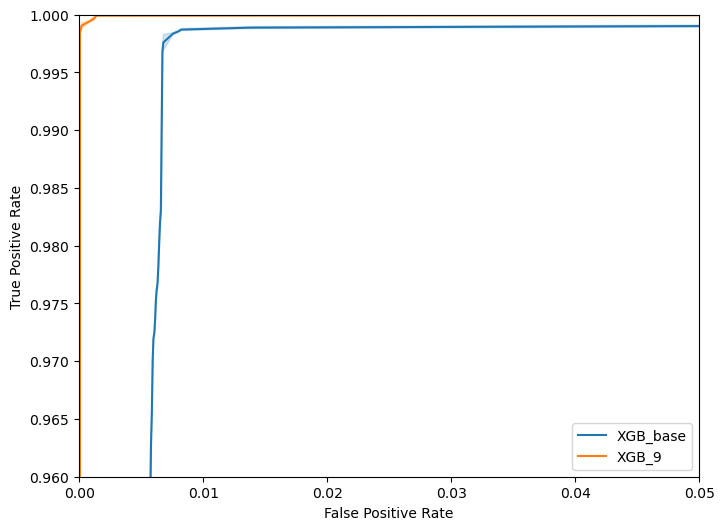

In [38]:
plt.figure(figsize=(8,6))
for model, model_name in models_list:
    yhat_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test, yhat_proba)
    sns.lineplot(x=fpr,y=tpr, label=model_name)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.ylim((0.96,1)),plt.xlim((0.0,0.05))
plt.show()   

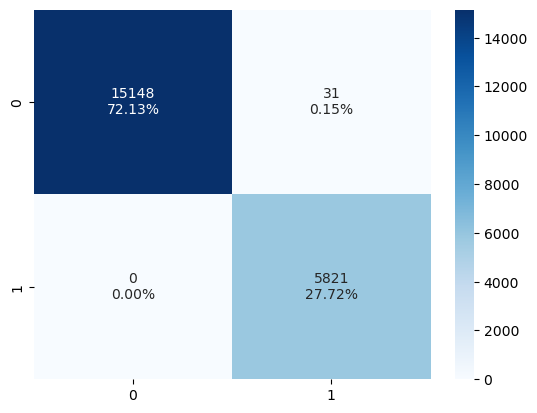

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15179
           1       0.99      1.00      1.00      5821

    accuracy                           1.00     21000
   macro avg       1.00      1.00      1.00     21000
weighted avg       1.00      1.00      1.00     21000



In [39]:
yhat_test = XGB_9.predict(X_test)
make_CF(y_test, yhat_test)

In [40]:
make_submission([(XGB_9,'XGB_9')], data_name, retrain=True)

[0]	validation_0-aucpr:0.99713
[1]	validation_0-aucpr:0.99725
[2]	validation_0-aucpr:0.99736
[3]	validation_0-aucpr:0.99737
[4]	validation_0-aucpr:0.99743
[5]	validation_0-aucpr:0.99748
[6]	validation_0-aucpr:0.99750
[7]	validation_0-aucpr:0.99754
[8]	validation_0-aucpr:0.99758
[9]	validation_0-aucpr:0.99765
[10]	validation_0-aucpr:0.99768
[11]	validation_0-aucpr:0.99771
[12]	validation_0-aucpr:0.99772
[13]	validation_0-aucpr:0.99805
[14]	validation_0-aucpr:0.99826
[15]	validation_0-aucpr:0.99832
[16]	validation_0-aucpr:0.99838
[17]	validation_0-aucpr:0.99844
[18]	validation_0-aucpr:0.99845
[19]	validation_0-aucpr:0.99854
[20]	validation_0-aucpr:0.99854
[21]	validation_0-aucpr:0.99854
[22]	validation_0-aucpr:0.99859
[23]	validation_0-aucpr:0.99862
[24]	validation_0-aucpr:0.99864
[25]	validation_0-aucpr:0.99863
[26]	validation_0-aucpr:0.99866
[27]	validation_0-aucpr:0.99874
[28]	validation_0-aucpr:0.99880
[29]	validation_0-aucpr:0.99878
[30]	validation_0-aucpr:0.99881
[31]	validation_0-

OSError: Cannot save file into a non-existent directory: 'SUBMISSIONS'

### 2.2 Loop odd
41min 18s

Low_Doc
Model: RF_base
Training:  RF_base / Test2.2_Low_Doc
Finished in 55.57
Model: ADA_base
Training:  ADA_base / Test2.2_Low_Doc
Finished in 36.6
Model: GB_base
Training:  GB_base / Test2.2_Low_Doc
Finished in 123.77
Model: XGB_base
Training:  XGB_base / Test2.2_Low_Doc
[23:41:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:41:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:41:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost

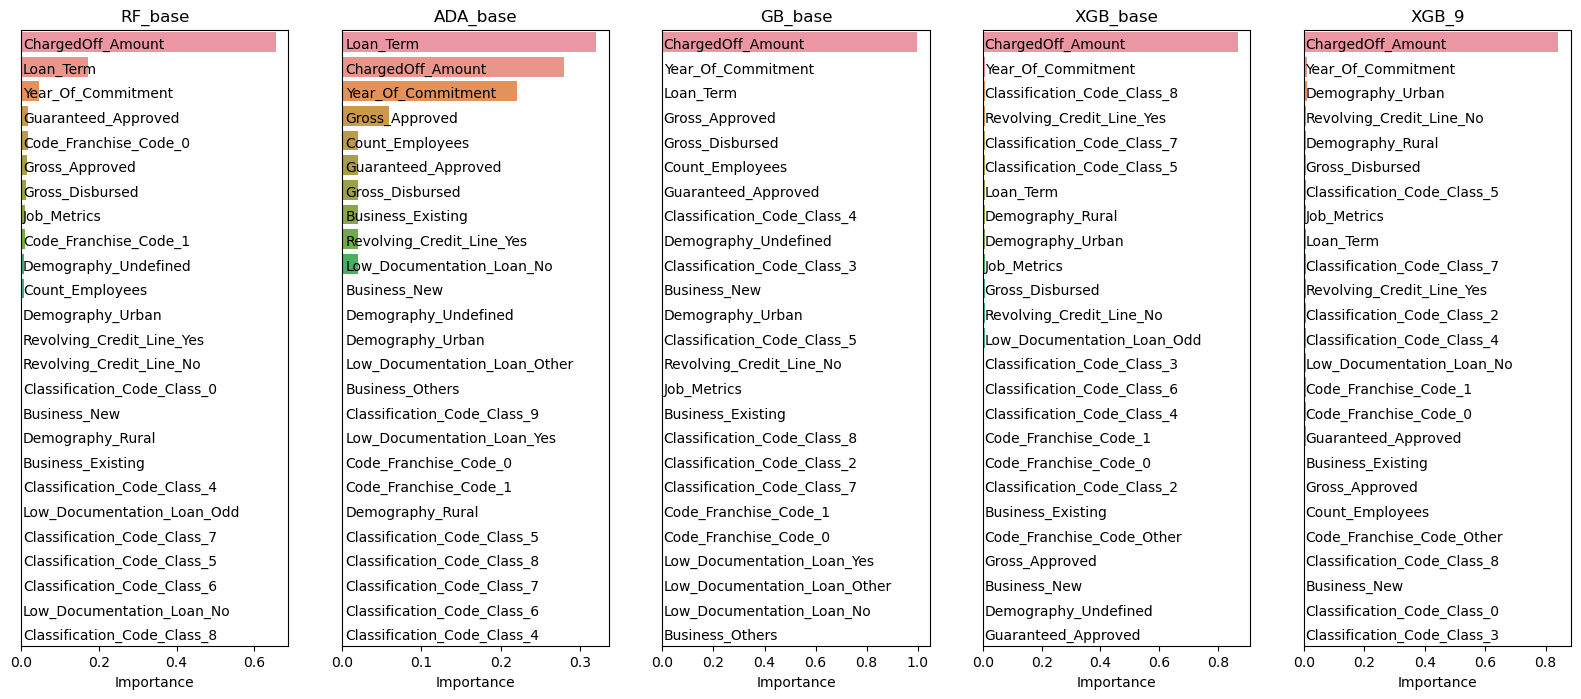

Rev_Cre
Model: RF_base
Training:  RF_base / Test2.2_Rev_Cre
Finished in 55.13
Model: ADA_base
Training:  ADA_base / Test2.2_Rev_Cre
Finished in 36.61
Model: GB_base
Training:  GB_base / Test2.2_Rev_Cre
Finished in 125.15
Model: XGB_base
Training:  XGB_base / Test2.2_Rev_Cre
[23:46:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:46:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:46:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboos

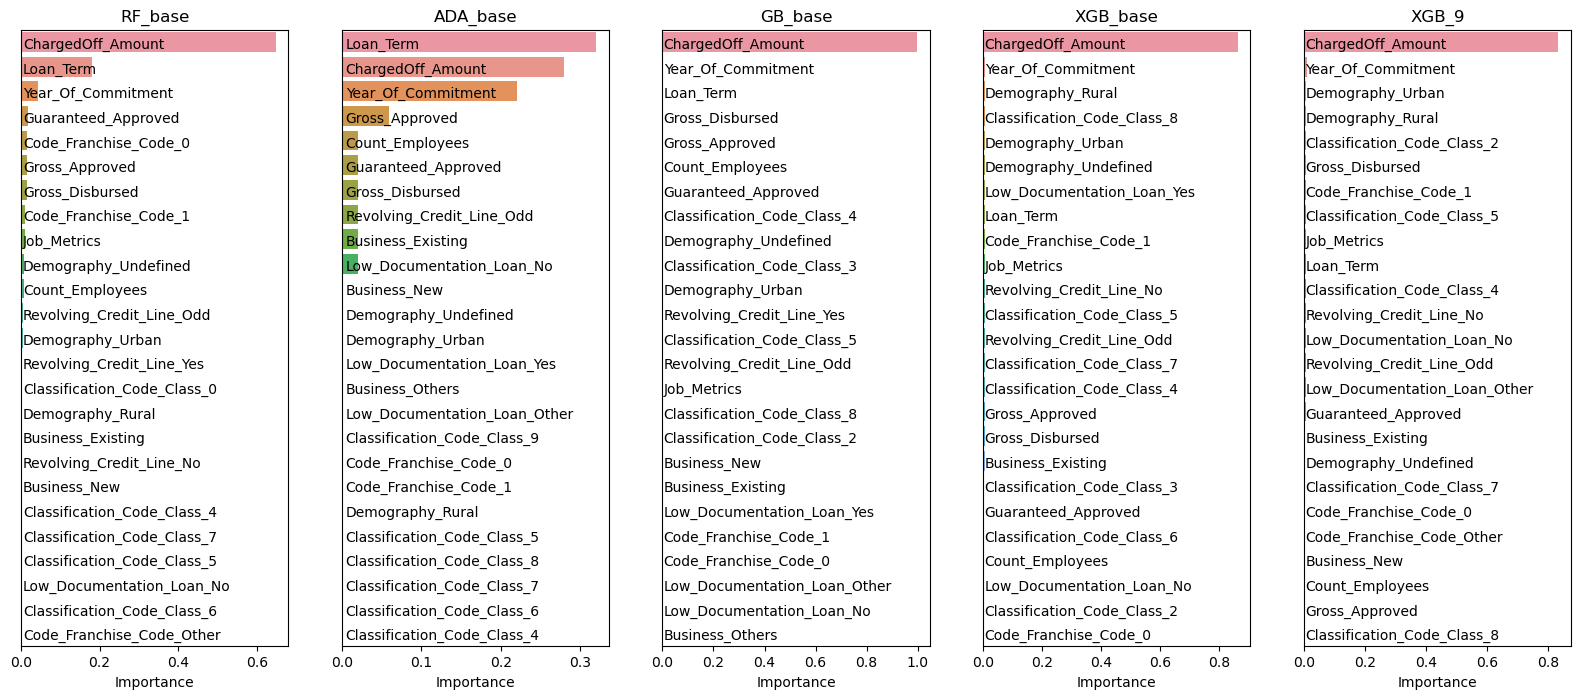

Busi
Model: RF_base
Training:  RF_base / Test2.2_Busi
Finished in 55.17
Model: ADA_base
Training:  ADA_base / Test2.2_Busi
Finished in 36.56
Model: GB_base
Training:  GB_base / Test2.2_Busi
Finished in 124.25
Model: XGB_base
Training:  XGB_base / Test2.2_Busi
[23:51:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:51:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:51:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548

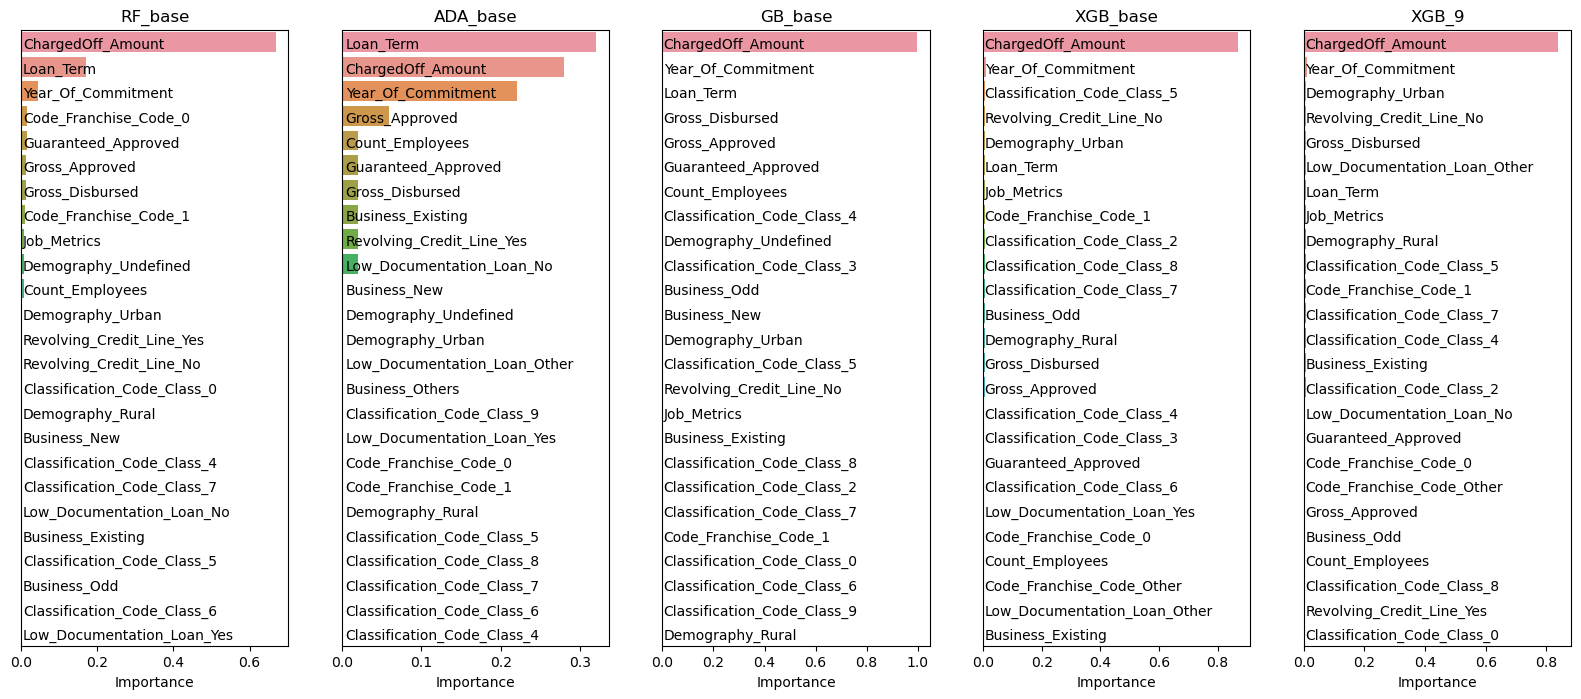

Demo
Model: RF_base
Training:  RF_base / Test2.2_Demo
Finished in 55.06
Model: ADA_base
Training:  ADA_base / Test2.2_Demo
Finished in 36.54
Model: GB_base
Training:  GB_base / Test2.2_Demo
Finished in 124.98
Model: XGB_base
Training:  XGB_base / Test2.2_Demo
[23:56:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:56:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:57:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548

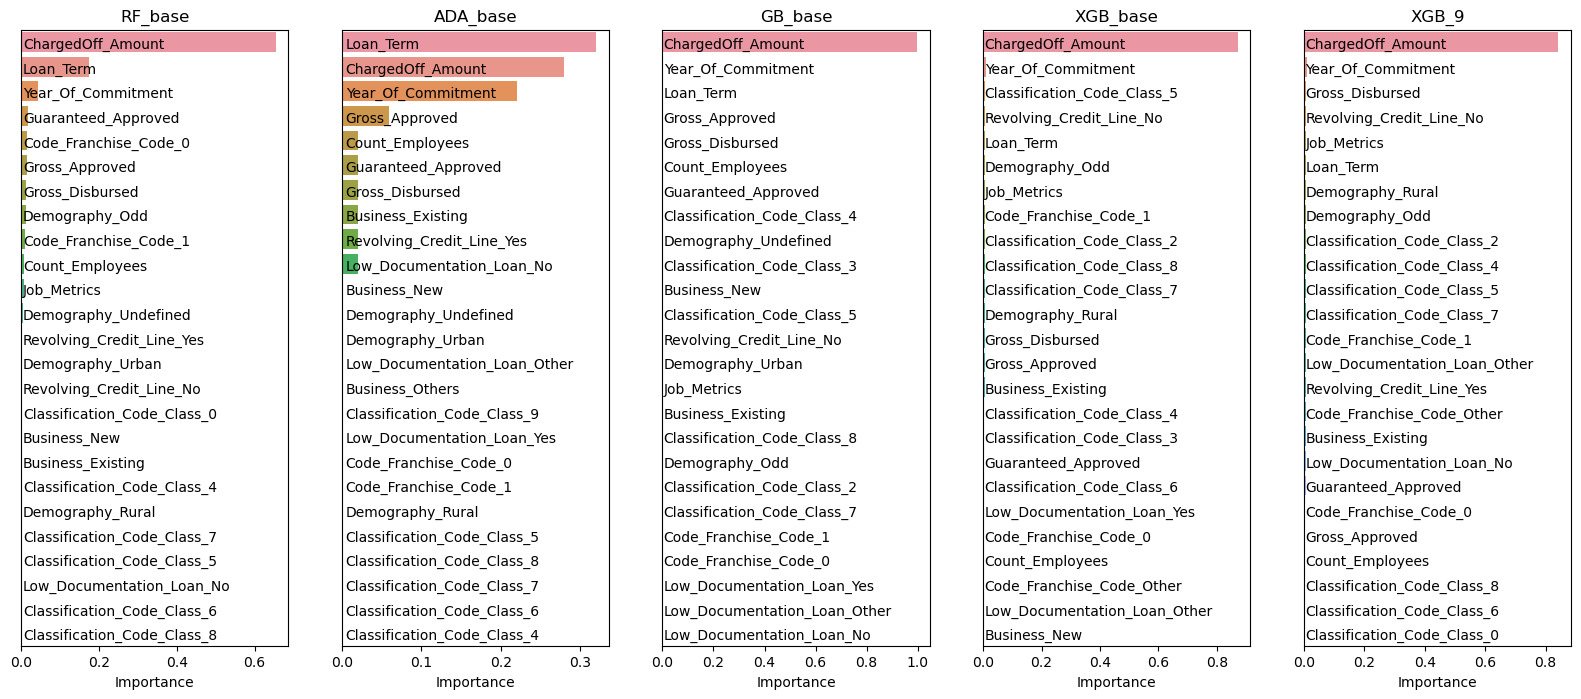

Class_Code
Model: RF_base
Training:  RF_base / Test2.2_Class_Code
Finished in 55.65
Model: ADA_base
Training:  ADA_base / Test2.2_Class_Code
Finished in 36.84
Model: GB_base
Training:  GB_base / Test2.2_Class_Code
Finished in 126.58
Model: XGB_base
Training:  XGB_base / Test2.2_Class_Code
[00:02:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:02:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:02:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croot

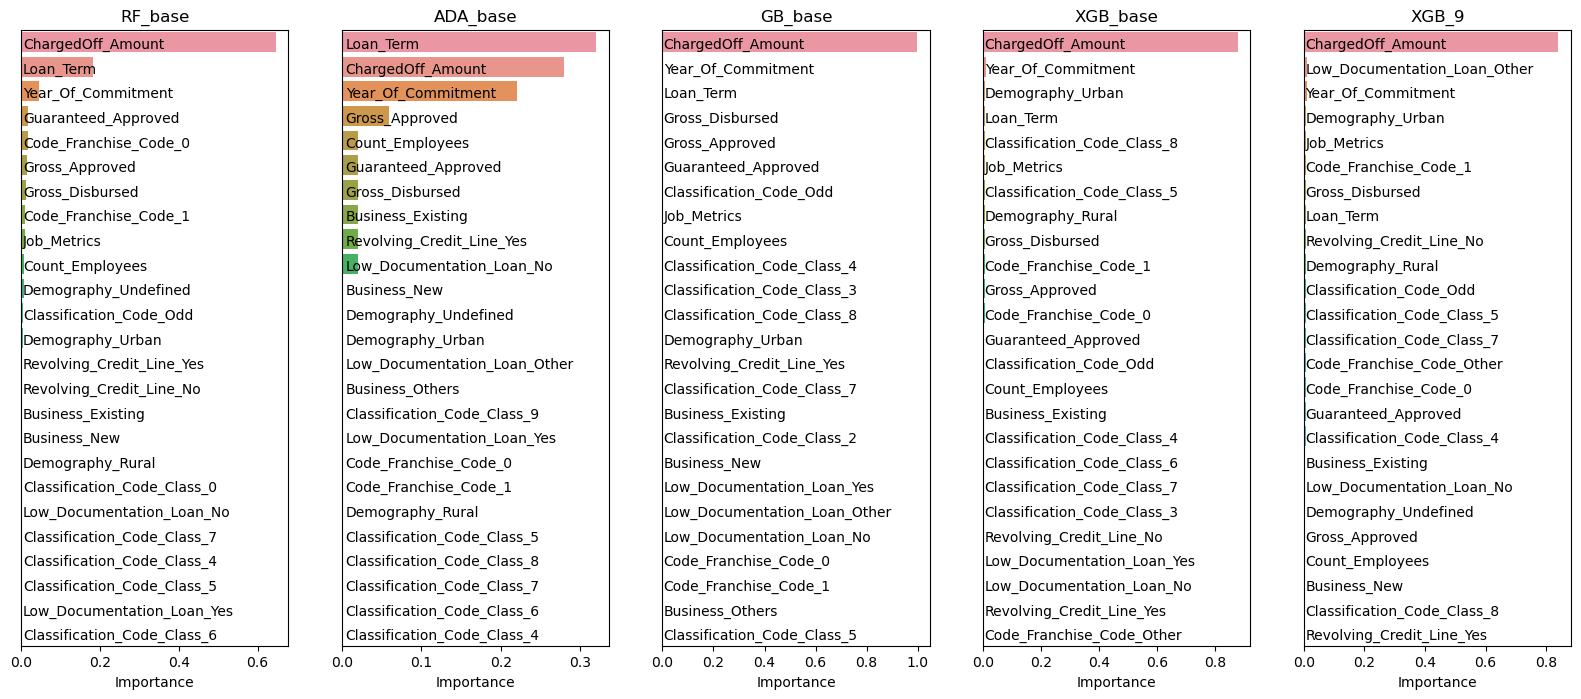

Code_Fran
Model: RF_base
Training:  RF_base / Test2.2_Code_Fran
Finished in 55.05
Model: ADA_base
Training:  ADA_base / Test2.2_Code_Fran
Finished in 36.6
Model: GB_base
Training:  GB_base / Test2.2_Code_Fran
Finished in 124.17
Model: XGB_base
Training:  XGB_base / Test2.2_Code_Fran
[00:07:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:07:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:07:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\reci

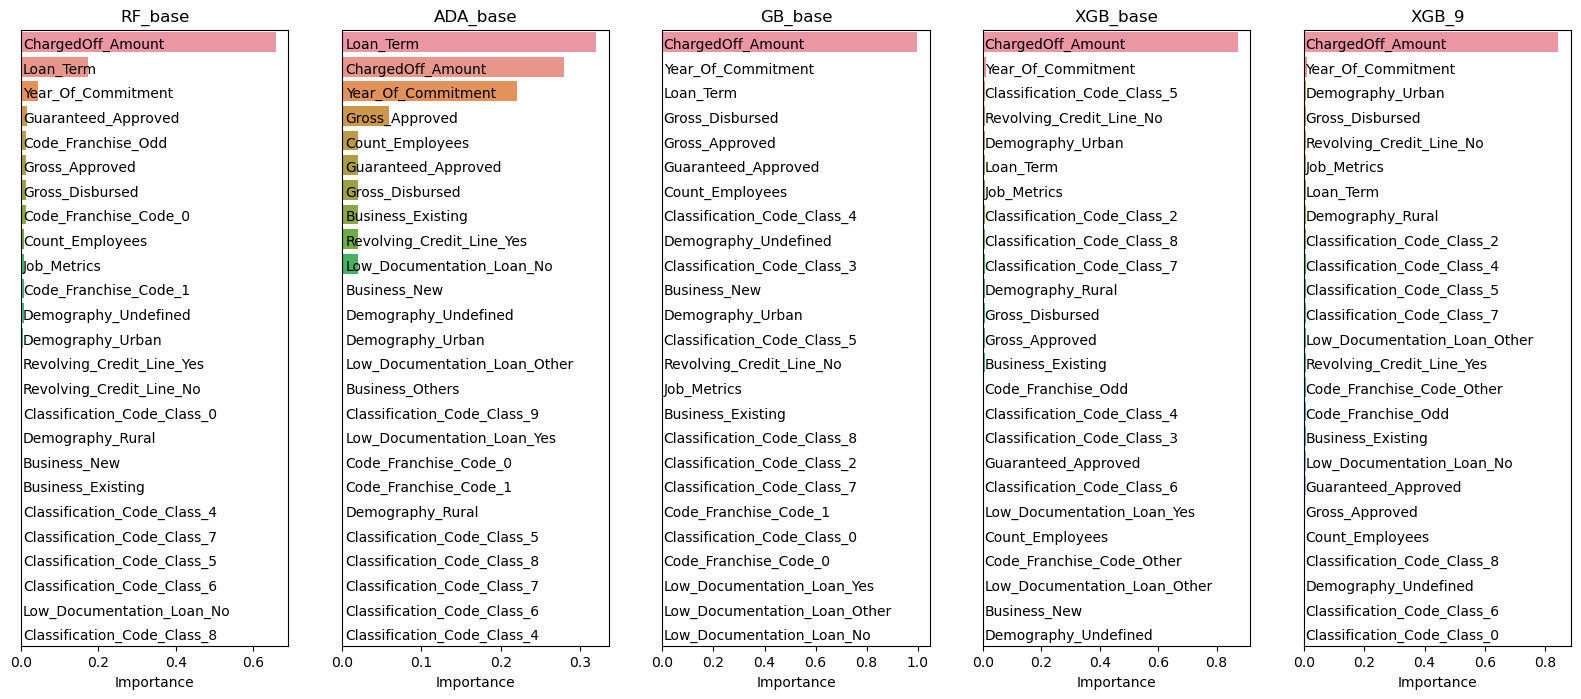

Name_Bank
Model: RF_base
Training:  RF_base / Test2.2_Name_Bank
Finished in 57.72
Model: ADA_base
Training:  ADA_base / Test2.2_Name_Bank
Finished in 37.41
Model: GB_base
Training:  GB_base / Test2.2_Name_Bank
Finished in 130.23
Model: XGB_base
Training:  XGB_base / Test2.2_Name_Bank
[00:12:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:12:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:12:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\rec

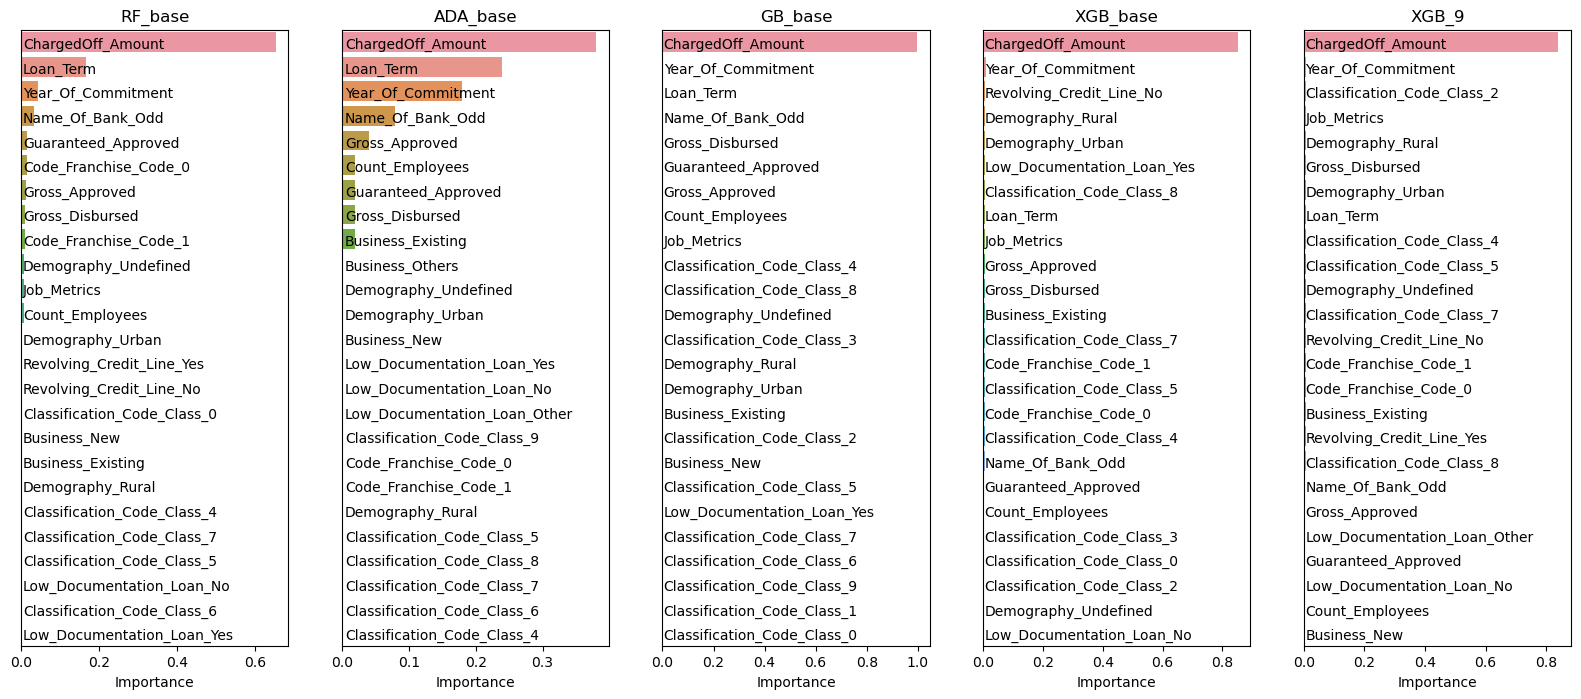

Borrower
Model: RF_base
Training:  RF_base / Test2.2_Borrower
Finished in 57.0
Model: ADA_base
Training:  ADA_base / Test2.2_Borrower
Finished in 37.28
Model: GB_base
Training:  GB_base / Test2.2_Borrower
Finished in 128.21
Model: XGB_base
Training:  XGB_base / Test2.2_Borrower
[00:17:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:17:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:17:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xg

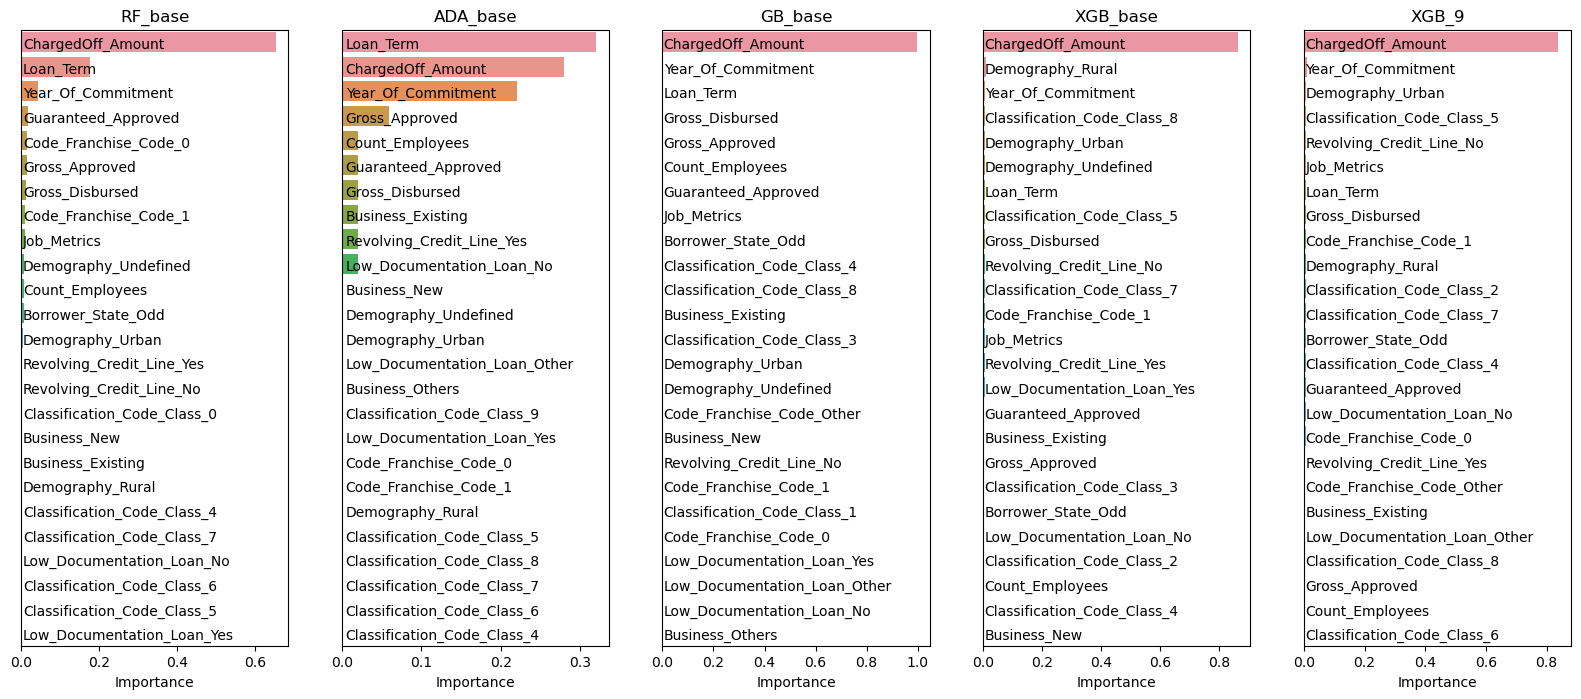

CPU times: total: 2h 45min 3s
Wall time: 41min 18s


In [124]:
%%time
data_name = 'Test2.2_'

loop_odds = [
    ('Low_Doc'   ,True ,False,False,False,False,False,False,False),
    ('Rev_Cre'   ,False,True ,False,False,False,False,False,False),
    ('Busi'      ,False,False,True ,False,False,False,False,False),
    ('Demo'      ,False,False,False,True ,False,False,False,False),
    ('Class_Code',False,False,False,False,True ,False,False,False),
    ('Code_Fran' ,False,False,False,False,False,True ,False,False),
    ('Name_Bank' ,False,False,False,False,False,False,True ,False),
    ('Borrower'  ,False,False,False,False,False,False,False,True )
    ]

for odd_added, Low_Doc,Rev_Cre,Busi,Demo,Class_Code,Code_Fran,Name_Bank,Borrower in loop_odds:
    print(odd_added)
    X_train, X_test, y_train, y_test, df_submit = data_transform_pipeline(
        sample_test = -1,
        # replace categorical with odd
        Low_Documentation_Loan_Odd  = Low_Doc, 
        Low_Documentation_Loan_drop = False,
        Revolving_Credit_Line_Odd   = Rev_Cre,
        Revolving_Credit_Line_drop  = False,
        Business_Odd          = Busi,
        Business_drop         = False,
        Demography_Odd        = Demo,
        Demography_drop       = False,
        Classification_Code_Odd  = Class_Code,
        Classification_Code_drop = False,
        Code_Franchise_Odd       = Code_Fran,
        Code_Franchise_drop      = False,
        Name_Of_Bank_Odd   = Name_Bank,
        Borrower_State_Odd = Borrower,

        # replace loan amount with pct/diff
        Loan1_Loan3_pct  = False,
        Loan1_Loan3_diff = False,
        Loan2_Loan3_pct  = False,
        Loan2_Loan3_diff = False,
        Loan1_drop = False,
        Loan2_drop = False,
        Loan3_drop = False,

        # add engineered features
        add_multiply = False,
        add_sum      = False,
        add_subtract = False,
        add_divide   = False,

        # processing
        drop_cols     = [],
        drop_first    = False,
        std_scale     = False,
        to_array      = False,
        test_size     = 0.2)


    models_list = [
        (RF_base,'RF_base'),
        (ADA_base,'ADA_base'),
        (GB_base,'GB_base'),
        (XGB_base,'XGB_base'),
        (XGB_9,'XGB_9')
    ]

    for model, model_name in models_list:
        print('Model:',model_name)
        model_performance(model, model_name, data_name+odd_added, X_train, X_test, y_train, y_test, cv=5)

    feature_imp(models_list)

In [125]:
# reset(df_metrics)
df_metrics

model                 data    time  train_acc  \
0   DTree_base           1. Vanilla    4.41   100.0000   
1      RF_base           1. Vanilla   56.08    99.9988   
2     ADA_base           1. Vanilla   36.45    99.4060   
3      GB_base           1. Vanilla  123.75    99.4786   
4      LG_base           1. Vanilla    3.68    98.3571   
5     XGB_base           1. Vanilla   21.75    99.6167   
6        XGB_9           1. Vanilla   66.39    99.8821   
7      RF_base  Test2.1 Add_All_Odd   64.04    99.9988   
8     ADA_base  Test2.1 Add_All_Odd   43.09    99.4060   
9      GB_base  Test2.1 Add_All_Odd  154.04    99.4798   
10    XGB_base  Test2.1 Add_All_Odd   25.09    99.6738   
11       XGB_9  Test2.1 Add_All_Odd    75.7    99.9274   
12     RF_base      Test2.2_Low_Doc   55.57    99.9988   
13    ADA_base      Test2.2_Low_Doc    36.6    99.4060   
14     GB_base      Test2.2_Low_Doc  123.77    99.4786   
15    XGB_base      Test2.2_Low_Doc   22.27    99.6167   
16       XGB_9      Test2.2_Low_Doc   67.29    99.8702   
17     RF_base      Test2.2_Rev_Cre   55.13    99.9988   
18    ADA_base      Test2.2_Rev_Cre   36.61    99.4060   
19     GB_base      Test2.2_Rev_Cre  125.15    99.4714   
20    XGB_base      Test2.2_Rev_Cre   21.91    99.6048   
21       XGB_9      Test2.2_Rev_Cre   66.83    99.8560   
22     RF_base         Test2.2_Busi   55.17    99.9988   
23    ADA_base         Test2.2_Busi   36.56    99.4060   
24     GB_base         Test2.2_Busi  124.25    99.4786   
25    XGB_base         Test2.2_Busi    22.0    99.6167   
26       XGB_9         Test2.2_Busi   66.97    99.8702   
27     RF_base         Test2.2_Demo   55.06    99.9988   
28    ADA_base         Test2.2_Demo   36.54    99.4060   
29     GB_base         Test2.2_Demo  124.98    99.4786   
30    XGB_base         Test2.2_Demo   22.38    99.6167   
31       XGB_9         Test2.2_Demo   66.69    99.8821   
32     RF_base   Test2.2_Class_Code   55.65    99.9988   
33    ADA_base   Test2.2_Class_Code   36.84    99.4060   
34     GB_base   Test2.2_Class_Code  126.58    99.4726   
35    XGB_base   Test2.2_Class_Code   22.16    99.6226   
36       XGB_9   Test2.2_Class_Code    67.2    99.9131   
37     RF_base    Test2.2_Code_Fran   55.05    99.9988   
38    ADA_base    Test2.2_Code_Fran    36.6    99.4060   
39     GB_base    Test2.2_Code_Fran  124.17    99.4786   
40    XGB_base    Test2.2_Code_Fran   22.22    99.6167   
41       XGB_9    Test2.2_Code_Fran   66.77    99.8821   
42     RF_base    Test2.2_Name_Bank   57.72    99.9988   
43    ADA_base    Test2.2_Name_Bank   37.41    99.4060   
44     GB_base    Test2.2_Name_Bank  130.23    99.4726   
45    XGB_base    Test2.2_Name_Bank   22.46    99.6452   
46       XGB_9    Test2.2_Name_Bank   68.34    99.8762   
47     RF_base     Test2.2_Borrower    57.0    99.9988   
48    ADA_base     Test2.2_Borrower   37.28    99.4060   
49     GB_base     Test2.2_Borrower  128.21    99.4750   
50    XGB_base     Test2.2_Borrower   22.19    99.6464   
51       XGB_9     Test2.2_Borrower   68.27    99.8988   

                                   train_PRF1       test_acc  \
0         1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        98.7143   
1         1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4286   
2      0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0        99.3857   
3      0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0        99.4381   
4   0.99 - 0.96 - 0.97  |  0.98 - 0.99 - 0.99        98.2524   
5       0.99 - 1.0 - 0.99  |  1.0 - 1.0 - 1.0        99.4429   
6         1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4333   
7         1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4048   
8      0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0        99.3857   
9      0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0        99.4476   
10      0.99 - 1.0 - 0.99  |  1.0 - 1.0 - 1.0        99.4238   
11        1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4381   
12        1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4238   
13     0.98 - 1.0 - 0.99  |  1.0 - 0.9

### 2.3 Loop odd + drop
 39min 33s

Low_Doc
Model: RF_base
Training:  RF_base / Test2.3_Low_Doc_drop
Finished in 54.29
Model: ADA_base
Training:  ADA_base / Test2.3_Low_Doc_drop
Finished in 34.98
Model: GB_base
Training:  GB_base / Test2.3_Low_Doc_drop
Finished in 119.26
Model: XGB_base
Training:  XGB_base / Test2.3_Low_Doc_drop
[00:22:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:49] WARNING: C:\Windows\Temp\abs_557yfx631l\

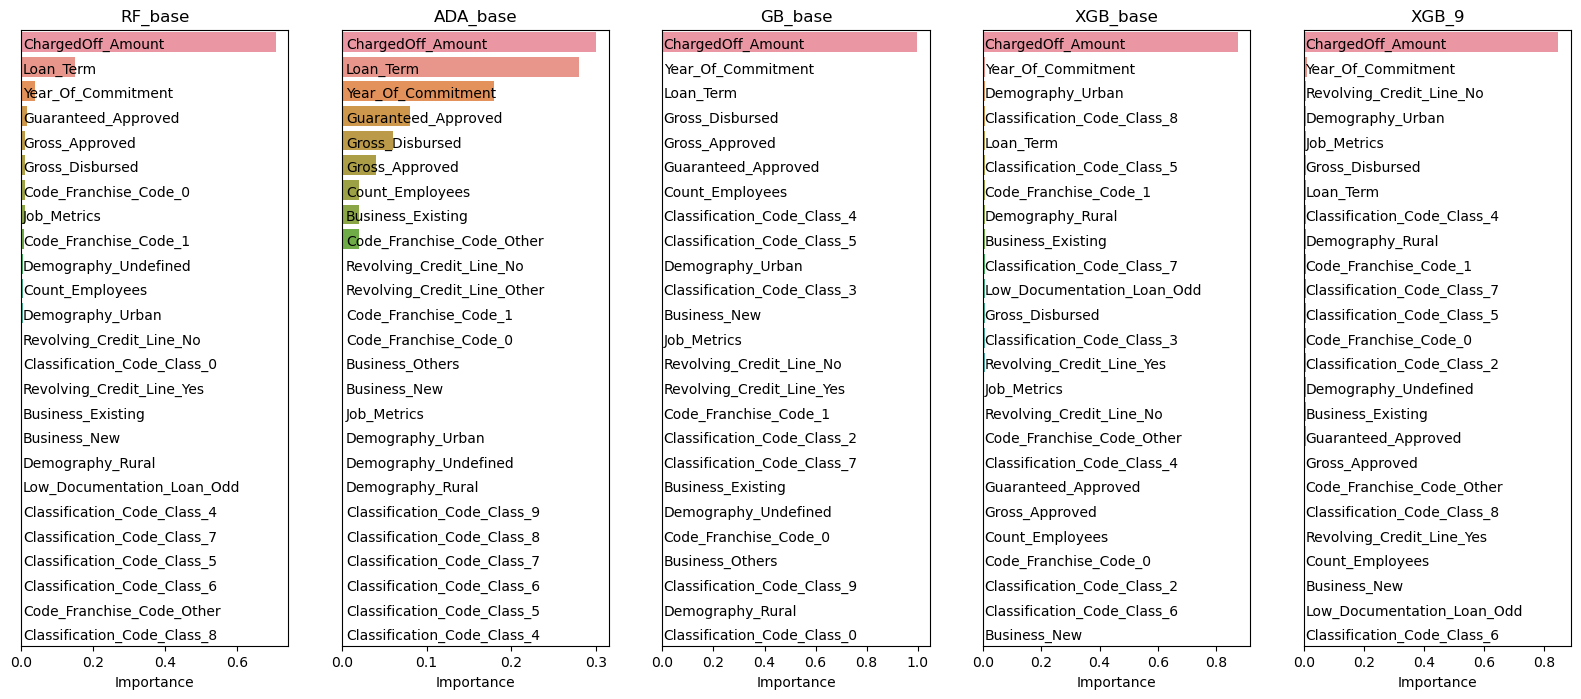

Rev_Cre
Model: RF_base
Training:  RF_base / Test2.3_Rev_Cre_drop
Finished in 53.82
Model: ADA_base
Training:  ADA_base / Test2.3_Rev_Cre_drop
Finished in 35.53
Model: GB_base
Training:  GB_base / Test2.3_Rev_Cre_drop
Finished in 119.6
Model: XGB_base
Training:  XGB_base / Test2.3_Rev_Cre_drop
[00:27:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:27:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:27:44] WARNING: C:\Windows\Temp\abs_557yfx631l\c

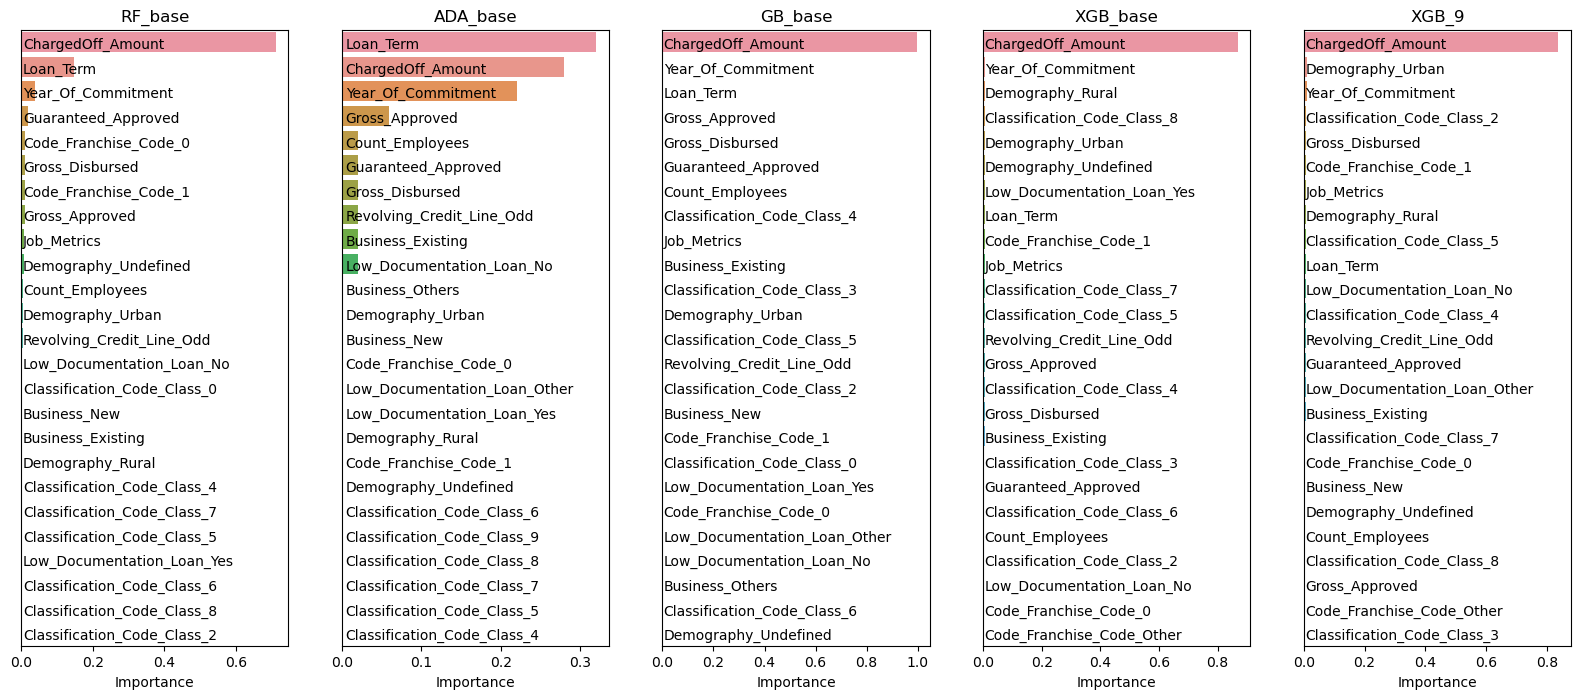

Busi
Model: RF_base
Training:  RF_base / Test2.3_Busi_drop
Finished in 53.73
Model: ADA_base
Training:  ADA_base / Test2.3_Busi_drop
Finished in 34.96
Model: GB_base
Training:  GB_base / Test2.3_Busi_drop
Finished in 118.57
Model: XGB_base
Training:  XGB_base / Test2.3_Busi_drop
[00:32:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:32:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:32:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\x

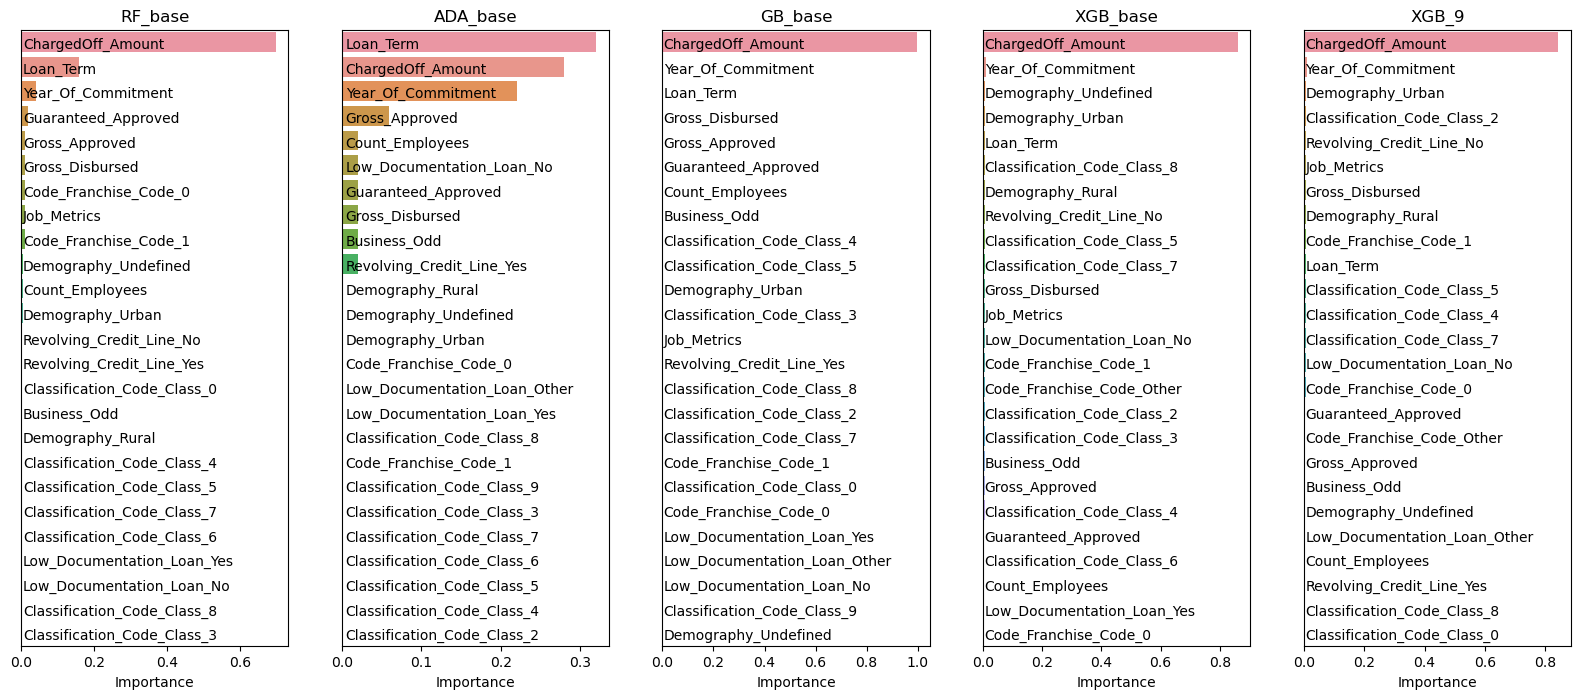

Demo
Model: RF_base
Training:  RF_base / Test2.3_Demo_drop
Finished in 53.56
Model: ADA_base
Training:  ADA_base / Test2.3_Demo_drop
Finished in 35.23
Model: GB_base
Training:  GB_base / Test2.3_Demo_drop
Finished in 118.76
Model: XGB_base
Training:  XGB_base / Test2.3_Demo_drop
[00:37:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:37:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:37:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\x

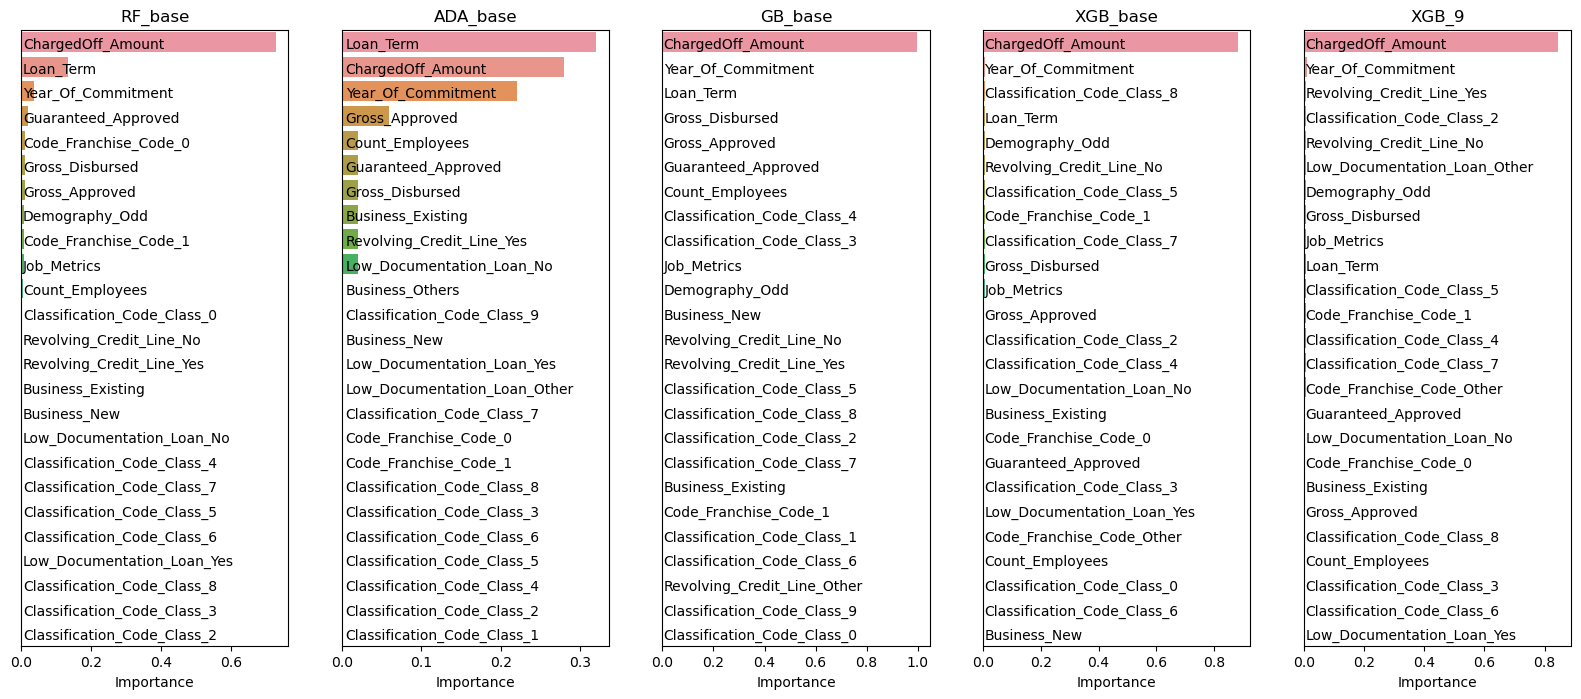

Class_Code
Model: RF_base
Training:  RF_base / Test2.3_Class_Code_drop
Finished in 50.18
Model: ADA_base
Training:  ADA_base / Test2.3_Class_Code_drop
Finished in 32.01
Model: GB_base
Training:  GB_base / Test2.3_Class_Code_drop
Finished in 110.86
Model: XGB_base
Training:  XGB_base / Test2.3_Class_Code_drop
[00:42:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:42:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:42:08] WARNING: C:\Windows\Temp\

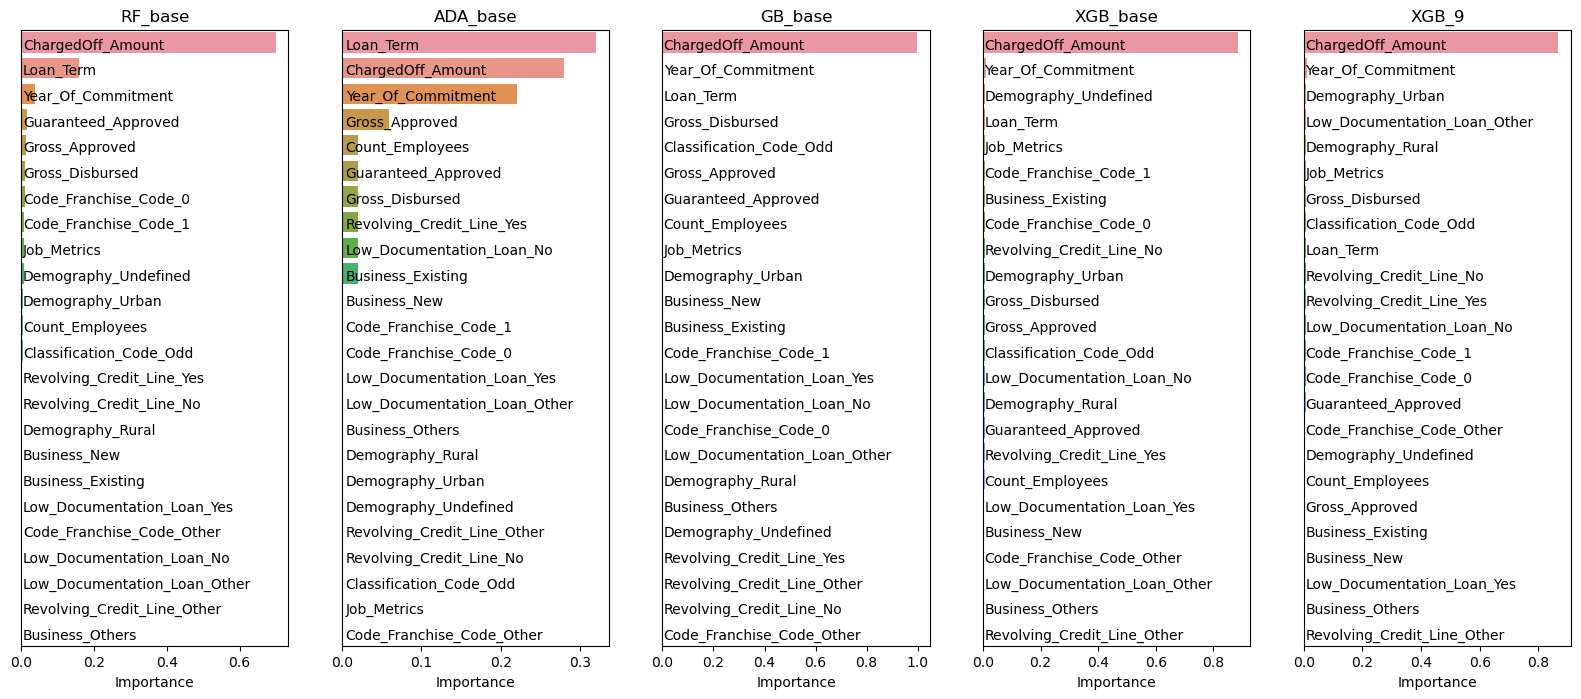

Code_Fran
Model: RF_base
Training:  RF_base / Test2.3_Code_Fran_drop
Finished in 54.02
Model: ADA_base
Training:  ADA_base / Test2.3_Code_Fran_drop
Finished in 34.89
Model: GB_base
Training:  GB_base / Test2.3_Code_Fran_drop
Finished in 118.83
Model: XGB_base
Training:  XGB_base / Test2.3_Code_Fran_drop
[00:46:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:46:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:46:55] WARNING: C:\Windows\Temp\abs_5

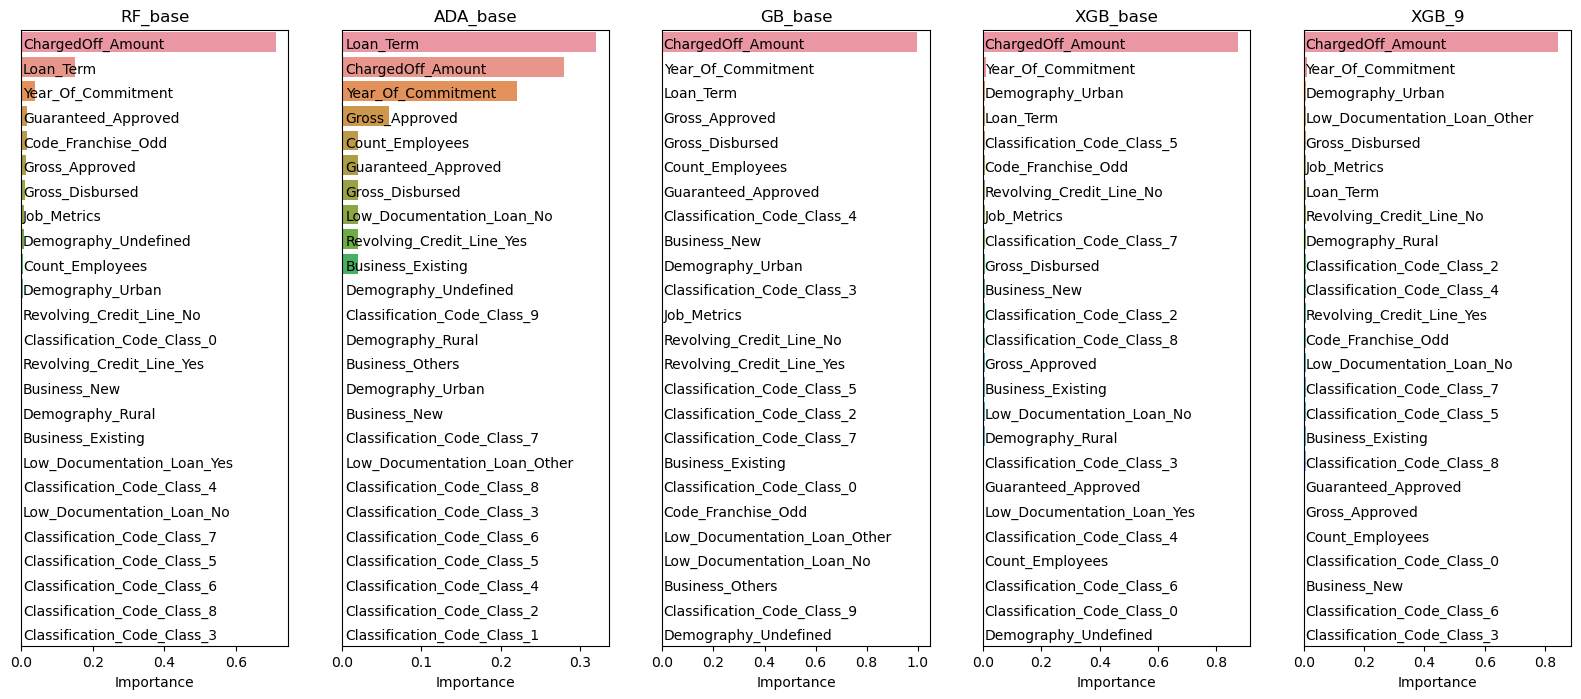

Name_Bank
Model: RF_base
Training:  RF_base / Test2.3_Name_Bank_drop
Finished in 57.73
Model: ADA_base
Training:  ADA_base / Test2.3_Name_Bank_drop
Finished in 37.77
Model: GB_base
Training:  GB_base / Test2.3_Name_Bank_drop
Finished in 130.86
Model: XGB_base
Training:  XGB_base / Test2.3_Name_Bank_drop
[00:52:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:52:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:52:07] WARNING: C:\Windows\Temp\abs_5

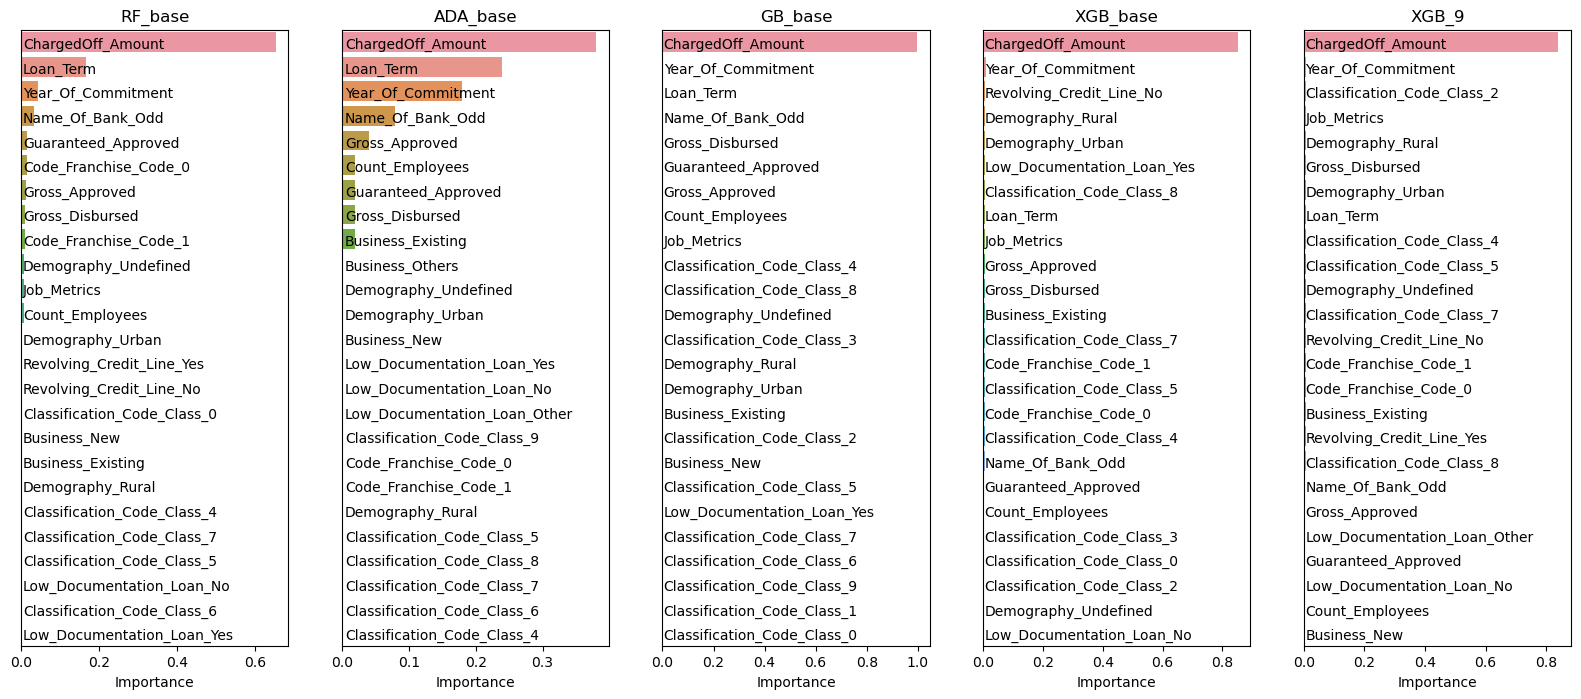

Borrower
Model: RF_base
Training:  RF_base / Test2.3_Borrower_drop
Finished in 57.13
Model: ADA_base
Training:  ADA_base / Test2.3_Borrower_drop
Finished in 37.21
Model: GB_base
Training:  GB_base / Test2.3_Borrower_drop
Finished in 128.19
Model: XGB_base
Training:  XGB_base / Test2.3_Borrower_drop
[00:57:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:57:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:57:23] WARNING: C:\Windows\Temp\abs_557yfx

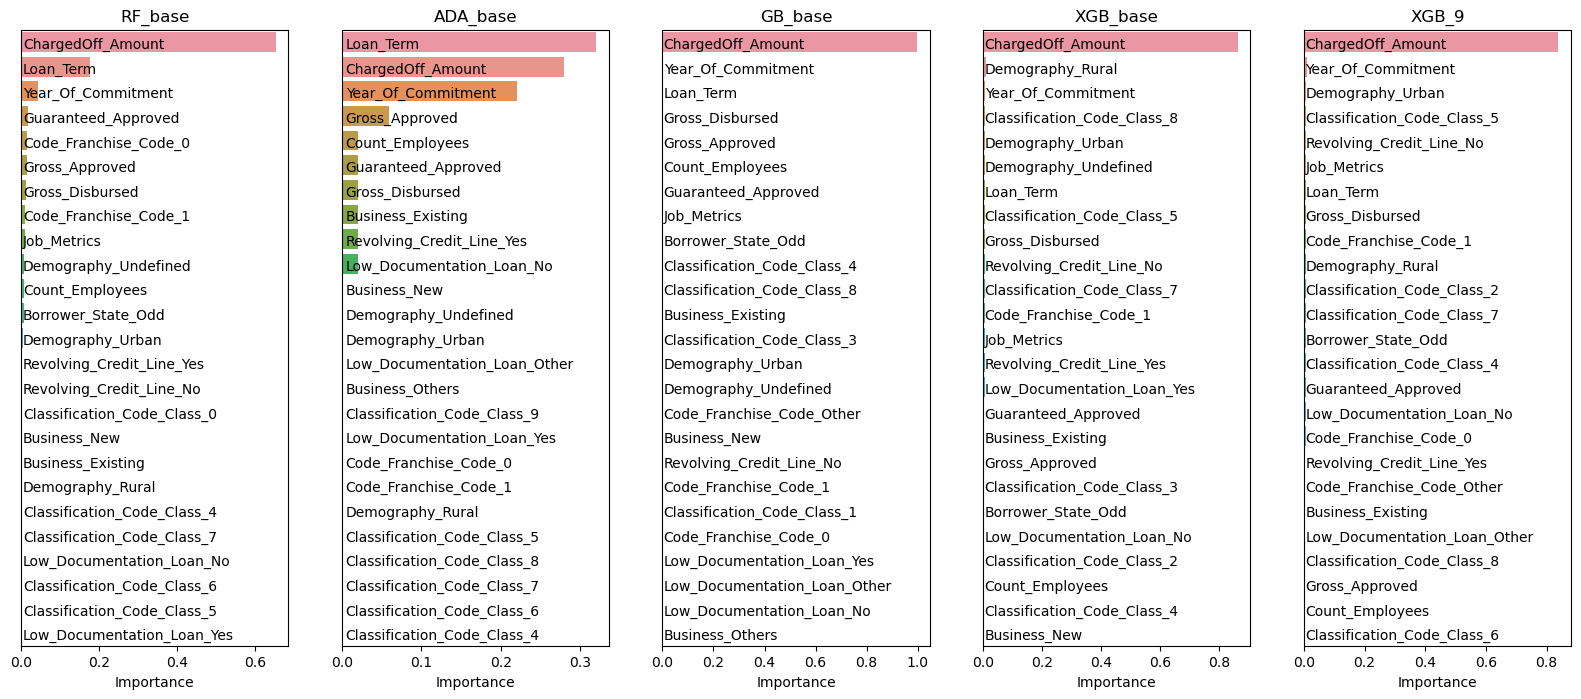

CPU times: total: 2h 36min 38s
Wall time: 39min 33s


In [126]:
%%time
data_name = 'Test2.3_'

loop_odds = [
    ('Low_Doc'   ,True ,False,False,False,False,False,False,False),
    ('Rev_Cre'   ,False,True ,False,False,False,False,False,False),
    ('Busi'      ,False,False,True ,False,False,False,False,False),
    ('Demo'      ,False,False,False,True ,False,False,False,False),
    ('Class_Code',False,False,False,False,True ,False,False,False),
    ('Code_Fran' ,False,False,False,False,False,True ,False,False),
    ('Name_Bank' ,False,False,False,False,False,False,True ,False),
    ('Borrower'  ,False,False,False,False,False,False,False,True )
    ]

for odd_added, Low_Doc,Rev_Cre,Busi,Demo,Class_Code,Code_Fran,Name_Bank,Borrower in loop_odds:
    print(odd_added)
    X_train, X_test, y_train, y_test, df_submit = data_transform_pipeline(
        sample_test = -1,
        # replace categorical with odd
        Low_Documentation_Loan_Odd  = Low_Doc, 
        Low_Documentation_Loan_drop = Low_Doc,
        Revolving_Credit_Line_Odd   = Rev_Cre,
        Revolving_Credit_Line_drop  = Rev_Cre,
        Business_Odd          = Busi,
        Business_drop         = Busi,
        Demography_Odd        = Demo,
        Demography_drop       = Demo,
        Classification_Code_Odd  = Class_Code,
        Classification_Code_drop = Class_Code,
        Code_Franchise_Odd       = Code_Fran,
        Code_Franchise_drop      = Code_Fran,
        Name_Of_Bank_Odd   = Name_Bank,
        Borrower_State_Odd = Borrower,

        # replace loan amount with pct/diff
        Loan1_Loan3_pct  = False,
        Loan1_Loan3_diff = False,
        Loan2_Loan3_pct  = False,
        Loan2_Loan3_diff = False,
        Loan1_drop = False,
        Loan2_drop = False,
        Loan3_drop = False,

        # add engineered features
        add_multiply = False,
        add_sum      = False,
        add_subtract = False,
        add_divide   = False,

        # processing
        drop_cols     = [],
        drop_first    = False,
        std_scale     = False,
        to_array      = False,
        test_size     = 0.2)


    models_list = [
        (RF_base,'RF_base'),
        (ADA_base,'ADA_base'),
        (GB_base,'GB_base'),
        (XGB_base,'XGB_base'),
        (XGB_9,'XGB_9')
    ]

    for model, model_name in models_list:
        print('Model:',model_name)
        model_performance(model, model_name, data_name+odd_added+'_drop', X_train, X_test, y_train, y_test, cv=5)

    feature_imp(models_list)

In [127]:
df_metrics

model                   data    time  train_acc  \
0   DTree_base             1. Vanilla    4.41   100.0000   
1      RF_base             1. Vanilla   56.08    99.9988   
2     ADA_base             1. Vanilla   36.45    99.4060   
3      GB_base             1. Vanilla  123.75    99.4786   
4      LG_base             1. Vanilla    3.68    98.3571   
..         ...                    ...     ...        ...   
87     RF_base  Test2.3_Borrower_drop   57.13    99.9988   
88    ADA_base  Test2.3_Borrower_drop   37.21    99.4060   
89     GB_base  Test2.3_Borrower_drop  128.19    99.4750   
90    XGB_base  Test2.3_Borrower_drop   22.46    99.6464   
91       XGB_9  Test2.3_Borrower_drop   67.44    99.8988   

                                   train_PRF1       test_acc  \
0         1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        98.7143   
1         1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4286   
2      0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0        99.3857   
3      0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0        99.4381   
4   0.99 - 0.96 - 0.97  |  0.98 - 0.99 - 0.99        98.2524   
..                                        ...  ...       ...   
87        1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4190   
88     0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0        99.3857   
89     0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0        99.4476   
90      0.99 - 1.0 - 0.99  |  1.0 - 1.0 - 1.0        99.4381   
91        1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4095   

                                    test_PRF1        cv_acc         cv_range  \
0   0.98 - 0.97 - 0.98  |  0.99 - 0.99 - 0.99       98.8114  0.9892 - 0.9871   
1      0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4314  0.9952 - 0.9938   
2      0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4010   0.995 - 0.9933   
3      0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4257   0.995 - 0.9936   
4   0.98 - 0.95 - 0.97  |  0.98 - 0.99 - 0.99       98.6676  0.9895 - 0.9825   
..                                        ...  ...      ...              ...   
87     0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4286  0.9952 - 0.9937   
88     0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4010   0.995 - 0.9933   
89     0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4267  0.9951 - 0.9934   
90     0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4410  0.9953 - 0.9938   
91     0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4314  0.9953 - 0.9937   

       pred_ratio  
0   72.42 / 27.58  
1   71.89 / 28.11  
2   71.92 / 28.08  
3   71.88 / 28.12  
4   72.76 / 27.24  
..            ...  
87  71.89 / 28.11  
88  71.92 / 28.08  
89  71.88 / 28.12  
90  71.87 / 28.13  
91  71.88 / 28.12  

[92 rows x 12 columns]

In [128]:
df_metrics.to_csv('df_metrics_Test2122_092158.csv', index=False)

### 2.4 Add only bank odd

Name_Bank
Model: XGB_base
Training:  XGB_base / Test2.4_Name_Bank_odd
[19:42:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:42:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:42:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval

TypeError: barplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 1 keyword-only argument) were given

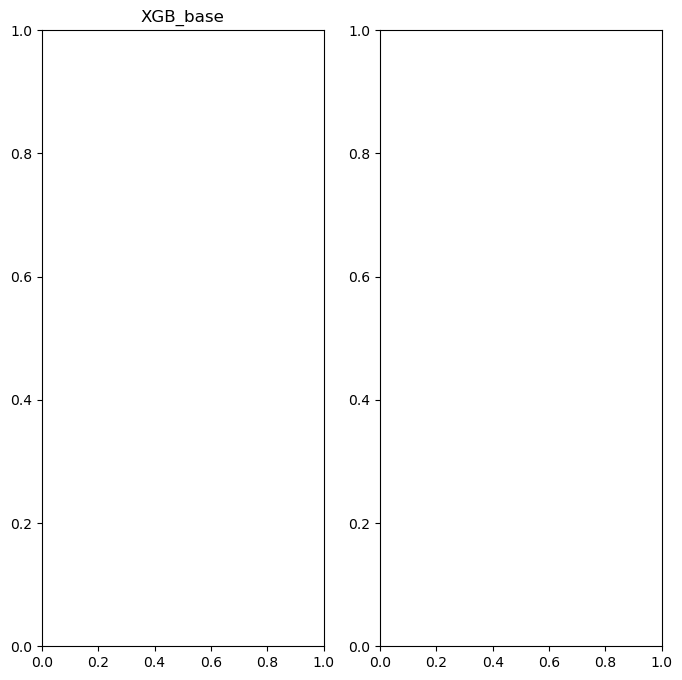

In [30]:
%%time
data_name      = 'Test2.4_'
data_name_post = '_odd'

loop_odds = [
    # ('Low_Doc'   ,True ,False,False,False,False,False,False,False),
    # ('Rev_Cre'   ,False,True ,False,False,False,False,False,False),
    # ('Busi'      ,False,False,True ,False,False,False,False,False),
    # ('Demo'      ,False,False,False,True ,False,False,False,False),
    # ('Class_Code',False,False,False,False,True ,False,False,False),
    # ('Code_Fran' ,False,False,False,False,False,True ,False,False),
    ('Name_Bank' ,False,False,False,False,False,False,True ,False),
    # ('Borrower'  ,False,False,False,False,False,False,False,True )
    ]

for odd_added, Low_Doc,Rev_Cre,Busi,Demo,Class_Code,Code_Fran,Name_Bank,Borrower in loop_odds:
    print(odd_added)
    X_train, X_test, y_train, y_test, df_submit = data_transform_pipeline(
        sample_test = -1,
        # replace categorical with odd
        Low_Documentation_Loan_Odd  = Low_Doc, 
        Low_Documentation_Loan_drop = False,
        Revolving_Credit_Line_Odd   = Rev_Cre,
        Revolving_Credit_Line_drop  = False,
        Business_Odd          = Busi,
        Business_drop         = False,
        Demography_Odd        = Demo,
        Demography_drop       = False,
        Classification_Code_Odd  = Class_Code,
        Classification_Code_drop = False,
        Code_Franchise_Odd       = Code_Fran,
        Code_Franchise_drop      = False,
        Name_Of_Bank_Odd   = Name_Bank,
        Borrower_State_Odd = Borrower,

        # replace loan amount with pct/diff
        Loan1_Loan3_pct  = False,
        Loan1_Loan3_diff = False,
        Loan2_Loan3_pct  = False,
        Loan2_Loan3_diff = False,
        Loan1_drop = False,
        Loan2_drop = False,
        Loan3_drop = False,

        # add engineered features
        add_multiply = False,
        add_sum      = False,
        add_subtract = False,
        add_divide   = False,

        # processing
        drop_cols     = [],
        drop_first    = False,
        std_scale     = False,
        to_array      = False,
        test_size     = 0.2)


    models_list = [
        # (RF_base,'RF_base'),
        # (ADA_base,'ADA_base'),
        # (GB_base,'GB_base'),
        (XGB_base,'XGB_base'),
        (XGB_9,'XGB_9')
    ]

    for model, model_name in models_list:
        print('Model:',model_name)
        model_performance(model, model_name, data_name + odd_added + data_name_post, X_train, X_test, y_train, y_test, cv=5)

    feature_imp(models_list)

In [31]:
# reset(df_metrics)
df_metrics

model                   data    time  train_acc  \
0   DTree_base             1. Vanilla    4.58   100.0000   
1      RF_base             1. Vanilla   58.75    99.9988   
2     ADA_base             1. Vanilla   39.14    99.4060   
3      GB_base             1. Vanilla   129.7    99.4786   
4      LG_base             1. Vanilla     4.0    98.3571   
5     XGB_base             1. Vanilla   24.15    99.6167   
6        XGB_9             1. Vanilla   76.48    99.8607   
7      RF_base    Test2.1 Add_All_Odd   66.83    99.9988   
8     ADA_base    Test2.1 Add_All_Odd   44.63    99.4060   
9      GB_base    Test2.1 Add_All_Odd  158.64    99.4798   
10    XGB_base    Test2.1 Add_All_Odd   28.97    99.6738   
11       XGB_9    Test2.1 Add_All_Odd   83.31    99.9274   
12    XGB_base  Test2.4_Name_Bank_odd    24.2    99.6452   
13       XGB_9  Test2.4_Name_Bank_odd   74.18    99.8679   

                                   train_PRF1       test_acc  \
0         1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        98.7333   
1         1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4190   
2      0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0        99.3857   
3      0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0        99.4333   
4   0.99 - 0.96 - 0.97  |  0.98 - 0.99 - 0.99        98.2524   
5       0.99 - 1.0 - 0.99  |  1.0 - 1.0 - 1.0        99.4429   
6         1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4286   
7         1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4095   
8      0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0        99.3857   
9      0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0        99.4476   
10      0.99 - 1.0 - 0.99  |  1.0 - 1.0 - 1.0        99.4238   
11        1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4381   
12      0.99 - 1.0 - 0.99  |  1.0 - 1.0 - 1.0        99.4143   
13        1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4333   

                                    test_PRF1        cv_acc         cv_range  \
0   0.98 - 0.97 - 0.98  |  0.99 - 0.99 - 0.99       98.8362  0.9897 - 0.9873   
1      0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4267  0.9952 - 0.9937   
2      0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4010   0.995 - 0.9933   
3      0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4276  0.9951 - 0.9936   
4   0.98 - 0.95 - 0.97  |  0.98 - 0.99 - 0.99       98.6676  0.9895 - 0.9825   
5      0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4343  0.9952 - 0.9938   
6      0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4400  0.9953 - 0.9938   
7      0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4267  0.9952 - 0.9936   
8      0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4010   0.995 - 0.9933   
9      0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4314  0.9951 - 0.9935   
10     0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4371  0.9954 - 0.9938   
11     0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4400  0.9955 - 0.9937   
12     0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4352  0.9954 - 0.9938   
13     0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4438  0.9955 - 0.9937   

       pred_ratio  
0   72.42 / 27.58  
1   71.89 / 28.11  
2   71.92 / 28.08  
3   71.88 / 28.12  
4   72.76 / 27.24  
5   71.87 / 28.13  
6   71.87 / 28.13  
7   71.89 / 28.11  
8   71.92 / 28.08  
9   71.88 / 28.12  
10  71.88 / 28.12  
11  71.87 / 28.13  
12  71.88 / 28.12  
13  71.87 / 28.13

In [32]:
make_submission(models_list[-1:], data_name, retrain = True)

[0]	validation_0-aucpr:0.99713
[1]	validation_0-aucpr:0.99725
[2]	validation_0-aucpr:0.99736
[3]	validation_0-aucpr:0.99737
[4]	validation_0-aucpr:0.99743
[5]	validation_0-aucpr:0.99748
[6]	validation_0-aucpr:0.99750
[7]	validation_0-aucpr:0.99754
[8]	validation_0-aucpr:0.99758
[9]	validation_0-aucpr:0.99765
[10]	validation_0-aucpr:0.99768
[11]	validation_0-aucpr:0.99771
[12]	validation_0-aucpr:0.99772
[13]	validation_0-aucpr:0.99805
[14]	validation_0-aucpr:0.99826
[15]	validation_0-aucpr:0.99832
[16]	validation_0-aucpr:0.99838
[17]	validation_0-aucpr:0.99844
[18]	validation_0-aucpr:0.99845
[19]	validation_0-aucpr:0.99854
[20]	validation_0-aucpr:0.99854
[21]	validation_0-aucpr:0.99854
[22]	validation_0-aucpr:0.99859
[23]	validation_0-aucpr:0.99862
[24]	validation_0-aucpr:0.99864
[25]	validation_0-aucpr:0.99863
[26]	validation_0-aucpr:0.99866
[27]	validation_0-aucpr:0.99874
[28]	validation_0-aucpr:0.99880
[29]	validation_0-aucpr:0.99878
[30]	validation_0-aucpr:0.99881
[31]	validation_0-

OSError: Cannot save file into a non-existent directory: 'SUBMISSIONS'

In [ ]:
plt.figure(figsize=(8,6))
for model, model_name in models_list:
    yhat_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test, yhat_proba)
    sns.lineplot(x=fpr,y=tpr, label=model_name)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.ylim((0.96,1)),plt.xlim((0.0,0.05))
plt.show()   

In [ ]:
yhat_test = XGB_9.predict(X_test)
make_CF(y_test, yhat_test)

## 3. Work with loan columns

### 3.1 Add all loans

All_loans_features
Model: RF_base
Training:  RF_base / Test3.1_All_loans_features
Finished in 69.45
Model: ADA_base
Training:  ADA_base / Test3.1_All_loans_features
Finished in 42.98
Model: GB_base
Training:  GB_base / Test3.1_All_loans_features
Finished in 156.75
Model: XGB_base
Training:  XGB_base / Test3.1_All_loans_features
[13:06:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:06:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:06:06] WARNI

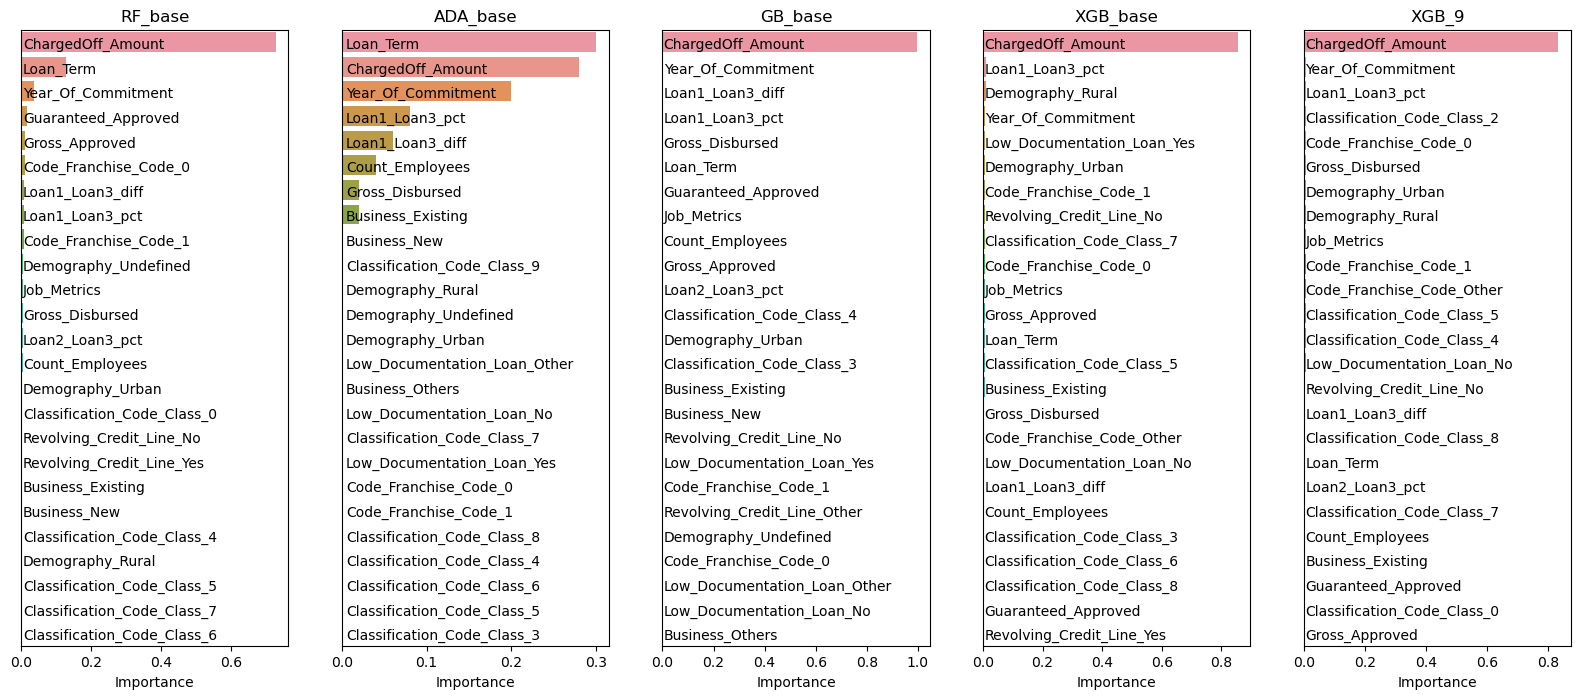

CPU times: total: 23min 15s
Wall time: 6min 11s


In [155]:
%%time
# 25min 11s
data_name = 'Test3.1_All_loans_features'

loop_odds = [
    ('All_loans_features',True ,True ,True ,True ),
    # ('Loan1_Loan3_pct' ,True ,False,False,False),
    # ('Loan1_Loan3_diff',False,True ,False,False),
    # ('Loan2_Loan3_pct' ,False,False,True ,False),
    # ('Loan2_Loan3_diff',False,False,False,True )
    ]
    

for loan_added, Loan1_Loan3_pct, Loan1_Loan3_diff, Loan2_Loan3_pct, Loan2_Loan3_diff in loop_odds:
    print(loan_added)
    X_train, X_test, y_train, y_test, df_submit = data_transform_pipeline(
        sample_test = -1,
        # replace categorical with odd
        Low_Documentation_Loan_Odd  = False, 
        Low_Documentation_Loan_drop = False,
        Revolving_Credit_Line_Odd   = False,
        Revolving_Credit_Line_drop  = False,
        Business_Odd          = False,
        Business_drop         = False,
        Demography_Odd        = False,
        Demography_drop       = False,
        Classification_Code_Odd  = False,
        Classification_Code_drop = False,
        Code_Franchise_Odd       = False,
        Code_Franchise_drop      = False,
        Name_Of_Bank_Odd   = False,
        Borrower_State_Odd = False,

        # replace loan amount with pct/diff
        Loan1_Loan3_pct  = Loan1_Loan3_pct,
        Loan1_Loan3_diff = Loan1_Loan3_diff,
        Loan2_Loan3_pct  = Loan2_Loan3_pct,
        Loan2_Loan3_diff = Loan2_Loan3_diff,
        Loan1_drop = False,
        Loan2_drop = False,
        Loan3_drop = False,

        # add engineered features
        add_multiply = False,
        add_sum      = False,
        add_subtract = False,
        add_divide   = False,

        # processing
        drop_cols     = [],
        drop_first    = False,
        std_scale     = False,
        to_array      = False,
        test_size     = 0.2)


    models_list = [
        (RF_base,'RF_base'),
        (ADA_base,'ADA_base'),
        (GB_base,'GB_base'),
        (XGB_base,'XGB_base'),
        (XGB_9,'XGB_9')
    ]

    for model, model_name in models_list:
        print('Model:',model_name)
        model_performance(model, model_name, data_name, X_train, X_test, y_train, y_test, cv=5)

    feature_imp(models_list)

In [159]:
#reset(df_metrics)
df_metrics

Empty DataFrame
Columns: [model, data, time, train_acc, train_PRF1,    , test_acc, test_PRF1,    , cv_acc, cv_range, pred_ratio]
Index: []

In [157]:
# xgb_9 submission
make_submission(models_list[-1:], 'Test3.1_All_loans_features', retrain = True)

[0]	validation_0-aucpr:0.99655
[1]	validation_0-aucpr:0.99658
[2]	validation_0-aucpr:0.99695
[3]	validation_0-aucpr:0.99706
[4]	validation_0-aucpr:0.99710
[5]	validation_0-aucpr:0.99719
[6]	validation_0-aucpr:0.99723
[7]	validation_0-aucpr:0.99725
[8]	validation_0-aucpr:0.99725
[9]	validation_0-aucpr:0.99729
[10]	validation_0-aucpr:0.99722
[11]	validation_0-aucpr:0.99735
[12]	validation_0-aucpr:0.99757
[13]	validation_0-aucpr:0.99773
[14]	validation_0-aucpr:0.99790
[15]	validation_0-aucpr:0.99797
[16]	validation_0-aucpr:0.99800
[17]	validation_0-aucpr:0.99812
[18]	validation_0-aucpr:0.99816
[19]	validation_0-aucpr:0.99817
[20]	validation_0-aucpr:0.99828
[21]	validation_0-aucpr:0.99832
[22]	validation_0-aucpr:0.99853
[23]	validation_0-aucpr:0.99859
[24]	validation_0-aucpr:0.99860
[25]	validation_0-aucpr:0.99865
[26]	validation_0-aucpr:0.99872
[27]	validation_0-aucpr:0.99877
[28]	validation_0-aucpr:0.99879
[29]	validation_0-aucpr:0.99879
[30]	validation_0-aucpr:0.99891
[31]	validation_0-

In [158]:
# rf submission
make_submission_tree(models_list[0:1], 'Test3.1_All_loans_features', retrain = True)

71.72 / 28.28
Exported Test3.1_All_loans_features_RF_base.csv


## 4. Add derivative features

### 4.0 Base
Base on adding loan column

Model: RF_base
Training:  RF_base / Test2.4_
Finished in 69.92
Model: ADA_base
Training:  ADA_base / Test2.4_
Finished in 44.25
Model: GB_base
Training:  GB_base / Test2.4_
Finished in 158.23
Model: XGB_base
Training:  XGB_base / Test2.4_
[21:09:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:10:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:10:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learn

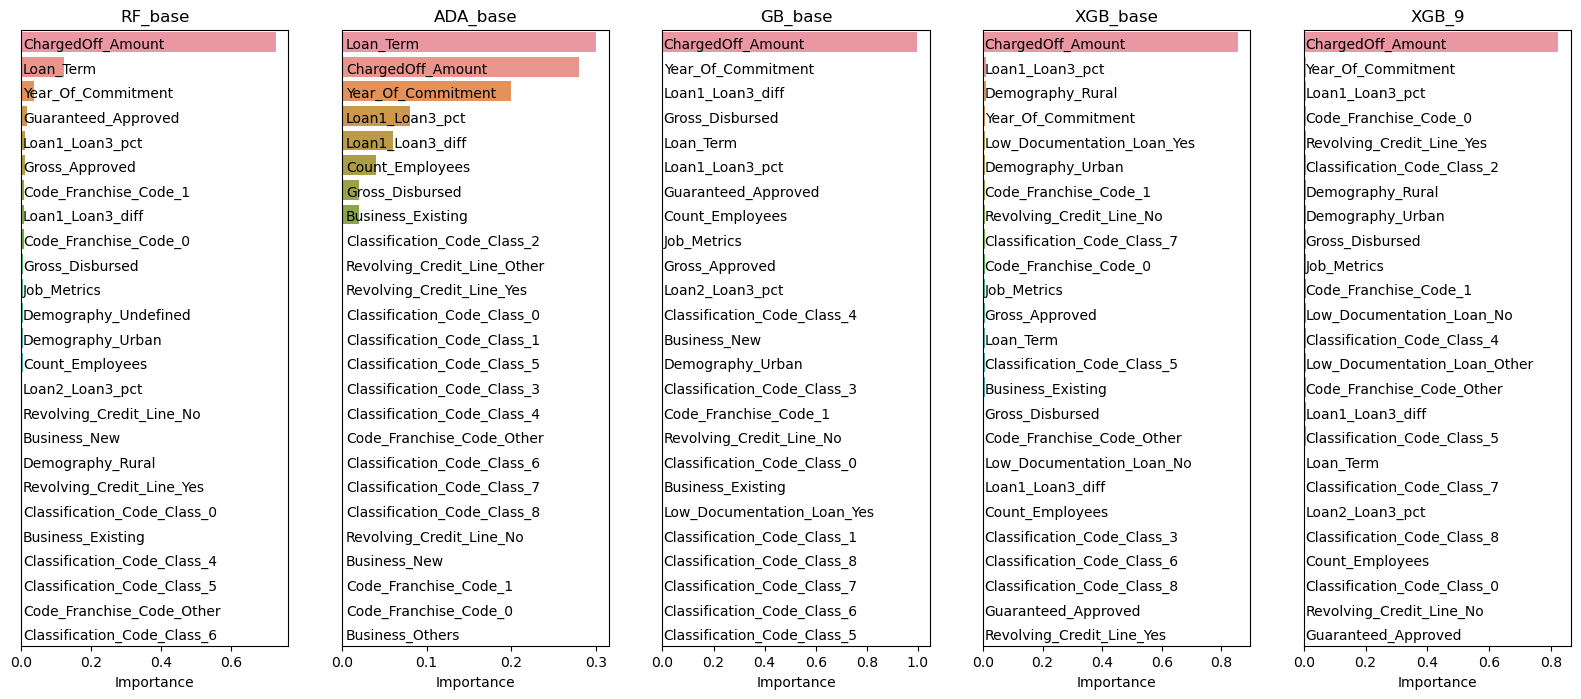

CPU times: total: 23min 19s
Wall time: 6min 17s


In [42]:
%%time
sdata_name = 'Test4.0 Base'

X_train, X_test, y_train, y_test, df_submit = data_transform_pipeline(
    sample_test = -1,
    # replace categorical with odd
    Low_Documentation_Loan_Odd  = False, 
    Low_Documentation_Loan_drop = False,
    Revolving_Credit_Line_Odd   = False,
    Revolving_Credit_Line_drop  = False,
    Business_Odd          = False,
    Business_drop         = False,
    Demography_Odd        = False,
    Demography_drop       = False,
    Classification_Code_Odd  = False,
    Classification_Code_drop = False,
    Code_Franchise_Odd       = False,
    Code_Franchise_drop      = False,
    Name_Of_Bank_Odd   = False,
    Borrower_State_Odd = False,

    # replace loan amount with pct/diff
    Loan1_Loan3_pct  = True,
    Loan1_Loan3_diff = True,
    Loan2_Loan3_pct  = True,
    Loan2_Loan3_diff = True,
    Loan1_drop = False,
    Loan2_drop = False,
    Loan3_drop = False,

    # add engineered features
    add_multiply = False,
    add_sum      = False,
    add_subtract = False,
    add_divide   = False,

    # processing
    drop_cols     = [],
    drop_first    = False,
    std_scale     = False,
    to_array      = False,
    test_size     = 0.2)


models_list = [
    (RF_base,'RF_base'),
    (ADA_base,'ADA_base'),
    (GB_base,'GB_base'),
    (XGB_base,'XGB_base'),
    (XGB_9,'XGB_9')
]

for model, model_name in models_list:
    print('Model:',model_name)
    model_performance(model, model_name, data_name, X_train, X_test, y_train, y_test, cv=5)

feature_imp(models_list)

In [43]:
# reset(df_metrics)
df_metrics

model      data    time  train_acc  \
0   RF_base  Test2.4_   69.92    99.9988   
1  ADA_base  Test2.4_   44.25    99.4083   
2   GB_base  Test2.4_  158.23    99.5012   
3  XGB_base  Test2.4_    25.9    99.6131   
4     XGB_9  Test2.4_   77.31    99.8655   

                               train_PRF1       test_acc  \
0     1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4381   
1  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0        99.3857   
2  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0        99.4381   
3   0.99 - 1.0 - 0.99  |  1.0 - 1.0 - 1.0        99.4190   
4     1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4476   

                                test_PRF1        cv_acc         cv_range  \
0  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4533  0.9955 - 0.9939   
1  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4000  0.9949 - 0.9933   
2  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4381  0.9953 - 0.9937   
3  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4476  0.9955 - 0.9939   
4  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4571   0.9956 - 0.994   

      pred_ratio  
0  71.86 / 28.14  
1  71.92 / 28.08  
2  71.87 / 28.13  
3  71.86 / 28.14  
4  71.86 / 28.14

### 4.1 Add sum
**RF highest 0.995**

Model: RF_base
Training:  RF_base / Test4.1 Add sum
Finished in 338.46


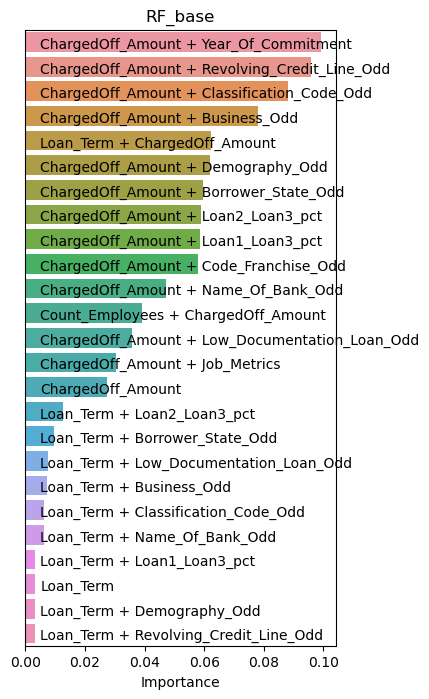

CPU times: total: 5min 42s
Wall time: 5min 42s


In [44]:
%%time
data_name = 'Test4.1 Add sum'

X_train, X_test, y_train, y_test, df_submit = data_transform_pipeline(
    sample_test = -1,
    # replace categorical with odd
    Low_Documentation_Loan_Odd  = False, 
    Low_Documentation_Loan_drop = False,
    Revolving_Credit_Line_Odd   = False,
    Revolving_Credit_Line_drop  = False,
    Business_Odd          = False,
    Business_drop         = False,
    Demography_Odd        = False,
    Demography_drop       = False,
    Classification_Code_Odd  = False,
    Classification_Code_drop = False,
    Code_Franchise_Odd       = False,
    Code_Franchise_drop      = False,
    Name_Of_Bank_Odd   = False,
    Borrower_State_Odd = False,

    # replace loan amount with pct/diff
    Loan1_Loan3_pct  = True,
    Loan1_Loan3_diff = True,
    Loan2_Loan3_pct  = True,
    Loan2_Loan3_diff = True,
    Loan1_drop = False,
    Loan2_drop = False,
    Loan3_drop = False,

    # add engineered features
    add_sum      = True,
    add_multiply = False,
    add_subtract = False,
    add_divide   = False,

    # processing
    drop_cols     = [],
    drop_first    = False,
    std_scale     = False,
    to_array      = False,
    test_size     = 0.2)


models_list = [
    (RF_base,'RF_base'),
    #(ADA_base,'ADA_base'),
    # (GB_base,'GB_base'),
    # (XGB_base,'XGB_base'),
    #(XGB_9,'XGB_9')
]

for model, model_name in models_list:
    print('Model:',model_name)
    model_performance(model, model_name, data_name, X_train, X_test, y_train, y_test, cv=5)

feature_imp(models_list)

In [45]:
df_metrics

model             data    time  train_acc  \
0   RF_base         Test2.4_   69.92    99.9988   
1  ADA_base         Test2.4_   44.25    99.4083   
2   GB_base         Test2.4_  158.23    99.5012   
3  XGB_base         Test2.4_    25.9    99.6131   
4     XGB_9         Test2.4_   77.31    99.8655   
5   RF_base  Test4.1 Add sum  338.46    99.9988   

                               train_PRF1       test_acc  \
0     1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4381   
1  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0        99.3857   
2  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0        99.4381   
3   0.99 - 1.0 - 0.99  |  1.0 - 1.0 - 1.0        99.4190   
4     1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4476   
5     1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4381   

                                test_PRF1        cv_acc         cv_range  \
0  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4533  0.9955 - 0.9939   
1  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4000  0.9949 - 0.9933   
2  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4381  0.9953 - 0.9937   
3  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4476  0.9955 - 0.9939   
4  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4571   0.9956 - 0.994   
5  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4581   0.9957 - 0.994   

      pred_ratio  
0  71.86 / 28.14  
1  71.92 / 28.08  
2  71.87 / 28.13  
3  71.86 / 28.14  
4  71.86 / 28.14  
5  71.86 / 28.14

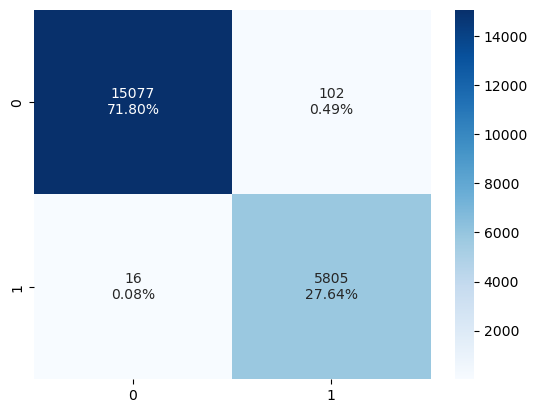

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     15179
           1       0.98      1.00      0.99      5821

    accuracy                           0.99     21000
   macro avg       0.99      1.00      0.99     21000
weighted avg       0.99      0.99      0.99     21000



In [46]:
yhat_test = RF_base.predict(X_test)
make_CF(y_test, yhat_test)

In [48]:
make_submission_tree(models_list[:1], data_name, retrain = True)
# highest 0.995

OSError: Cannot save file into a non-existent directory: 'SUBMISSIONS'

In [ ]:
joblib.dump(RF_base, 'Test4.1 Add sum_RF_base.sav')

### 4.2 Add multiply

Model: RF_base
Training:  RF_base / Test4.2 Add multiply
Finished in 320.72
Model: ADA_base
Training:  ADA_base / Test4.2 Add multiply
Finished in 419.17
Model: XGB_9
Training:  XGB_9 / Test4.2 Add multiply
[14:43:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:43:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:44:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 

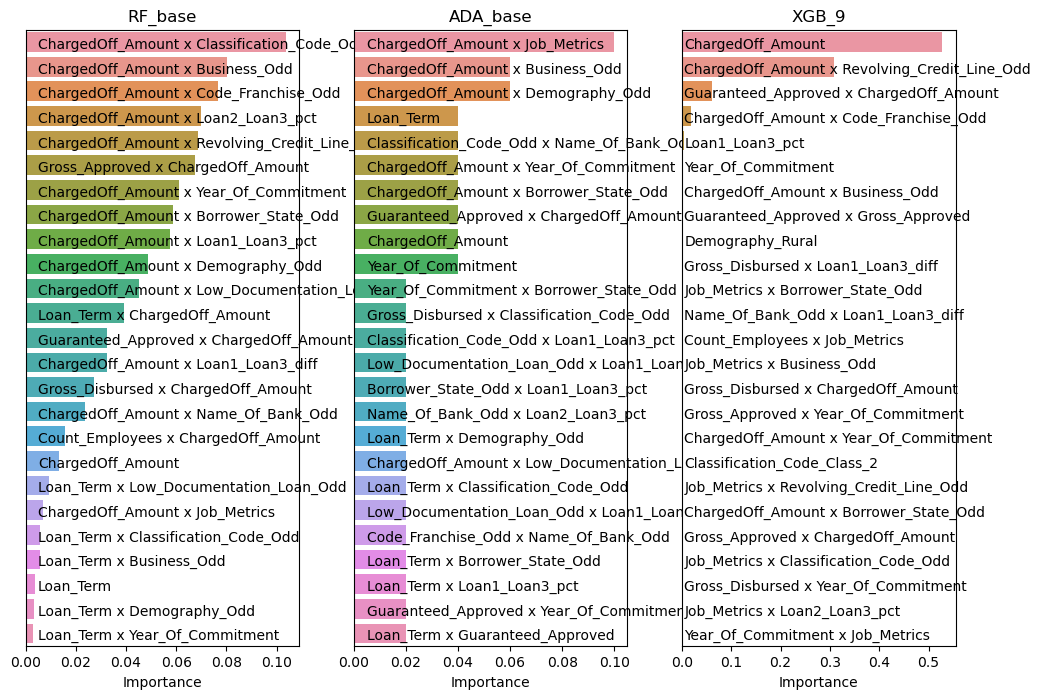

CPU times: total: 1h 43min 56s
Wall time: 20min 36s


In [171]:
%%time
data_name = 'Test4.2 Add multiply'

X_train, X_test, y_train, y_test, df_submit = data_transform_pipeline(
    sample_test = -1,
    # replace categorical with odd
    Low_Documentation_Loan_Odd  = False, 
    Low_Documentation_Loan_drop = False,
    Revolving_Credit_Line_Odd   = False,
    Revolving_Credit_Line_drop  = False,
    Business_Odd          = False,
    Business_drop         = False,
    Demography_Odd        = False,
    Demography_drop       = False,
    Classification_Code_Odd  = False,
    Classification_Code_drop = False,
    Code_Franchise_Odd       = False,
    Code_Franchise_drop      = False,
    Name_Of_Bank_Odd   = False,
    Borrower_State_Odd = False,

    # replace loan amount with pct/diff
    Loan1_Loan3_pct  = True,
    Loan1_Loan3_diff = True,
    Loan2_Loan3_pct  = True,
    Loan2_Loan3_diff = True,
    Loan1_drop = False,
    Loan2_drop = False,
    Loan3_drop = False,

    # add engineered features
    add_sum      = False,
    add_multiply = True,
    add_subtract = False,
    add_divide   = False,

    # processing
    drop_cols     = [],
    drop_first    = False,
    std_scale     = False,
    to_array      = False,
    test_size     = 0.2)


models_list = [
    (RF_base,'RF_base'),
    (ADA_base,'ADA_base'),
    # (GB_base,'GB_base'),
    # (XGB_base,'XGB_base'),
    (XGB_9,'XGB_9')
]

for model, model_name in models_list:
    print('Model:',model_name)
    model_performance(model, model_name, data_name, X_train, X_test, y_train, y_test, cv=5)

feature_imp(models_list)

In [172]:
df_metrics

model                  data    time  train_acc  \
0    RF_base          Test4.0 Base   68.29    99.9988   
1   ADA_base          Test4.0 Base   42.29    99.4083   
2    GB_base          Test4.0 Base  154.83    99.5012   
3   XGB_base          Test4.0 Base   24.56    99.6131   
4      XGB_9          Test4.0 Base   73.88    99.8417   
5    RF_base       Test4.1 Add sum  337.33    99.9988   
6   ADA_base       Test4.1 Add sum  446.98    99.4310   
7      XGB_9       Test4.1 Add sum  505.28    99.9857   
8    RF_base  Test4.2 Add multiply  320.72    99.9988   
9   ADA_base  Test4.2 Add multiply  419.17    99.4024   
10     XGB_9  Test4.2 Add multiply  491.46   100.0000   

                                train_PRF1       test_acc  \
0      1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4381   
1   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0        99.3857   
2   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0        99.4286   
3    0.99 - 1.0 - 0.99  |  1.0 - 1.0 - 1.0        99.4190   
4     0.99 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4429   
5      1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4524   
6   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0        99.4286   
7      1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4524   
8      1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4333   
9   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0        99.3857   
10     1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4238   

                                 test_PRF1        cv_acc         cv_range  \
0   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4552   0.9956 - 0.994   
1   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4000  0.9949 - 0.9933   
2   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4400  0.9953 - 0.9937   
3   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4476  0.9955 - 0.9939   
4   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4571   0.9956 - 0.994   
5   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4543  0.9956 - 0.9939   
6   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4314  0.9953 - 0.9937   
7   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4562  0.9956 - 0.9939   
8   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4514  0.9956 - 0.9939   
9   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4000  0.9949 - 0.9933   
10  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4476  0.9956 - 0.9939   

       pred_ratio  
0   71.86 / 28.14  
1   71.92 / 28.08  
2   71.87 / 28.13  
3   71.86 / 28.14  
4   71.86 / 28.14  
5   71.86 / 28.14  
6   71.88 / 28.12  
7   71.86 / 28.14  
8   71.86 / 28.14  
9   71.92 / 28.08  
10  71.87 / 28.13

In [173]:
make_submission(models_list[-1:], data_name, retrain = True)

[0]	validation_0-aucpr:0.99656
[1]	validation_0-aucpr:0.99662
[2]	validation_0-aucpr:0.99667
[3]	validation_0-aucpr:0.99687
[4]	validation_0-aucpr:0.99689
[5]	validation_0-aucpr:0.99698
[6]	validation_0-aucpr:0.99722
[7]	validation_0-aucpr:0.99750
[8]	validation_0-aucpr:0.99777
[9]	validation_0-aucpr:0.99788
[10]	validation_0-aucpr:0.99796
[11]	validation_0-aucpr:0.99842
[12]	validation_0-aucpr:0.99842
[13]	validation_0-aucpr:0.99861
[14]	validation_0-aucpr:0.99867
[15]	validation_0-aucpr:0.99867
[16]	validation_0-aucpr:0.99875
[17]	validation_0-aucpr:0.99879
[18]	validation_0-aucpr:0.99880
[19]	validation_0-aucpr:0.99885
[20]	validation_0-aucpr:0.99888
[21]	validation_0-aucpr:0.99888
[22]	validation_0-aucpr:0.99889
[23]	validation_0-aucpr:0.99898
[24]	validation_0-aucpr:0.99902
[25]	validation_0-aucpr:0.99907
[26]	validation_0-aucpr:0.99920
[27]	validation_0-aucpr:0.99943
[28]	validation_0-aucpr:0.99946
[29]	validation_0-aucpr:0.99950
[30]	validation_0-aucpr:0.99954
[31]	validation_0-

In [174]:
make_submission_tree(models_list[:1], data_name, retrain = True)

71.74 / 28.26
Exported Test4.2 Add multiply_RF_base.csv


### 4.3 Add subtract

Model: RF_base
Training:  RF_base / Test4.3 Add subtract
Finished in 513.1
Model: ADA_base
Training:  ADA_base / Test4.3 Add subtract
Finished in 838.9
Model: XGB_9
Training:  XGB_9 / Test4.3 Add subtract
[21:25:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:27:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.

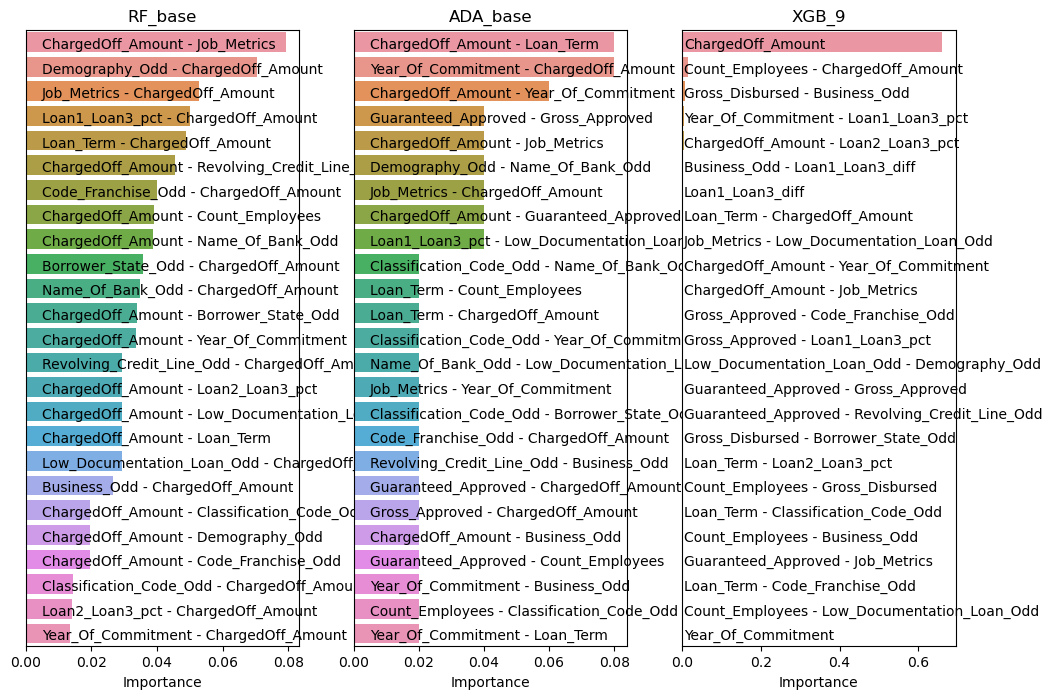

CPU times: total: 3h 11min 55s
Wall time: 37min 49s


In [196]:
%%time
data_name = 'Test4.3 Add subtract'

X_train, X_test, y_train, y_test, df_submit = data_transform_pipeline(
    sample_test = -1,
    # replace categorical with odd
    Low_Documentation_Loan_Odd  = False, 
    Low_Documentation_Loan_drop = False,
    Revolving_Credit_Line_Odd   = False,
    Revolving_Credit_Line_drop  = False,
    Business_Odd          = False,
    Business_drop         = False,
    Demography_Odd        = False,
    Demography_drop       = False,
    Classification_Code_Odd  = False,
    Classification_Code_drop = False,
    Code_Franchise_Odd       = False,
    Code_Franchise_drop      = False,
    Name_Of_Bank_Odd   = False,
    Borrower_State_Odd = False,

    # replace loan amount with pct/diff
    Loan1_Loan3_pct  = True,
    Loan1_Loan3_diff = True,
    Loan2_Loan3_pct  = True,
    Loan2_Loan3_diff = True,
    Loan1_drop = False,
    Loan2_drop = False,
    Loan3_drop = False,

    # add engineered features
    add_sum      = False,
    add_multiply = False,
    add_subtract = True,
    add_divide   = False,

    # processing
    drop_cols     = [],
    drop_first    = False,
    std_scale     = False,
    to_array      = False,
    test_size     = 0.2)


models_list = [
    (RF_base,'RF_base'),
    (ADA_base,'ADA_base'),
    # (GB_base,'GB_base'),
    # (XGB_base,'XGB_base'),
    (XGB_9,'XGB_9')
]

for model, model_name in models_list:
    print('Model:',model_name)
    model_performance(model, model_name, data_name, X_train, X_test, y_train, y_test, cv=5)

feature_imp(models_list)

In [197]:
df_metrics

model                  data    time  train_acc  \
0    RF_base          Test4.0 Base   68.29    99.9988   
1   ADA_base          Test4.0 Base   42.29    99.4083   
2    GB_base          Test4.0 Base  154.83    99.5012   
3   XGB_base          Test4.0 Base   24.56    99.6131   
4      XGB_9          Test4.0 Base   73.88    99.8417   
5    RF_base       Test4.1 Add sum  337.33    99.9988   
6   ADA_base       Test4.1 Add sum  446.98    99.4310   
7      XGB_9       Test4.1 Add sum  505.28    99.9857   
8    RF_base  Test4.2 Add multiply  320.72    99.9988   
9   ADA_base  Test4.2 Add multiply  419.17    99.4024   
10     XGB_9  Test4.2 Add multiply  491.46   100.0000   
11   RF_base       Test4.1 Add sum  330.08    99.9988   
12   RF_base       Test4.1 Add sum  330.04    99.9988   
13   RF_base  Test4.3 Add subtract   513.1    99.9988   
14  ADA_base  Test4.3 Add subtract   838.9    99.4417   
15     XGB_9  Test4.3 Add subtract  907.89    99.9869   

                                train_PRF1       test_acc  \
0      1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4381   
1   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0        99.3857   
2   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0        99.4286   
3    0.99 - 1.0 - 0.99  |  1.0 - 1.0 - 1.0        99.4190   
4     0.99 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4429   
5      1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4524   
6   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0        99.4286   
7      1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4524   
8      1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4333   
9   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0        99.3857   
10     1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4238   
11     1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4524   
12     1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4524   
13     1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4476   
14  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0        99.4571   
15     1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4238   

                                 test_PRF1        cv_acc         cv_range  \
0   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4552   0.9956 - 0.994   
1   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4000  0.9949 - 0.9933   
2   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4400  0.9953 - 0.9937   
3   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4476  0.9955 - 0.9939   
4   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4571   0.9956 - 0.994   
5   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4543  0.9956 - 0.9939   
6   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4314  0.9953 - 0.9937   
7   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4562  0.9956 - 0.9939   
8   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4514  0.9956 - 0.9939   
9   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4000  0.9949 - 0.9933   
10  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4476  0.9956 - 0.9939   
11  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4543  0.9956 - 0.9939   
12  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4543  0.9956 - 0.9939   
13  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4600   0.9956 - 0.994   
14  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4467  0.9952 - 0.9938   
15  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4495  0.9957 - 0.9939   

       pred_ratio  
0   71.86 / 28.14  
1   71.92 / 28.08  
2   71.87 / 28.13  
3   71.86 / 28.14  
4   71.86 / 28.14  
5   71.86 / 28.14  
6   71.88 / 28.12  
7   71.86 / 28.14  
8   71.86 / 28.14  
9   71.92 / 28.08  
10  71.87 / 28.13  
11  71.86 / 28.14  
12  71.86 / 28.14  
13  71.86 / 28.14  
14  71.87 / 28.13  
15  71.87 / 28.13

In [199]:
make_submission(models_list[-1:], data_name, retrain = True)

[0]	validation_0-aucpr:0.99667
[1]	validation_0-aucpr:0.99701
[2]	validation_0-aucpr:0.99756
[3]	validation_0-aucpr:0.99768
[4]	validation_0-aucpr:0.99789
[5]	validation_0-aucpr:0.99786
[6]	validation_0-aucpr:0.99781
[7]	validation_0-aucpr:0.99807
[8]	validation_0-aucpr:0.99814
[9]	validation_0-aucpr:0.99823
[10]	validation_0-aucpr:0.99821
[11]	validation_0-aucpr:0.99832
[12]	validation_0-aucpr:0.99833
[13]	validation_0-aucpr:0.99863
[14]	validation_0-aucpr:0.99871
[15]	validation_0-aucpr:0.99881
[16]	validation_0-aucpr:0.99886
[17]	validation_0-aucpr:0.99890
[18]	validation_0-aucpr:0.99895
[19]	validation_0-aucpr:0.99901
[20]	validation_0-aucpr:0.99908
[21]	validation_0-aucpr:0.99910
[22]	validation_0-aucpr:0.99917
[23]	validation_0-aucpr:0.99920
[24]	validation_0-aucpr:0.99925
[25]	validation_0-aucpr:0.99929
[26]	validation_0-aucpr:0.99930
[27]	validation_0-aucpr:0.99933
[28]	validation_0-aucpr:0.99935
[29]	validation_0-aucpr:0.99941
[30]	validation_0-aucpr:0.99945
[31]	validation_0-

In [198]:
make_submission_tree(models_list[:1], data_name, retrain = True)

71.71 / 28.29
Exported Test4.3 Add subtract_RF_base.csv


In [200]:
make_submission_tree(models_list[1:2], data_name, retrain = False)

71.74 / 28.26
Exported Test4.3 Add subtract_ADA_base.csv


### 4.4 Add divide

Model: RF_base
Training:  RF_base / Test4.4 Add divide
Finished in 487.4
Model: XGB_9
Training:  XGB_9 / Test4.4 Add divide
[21:58:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:59:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:01:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was 

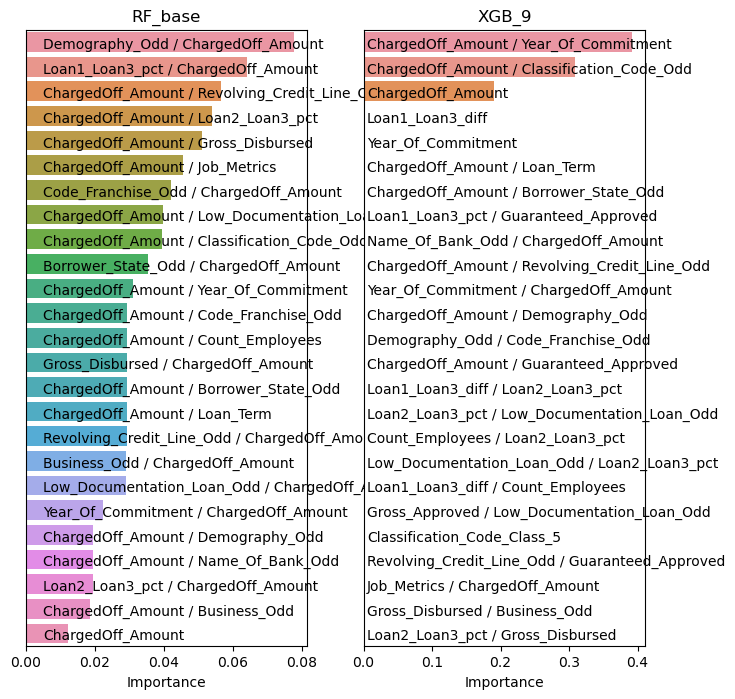

CPU times: total: 2h 58min 30s
Wall time: 23min 13s


In [201]:
%%time
data_name = 'Test4.4 Add divide'

X_train, X_test, y_train, y_test, df_submit = data_transform_pipeline(
    sample_test = -1,
    # replace categorical with odd
    Low_Documentation_Loan_Odd  = False, 
    Low_Documentation_Loan_drop = False,
    Revolving_Credit_Line_Odd   = False,
    Revolving_Credit_Line_drop  = False,
    Business_Odd          = False,
    Business_drop         = False,
    Demography_Odd        = False,
    Demography_drop       = False,
    Classification_Code_Odd  = False,
    Classification_Code_drop = False,
    Code_Franchise_Odd       = False,
    Code_Franchise_drop      = False,
    Name_Of_Bank_Odd   = False,
    Borrower_State_Odd = False,

    # replace loan amount with pct/diff
    Loan1_Loan3_pct  = True,
    Loan1_Loan3_diff = True,
    Loan2_Loan3_pct  = True,
    Loan2_Loan3_diff = True,
    Loan1_drop = False,
    Loan2_drop = False,
    Loan3_drop = False,

    # add engineered features
    add_sum      = False,
    add_multiply = False,
    add_subtract = False,
    add_divide   = True,

    # processing
    drop_cols     = [],
    drop_first    = False,
    std_scale     = False,
    to_array      = False,
    test_size     = 0.2)


models_list = [
    (RF_base,'RF_base'),
    # (ADA_base,'ADA_base'),
    # (GB_base,'GB_base'),
    # (XGB_base,'XGB_base'),
    (XGB_9,'XGB_9')
]

for model, model_name in models_list:
    print('Model:',model_name)
    model_performance(model, model_name, data_name, X_train, X_test, y_train, y_test, cv=5)

feature_imp(models_list)

In [202]:
df_metrics

model                  data    time  train_acc  \
0    RF_base          Test4.0 Base   68.29    99.9988   
1   ADA_base          Test4.0 Base   42.29    99.4083   
2    GB_base          Test4.0 Base  154.83    99.5012   
3   XGB_base          Test4.0 Base   24.56    99.6131   
4      XGB_9          Test4.0 Base   73.88    99.8417   
5    RF_base       Test4.1 Add sum  337.33    99.9988   
6   ADA_base       Test4.1 Add sum  446.98    99.4310   
7      XGB_9       Test4.1 Add sum  505.28    99.9857   
8    RF_base  Test4.2 Add multiply  320.72    99.9988   
9   ADA_base  Test4.2 Add multiply  419.17    99.4024   
10     XGB_9  Test4.2 Add multiply  491.46   100.0000   
11   RF_base       Test4.1 Add sum  330.08    99.9988   
12   RF_base       Test4.1 Add sum  330.04    99.9988   
13   RF_base  Test4.3 Add subtract   513.1    99.9988   
14  ADA_base  Test4.3 Add subtract   838.9    99.4417   
15     XGB_9  Test4.3 Add subtract  907.89    99.9869   
16   RF_base    Test4.4 Add divide   487.4    99.9988   
17     XGB_9    Test4.4 Add divide  896.22    99.9988   

                                train_PRF1       test_acc  \
0      1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4381   
1   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0        99.3857   
2   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0        99.4286   
3    0.99 - 1.0 - 0.99  |  1.0 - 1.0 - 1.0        99.4190   
4     0.99 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4429   
5      1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4524   
6   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0        99.4286   
7      1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4524   
8      1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4333   
9   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0        99.3857   
10     1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4238   
11     1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4524   
12     1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4524   
13     1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4476   
14  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0        99.4571   
15     1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4238   
16     1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4429   
17     1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4381   

                                 test_PRF1        cv_acc         cv_range  \
0   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4552   0.9956 - 0.994   
1   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4000  0.9949 - 0.9933   
2   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4400  0.9953 - 0.9937   
3   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4476  0.9955 - 0.9939   
4   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4571   0.9956 - 0.994   
5   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4543  0.9956 - 0.9939   
6   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4314  0.9953 - 0.9937   
7   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4562  0.9956 - 0.9939   
8   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4514  0.9956 - 0.9939   
9   0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4000  0.9949 - 0.9933   
10  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4476  0.9956 - 0.9939   
11  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4543  0.9956 - 0.9939   
12  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4543  0.9956 - 0.9939   
13  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4600   0.9956 - 0.994   
14  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4467  0.9952 - 0.9938   
15  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4495  0.9957 - 0.9939   
16  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4543   0.9956 - 0.994   
17  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4581   0.9957 - 0.994   

       pred_ratio  
0   71.86 / 28.14  
1   71.92 / 28.08  
2   71.87 / 28.13  
3   71.86 / 28.14  
4   71.86 / 28.14  
5   71.86 / 28.14  
6   71.88 / 28.12  
7   71.86 / 28.14  
8   71.86 / 28.14  
9   71.92 / 28.08  
10  71.87 / 28.13  
11  71.86 / 28.14  
12  71.86 / 28.14  
13  71.86 / 28.14  

In [203]:
# RF
make_submission_tree(models_list[:1], data_name, retrain = True)

71.72 / 28.28
Exported Test4.4 Add divide_RF_base.csv


In [204]:
# xgb
make_submission(models_list[-1:], data_name, retrain = True, early_stopping=30)

[0]	validation_0-aucpr:0.99695
[1]	validation_0-aucpr:0.99694
[2]	validation_0-aucpr:0.99709
[3]	validation_0-aucpr:0.99715
[4]	validation_0-aucpr:0.99718
[5]	validation_0-aucpr:0.99725
[6]	validation_0-aucpr:0.99726
[7]	validation_0-aucpr:0.99745
[8]	validation_0-aucpr:0.99761
[9]	validation_0-aucpr:0.99761
[10]	validation_0-aucpr:0.99767
[11]	validation_0-aucpr:0.99770
[12]	validation_0-aucpr:0.99775
[13]	validation_0-aucpr:0.99778
[14]	validation_0-aucpr:0.99776
[15]	validation_0-aucpr:0.99776
[16]	validation_0-aucpr:0.99779
[17]	validation_0-aucpr:0.99785
[18]	validation_0-aucpr:0.99815
[19]	validation_0-aucpr:0.99819
[20]	validation_0-aucpr:0.99845
[21]	validation_0-aucpr:0.99855
[22]	validation_0-aucpr:0.99870
[23]	validation_0-aucpr:0.99872
[24]	validation_0-aucpr:0.99878
[25]	validation_0-aucpr:0.99903
[26]	validation_0-aucpr:0.99904
[27]	validation_0-aucpr:0.99904
[28]	validation_0-aucpr:0.99911
[29]	validation_0-aucpr:0.99938
[30]	validation_0-aucpr:0.99939
[31]	validation_0-

In [222]:
# # failed experiment
# test_41_hardcode = pd.read_csv('SUBMISSIONS\\Test4.1 Add sum_RF_base.csv')
# test_41_hardcode['Default'][df_submit['Loan_Term']>600] = 1
# test_41_hardcode.to_csv('test_41_hardcode.csv', index=None)

### 4.5 Add sum + RF200
Base 4.1 best RF, expand to 200

=> **new best 0.9950222**

In [49]:
RF_200 = RandomForestClassifier(n_estimators = 200, random_state = 14)

Model: RF_200
Training:  RF_200 / Test4.5 Add sum RF200
Finished in 656.49


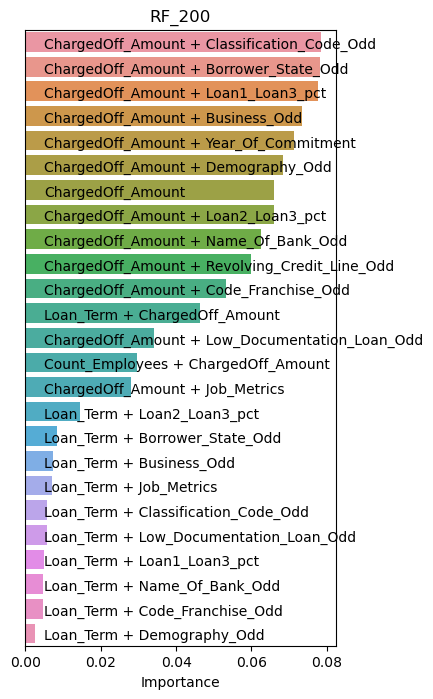

CPU times: total: 11min
Wall time: 11min


In [50]:
%%time
data_name = 'Test4.5 Add sum RF200'

X_train, X_test, y_train, y_test, df_submit = data_transform_pipeline(
    sample_test = -1,
    # replace categorical with odd
    Low_Documentation_Loan_Odd  = False, 
    Low_Documentation_Loan_drop = False,
    Revolving_Credit_Line_Odd   = False,
    Revolving_Credit_Line_drop  = False,
    Business_Odd          = False,
    Business_drop         = False,
    Demography_Odd        = False,
    Demography_drop       = False,
    Classification_Code_Odd  = False,
    Classification_Code_drop = False,
    Code_Franchise_Odd       = False,
    Code_Franchise_drop      = False,
    Name_Of_Bank_Odd   = False,
    Borrower_State_Odd = False,

    # replace loan amount with pct/diff
    Loan1_Loan3_pct  = True,
    Loan1_Loan3_diff = True,
    Loan2_Loan3_pct  = True,
    Loan2_Loan3_diff = True,
    Loan1_drop = False,
    Loan2_drop = False,
    Loan3_drop = False,

    # add engineered features
    add_sum      = True,
    add_multiply = False,
    add_subtract = False,
    add_divide   = False,

    # processing
    drop_cols     = [],
    drop_first    = False,
    std_scale     = False,
    to_array      = False,
    test_size     = 0.2)


models_list = [
    # (RF_base,'RF_base'),
    (RF_200,'RF_200'),
    # (ADA_base,'ADA_base'),
    # (GB_base,'GB_base'),
    # (XGB_base,'XGB_base'),
    # (XGB_9,'XGB_9')
]

for model, model_name in models_list:
    print('Model:',model_name)
    model_performance(model, model_name, data_name, X_train, X_test, y_train, y_test, cv=5)

feature_imp(models_list)

In [51]:
df_metrics

model                   data    time  train_acc  \
0   RF_base               Test2.4_   69.92    99.9988   
1  ADA_base               Test2.4_   44.25    99.4083   
2   GB_base               Test2.4_  158.23    99.5012   
3  XGB_base               Test2.4_    25.9    99.6131   
4     XGB_9               Test2.4_   77.31    99.8655   
5   RF_base        Test4.1 Add sum  338.46    99.9988   
6    RF_200  Test4.5 Add sum RF200  656.49   100.0000   

                               train_PRF1       test_acc  \
0     1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4381   
1  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0        99.3857   
2  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0        99.4381   
3   0.99 - 1.0 - 0.99  |  1.0 - 1.0 - 1.0        99.4190   
4     1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4476   
5     1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4381   
6     1.0 - 1.0 - 1.0  |  1.0 - 1.0 - 1.0        99.4476   

                                test_PRF1        cv_acc         cv_range  \
0  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4533  0.9955 - 0.9939   
1  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4000  0.9949 - 0.9933   
2  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4381  0.9953 - 0.9937   
3  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4476  0.9955 - 0.9939   
4  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4571   0.9956 - 0.994   
5  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4581   0.9957 - 0.994   
6  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4600   0.9957 - 0.994   

      pred_ratio  
0  71.86 / 28.14  
1  71.92 / 28.08  
2  71.87 / 28.13  
3  71.86 / 28.14  
4  71.86 / 28.14  
5  71.86 / 28.14  
6  71.86 / 28.14

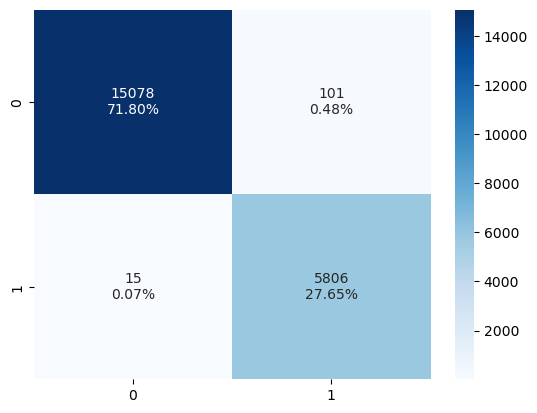

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     15179
           1       0.98      1.00      0.99      5821

    accuracy                           0.99     21000
   macro avg       0.99      1.00      0.99     21000
weighted avg       0.99      0.99      0.99     21000



In [52]:
yhat_test = RF_200.predict(X_test)
make_CF(y_test, yhat_test)

In [53]:
# RF
make_submission_tree(models_list[:1], data_name, retrain = True)

OSError: Cannot save file into a non-existent directory: 'SUBMISSIONS'

### 4.6 Add sum + RF200 + concat submission
Base 4.5, concat submission

In [223]:
RF_200 = RandomForestClassifier(n_estimators = 200, random_state = 14)

Model: RF_200
Training:  RF_200 / Test4.5 Add sum RF200
Finished in 644.68


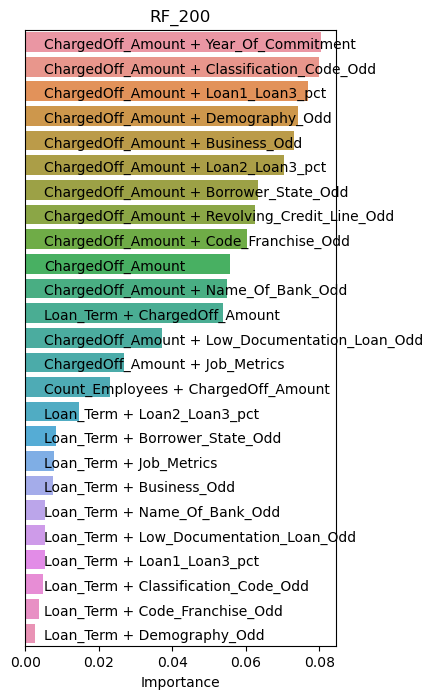

CPU times: total: 10min 48s
Wall time: 10min 48s


In [224]:
%%time
data_name = 'Test4.5 Add sum RF200'

X_train, X_test, y_train, y_test, df_submit = data_transform_pipeline(
    sample_test = -1,
    # replace categorical with odd
    Low_Documentation_Loan_Odd  = False, 
    Low_Documentation_Loan_drop = False,
    Revolving_Credit_Line_Odd   = False,
    Revolving_Credit_Line_drop  = False,
    Business_Odd          = False,
    Business_drop         = False,
    Demography_Odd        = False,
    Demography_drop       = False,
    Classification_Code_Odd  = False,
    Classification_Code_drop = False,
    Code_Franchise_Odd       = False,
    Code_Franchise_drop      = False,
    Name_Of_Bank_Odd   = False,
    Borrower_State_Odd = False,

    # replace loan amount with pct/diff
    Loan1_Loan3_pct  = True,
    Loan1_Loan3_diff = True,
    Loan2_Loan3_pct  = True,
    Loan2_Loan3_diff = True,
    Loan1_drop = False,
    Loan2_drop = False,
    Loan3_drop = False,

    # add engineered features
    add_sum      = True,
    add_multiply = False,
    add_subtract = False,
    add_divide   = False,

    # processing
    drop_cols     = [],
    drop_first    = False,
    std_scale     = False,
    to_array      = False,
    test_size     = 0.2)


models_list = [
    # (RF_base,'RF_base'),
    (RF_200,'RF_200'),
    # (ADA_base,'ADA_base'),
    # (GB_base,'GB_base'),
    # (XGB_base,'XGB_base'),
    # (XGB_9,'XGB_9')
]

for model, model_name in models_list:
    print('Model:',model_name)
    model_performance(model, model_name, data_name, X_train, X_test, y_train, y_test, cv=5)

feature_imp(models_list)

In [232]:
# RF
make_submission_tree(models_list[:1], 'Test4.6.CONCAT', retrain = True, concat='SUBMISSIONS\\Test4.5 Add sum RF200_RF_200.csv')

71.71 / 28.29
Exported Test4.6.CONCAT_RF_200.csv


In [234]:
# XGB_9 0.9950222
make_submission([(XGB_9,'XGB_9')], 'Test4.6.CONCAT', retrain = True, concat='SUBMISSIONS\\Test4.5 Add sum RF200_RF_200.csv')

[0]	validation_0-aucpr:0.99671
[1]	validation_0-aucpr:0.99688
[2]	validation_0-aucpr:0.99714
[3]	validation_0-aucpr:0.99742
[4]	validation_0-aucpr:0.99740
[5]	validation_0-aucpr:0.99755
[6]	validation_0-aucpr:0.99768
[7]	validation_0-aucpr:0.99770
[8]	validation_0-aucpr:0.99781
[9]	validation_0-aucpr:0.99782
[10]	validation_0-aucpr:0.99787
[11]	validation_0-aucpr:0.99801
[12]	validation_0-aucpr:0.99804
[13]	validation_0-aucpr:0.99805
[14]	validation_0-aucpr:0.99824
[15]	validation_0-aucpr:0.99854
[16]	validation_0-aucpr:0.99858
[17]	validation_0-aucpr:0.99863
[18]	validation_0-aucpr:0.99864
[19]	validation_0-aucpr:0.99870
[20]	validation_0-aucpr:0.99874
[21]	validation_0-aucpr:0.99879
[22]	validation_0-aucpr:0.99883
[23]	validation_0-aucpr:0.99888
[24]	validation_0-aucpr:0.99892
[25]	validation_0-aucpr:0.99891
[26]	validation_0-aucpr:0.99898
[27]	validation_0-aucpr:0.99902
[28]	validation_0-aucpr:0.99906
[29]	validation_0-aucpr:0.99909
[30]	validation_0-aucpr:0.99913
[31]	validation_0-

### 4.7 Add ALL + RF500
not working

In [238]:
RF_500 = RandomForestClassifier(n_estimators = 500, random_state = 14)

In [239]:
%%time
data_name = 'Test4.7 Add ALL RF_500'

X_train, X_test, y_train, y_test, df_submit = data_transform_pipeline(
    sample_test = -1,
    # replace categorical with odd
    Low_Documentation_Loan_Odd  = False, 
    Low_Documentation_Loan_drop = False,
    Revolving_Credit_Line_Odd   = False,
    Revolving_Credit_Line_drop  = False,
    Business_Odd          = False,
    Business_drop         = False,
    Demography_Odd        = False,
    Demography_drop       = False,
    Classification_Code_Odd  = False,
    Classification_Code_drop = False,
    Code_Franchise_Odd       = False,
    Code_Franchise_drop      = False,
    Name_Of_Bank_Odd   = False,
    Borrower_State_Odd = False,

    # replace loan amount with pct/diff
    Loan1_Loan3_pct  = True,
    Loan1_Loan3_diff = True,
    Loan2_Loan3_pct  = True,
    Loan2_Loan3_diff = True,
    Loan1_drop = False,
    Loan2_drop = False,
    Loan3_drop = False,

    # add engineered features
    add_sum      = True,
    add_multiply = True,
    add_subtract = True,
    add_divide   = True,

    # processing
    drop_cols     = [],
    drop_first    = False,
    std_scale     = False,
    to_array      = False,
    test_size     = 0.2)


models_list = [
    # (RF_base,'RF_base'),
    (RF_500,'RF_500'),
    # (ADA_base,'ADA_base'),
    # (GB_base,'GB_base'),
    # (XGB_base,'XGB_base'),
    # (XGB_9,'XGB_9')
]

# for model, model_name in models_list:
#     print('Model:',model_name)
#     model_performance(model, model_name, data_name, X_train, X_test, y_train, y_test, cv=5)

# feature_imp(models_list)

CPU times: total: 24.4 s
Wall time: 24.4 s


In [240]:
X_train.shape

(84000, 1058)

In [241]:
# RF
make_submission_tree(models_list[:1], data_name, retrain = True)

71.72 / 28.28
Exported Test4.7 Add ALL RF_500_RF_500.csv


In [242]:
# XGB_9
make_submission([(XGB_9,'XGB_9')], data_name, retrain = True, concat='SUBMISSIONS\\Test4.5 Add sum RF200_RF_200.csv')

[0]	validation_0-aucpr:0.99552
[1]	validation_0-aucpr:0.99640
[2]	validation_0-aucpr:0.99683
[3]	validation_0-aucpr:0.99702
[4]	validation_0-aucpr:0.99706
[5]	validation_0-aucpr:0.99723
[6]	validation_0-aucpr:0.99723
[7]	validation_0-aucpr:0.99736
[8]	validation_0-aucpr:0.99736
[9]	validation_0-aucpr:0.99737
[10]	validation_0-aucpr:0.99743
[11]	validation_0-aucpr:0.99744
[12]	validation_0-aucpr:0.99744
[13]	validation_0-aucpr:0.99752
[14]	validation_0-aucpr:0.99754
[15]	validation_0-aucpr:0.99752
[16]	validation_0-aucpr:0.99760
[17]	validation_0-aucpr:0.99764
[18]	validation_0-aucpr:0.99767
[19]	validation_0-aucpr:0.99784
[20]	validation_0-aucpr:0.99787
[21]	validation_0-aucpr:0.99789
[22]	validation_0-aucpr:0.99790
[23]	validation_0-aucpr:0.99804
[24]	validation_0-aucpr:0.99809
[25]	validation_0-aucpr:0.99820
[26]	validation_0-aucpr:0.99832
[27]	validation_0-aucpr:0.99838
[28]	validation_0-aucpr:0.99842
[29]	validation_0-aucpr:0.99846
[30]	validation_0-aucpr:0.99844
[31]	validation_0-

### 4.8 Add sum + RF200

Add selected cols from other dfs

In [33]:
RF_200 = RandomForestClassifier(n_estimators = 200, random_state = 14)

In [40]:
%%time
# 2min 41s
data_name = 'Test4.8 Add selected cols'

# df_divide_cols = ['Demography_Odd / ChargedOff_Amount', 
# 'Loan1_Loan3_pct / ChargedOff_Amount', 
# 'ChargedOff_Amount / Revolving_Credit_Line_Odd',
# 'ChargedOff_Amount / Loan2_Loan3_pct']

X_train, X_test, y_train, y_test, df_submit = data_transform_pipeline(
    sample_test = -1,
    # replace categorical with odd
    Low_Documentation_Loan_Odd  = False, 
    Low_Documentation_Loan_drop = False,
    Revolving_Credit_Line_Odd   = False,
    Revolving_Credit_Line_drop  = False,
    Business_Odd          = False,
    Business_drop         = False,
    Demography_Odd        = False,
    Demography_drop       = False,
    Classification_Code_Odd  = False,
    Classification_Code_drop = False,
    Code_Franchise_Odd       = False,
    Code_Franchise_drop      = False,
    Name_Of_Bank_Odd   = False,
    Borrower_State_Odd = False,

    # replace loan amount with pct/diff
    Loan1_Loan3_pct  = True,
    Loan1_Loan3_diff = True,
    Loan2_Loan3_pct  = True,
    Loan2_Loan3_diff = True,
    Loan1_drop = False,
    Loan2_drop = False,
    Loan3_drop = False,

    # add engineered features
    add_sum      = True,
    add_multiply = False,
    add_subtract = False,
    add_divide   = df_divide_cols,

    # processing
    drop_cols     = [],
    drop_first    = False,
    std_scale     = False,
    to_array      = False,
    test_size     = 0.2)


models_list = [
    # (RF_base,'RF_base'),
    (RF_200,'RF_200'),
    # (ADA_base,'ADA_base'),
    # (GB_base,'GB_base'),
    # (XGB_base,'XGB_base'),
    # (XGB_9,'XGB_9')
]

# for model, model_name in models_list:
#     print('Model:',model_name)
#     model_performance(model, model_name, data_name, X_train, X_test, y_train, y_test, cv=5)

# feature_imp(models_list)

# RF
make_submission_tree(models_list, data_name, retrain = True)

71.72 / 28.28
Exported Test4.8 Add selected cols_RF_200.csv
CPU times: total: 2min 41s
Wall time: 2min 41s


### Test 4.9 DN

In [59]:
%%time
data_name = 'Test4.9 DL1 epoch20es5'
epochs = 20

# df_divide_cols = ['Demography_Odd / ChargedOff_Amount', 
# 'Loan1_Loan3_pct / ChargedOff_Amount', 
# 'ChargedOff_Amount / Revolving_Credit_Line_Odd',
# 'ChargedOff_Amount / Loan2_Loan3_pct']

X_train, X_test, y_train, y_test, df_submit = data_transform_pipeline(
    sample_test = -1,
    # replace categorical with odd
    Low_Documentation_Loan_Odd  = False, 
    Low_Documentation_Loan_drop = False,
    Revolving_Credit_Line_Odd   = False,
    Revolving_Credit_Line_drop  = False,
    Business_Odd          = False,
    Business_drop         = False,
    Demography_Odd        = False,
    Demography_drop       = False,
    Classification_Code_Odd  = False,
    Classification_Code_drop = False,
    Code_Franchise_Odd       = False,
    Code_Franchise_drop      = False,
    Name_Of_Bank_Odd   = False,
    Borrower_State_Odd = False,

    # replace loan amount with pct/diff
    Loan1_Loan3_pct  = True,
    Loan1_Loan3_diff = True,
    Loan2_Loan3_pct  = True,
    Loan2_Loan3_diff = True,
    Loan1_drop = False,
    Loan2_drop = False,
    Loan3_drop = False,

    # add engineered features
    add_sum      = True,
    add_multiply = False,
    add_subtract = False,
    add_divide   = df_divide_cols,

    # processing
    drop_cols     = [],
    drop_first    = False,
    std_scale     = True,
    to_array      = True,
    test_size     = 0.2)

backend.clear_session()
optimizer = tf.keras.optimizers.Adam(0.001)
DL_1 = Sequential()
DL_1.add(Dense(256, activation='relu', input_dim = X_train.shape[1]))
DL_1.add(Dropout(0.2))
DL_1.add(Dense(192, activation='relu'))
DL_1.add(Dropout(0.2))
DL_1.add(Dense(128, activation='relu'))
DL_1.add(Dropout(0.2))
DL_1.add(Dense(64, activation='relu'))
DL_1.add(Dropout(0.1))
DL_1.add(Dense(1, activation='sigmoid'))
DL_1.compile(loss = 'binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True  
)

# models
models_list=[
    (DL_1,'DL_1'),
]


for model, model_name in models_list:
    print('Model:',model_name)
    make_submission_DL(models_list, data_name, retrain=True, concat='SUBMISSIONS\Test4.5 Add sum RF200_RF_200.csv',epochs=epochs, callback = callback)

Model: DL_1
Epoch 1/20
2363/2363 [==============================] - 6s 2ms/step - loss: 0.0439 - accuracy: 0.9916 - val_loss: 0.0271 - val_accuracy: 0.9950
Epoch 2/20
2363/2363 [==============================] - 6s 2ms/step - loss: 0.0349 - accuracy: 0.9936 - val_loss: 0.0243 - val_accuracy: 0.9950
Epoch 3/20
2363/2363 [==============================] - 6s 2ms/step - loss: 0.0342 - accuracy: 0.9940 - val_loss: 0.0281 - val_accuracy: 0.9951
Epoch 4/20
2363/2363 [==============================] - 5s 2ms/step - loss: 0.0349 - accuracy: 0.9938 - val_loss: 0.0244 - val_accuracy: 0.9952
Epoch 5/20
2363/2363 [==============================] - 6s 2ms/step - loss: 0.0328 - accuracy: 0.9940 - val_loss: 0.0297 - val_accuracy: 0.9951
Epoch 6/20
2363/2363 [==============================] - 6s 2ms/step - loss: 0.0326 - accuracy: 0.9939 - val_loss: 0.0282 - val_accuracy: 0.9951
Epoch 7/20
2363/2363 [==============================] - 6s 2ms/step - loss: 0.0317 - accuracy: 0.9942 - val_loss: 0.0284 - v

### 4.10 Add sum + RF200

Add selected cols from other dfs

In [33]:
RF_200 = RandomForestClassifier(n_estimators = 200, random_state = 14)

Model: RF_200
Training:  RF_200 / Test4.10
Finished in 60.32


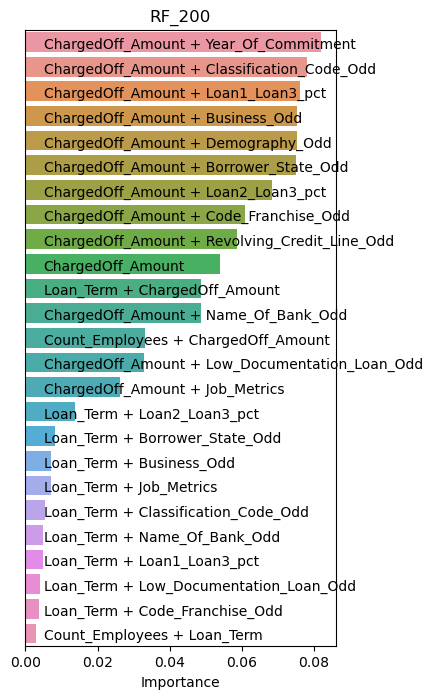

CPU times: total: 1min 4s
Wall time: 1min 4s


In [61]:
%%time
# 2min 41s
data_name = 'Test4.10'

# df_divide_cols = ['Demography_Odd / ChargedOff_Amount', 
# 'Loan1_Loan3_pct / ChargedOff_Amount', 
# 'ChargedOff_Amount / Revolving_Credit_Line_Odd',
# 'ChargedOff_Amount / Loan2_Loan3_pct']

X_train, X_test, y_train, y_test, df_submit = data_transform_pipeline(
    sample_test = -1,
    # replace categorical with odd
    Low_Documentation_Loan_Odd  = False, 
    Low_Documentation_Loan_drop = False,
    Revolving_Credit_Line_Odd   = False,
    Revolving_Credit_Line_drop  = False,
    Business_Odd          = False,
    Business_drop         = False,
    Demography_Odd        = False,
    Demography_drop       = False,
    Classification_Code_Odd  = False,
    Classification_Code_drop = False,
    Code_Franchise_Odd       = False,
    Code_Franchise_drop      = False,
    Name_Of_Bank_Odd   = False,
    Borrower_State_Odd = False,

    # replace loan amount with pct/diff
    Loan1_Loan3_pct  = True,
    Loan1_Loan3_diff = True,
    Loan2_Loan3_pct  = True,
    Loan2_Loan3_diff = True,
    Loan1_drop = False,
    Loan2_drop = False,
    Loan3_drop = False,

    # add engineered features
    add_sum      = True,
    add_multiply = False,
    add_subtract = False,
    add_divide   = False,

    # processing
    drop_cols     = [],
    drop_first    = False,
    std_scale     = False,
    to_array      = False,
    test_size     = 0.2)


models_list = [
    # (RF_base,'RF_base'),
    (RF_200,'RF_200'),
    # (ADA_base,'ADA_base'),
    # (GB_base,'GB_base'),
    # (XGB_base,'XGB_base'),
    # (XGB_9,'XGB_9')
]

for model, model_name in models_list:
    print('Model:',model_name)
    model_performance(model, model_name, data_name, X_train, X_test, y_train, y_test, cv=0)

feature_imp(models_list)

# RF
# make_submission_tree(models_list, data_name, retrain = True)

### 

### 4.11 Add sum + RF201, rf155, rf175, rf225, rf255


In [135]:
RF_201 = RandomForestClassifier(n_estimators = 201, random_state = 14)

In [138]:
%%time
# 2min 41s
data_name = 'Test4.11'

X_train, X_test, y_train, y_test, df_submit = data_transform_pipeline(
    sample_test = -1,
    # replace categorical with odd
    Low_Documentation_Loan_Odd  = False, 
    Low_Documentation_Loan_drop = False,
    Revolving_Credit_Line_Odd   = False,
    Revolving_Credit_Line_drop  = False,
    Business_Odd          = False,
    Business_drop         = False,
    Demography_Odd        = False,
    Demography_drop       = False,
    Classification_Code_Odd  = False,
    Classification_Code_drop = False,
    Code_Franchise_Odd       = False,
    Code_Franchise_drop      = False,
    Name_Of_Bank_Odd   = False,
    Borrower_State_Odd = False,

    # replace loan amount with pct/diff
    Loan1_Loan3_pct  = True,
    Loan1_Loan3_diff = True,
    Loan2_Loan3_pct  = True,
    Loan2_Loan3_diff = True,
    Loan1_drop = False,
    Loan2_drop = False,
    Loan3_drop = False,

    # add engineered features
    add_sum      = True,
    add_multiply = False,
    add_subtract = False,
    add_divide   = False,

    # processing
    drop_cols     = [],
    drop_first    = False,
    std_scale     = False,
    to_array      = False,
    test_size     = 0.2)


models_list = [
    # (RF_base,'RF_base'),
    (RF_201,'RF_201'),
    # (ADA_base,'ADA_base'),
    # (GB_base,'GB_base'),
    # (XGB_base,'XGB_base'),
    # (XGB_9,'XGB_9')
]

# for model, model_name in models_list:
#     print('Model:',model_name)
#     model_performance(model, model_name, data_name, X_train, X_test, y_train, y_test, cv=0)

# feature_imp(models_list)

# RF
make_submission_tree(models_list, data_name, retrain = True)

0: 32270 / 1: 12730
Exported Test4.11_RF_201.csv
CPU times: total: 1min 21s
Wall time: 1min 21s


In [137]:
RF_255 = RandomForestClassifier(n_estimators = 255, random_state = 14)

In [139]:
%%time
# 2min 41s
data_name = 'Test4.11'

X_train, X_test, y_train, y_test, df_submit = data_transform_pipeline(
    sample_test = -1,
    # replace categorical with odd
    Low_Documentation_Loan_Odd  = False, 
    Low_Documentation_Loan_drop = False,
    Revolving_Credit_Line_Odd   = False,
    Revolving_Credit_Line_drop  = False,
    Business_Odd          = False,
    Business_drop         = False,
    Demography_Odd        = False,
    Demography_drop       = False,
    Classification_Code_Odd  = False,
    Classification_Code_drop = False,
    Code_Franchise_Odd       = False,
    Code_Franchise_drop      = False,
    Name_Of_Bank_Odd   = False,
    Borrower_State_Odd = False,

    # replace loan amount with pct/diff
    Loan1_Loan3_pct  = True,
    Loan1_Loan3_diff = True,
    Loan2_Loan3_pct  = True,
    Loan2_Loan3_diff = True,
    Loan1_drop = False,
    Loan2_drop = False,
    Loan3_drop = False,

    # add engineered features
    add_sum      = True,
    add_multiply = False,
    add_subtract = False,
    add_divide   = False,

    # processing
    drop_cols     = [],
    drop_first    = False,
    std_scale     = False,
    to_array      = False,
    test_size     = 0.2)


models_list = [
    # (RF_base,'RF_base'),
    (RF_255,'RF_255'),
    # (ADA_base,'ADA_base'),
    # (GB_base,'GB_base'),
    # (XGB_base,'XGB_base'),
    # (XGB_9,'XGB_9')
]

# for model, model_name in models_list:
#     print('Model:',model_name)
#     model_performance(model, model_name, data_name, X_train, X_test, y_train, y_test, cv=0)

# feature_imp(models_list)

# RF
make_submission_tree(models_list, data_name, retrain = True)

0: 32272 / 1: 12728
Exported Test4.11_RF_255.csv
CPU times: total: 1min 43s
Wall time: 1min 43s


In [140]:
RF_155 = RandomForestClassifier(n_estimators = 155, random_state = 14)

In [141]:
models_list = [
    # (RF_base,'RF_base'),
    (RF_155,'RF_155'),
    # (ADA_base,'ADA_base'),
    # (GB_base,'GB_base'),
    # (XGB_base,'XGB_base'),
    # (XGB_9,'XGB_9')
]

# for model, model_name in models_list:
#     print('Model:',model_name)
#     model_performance(model, model_name, data_name, X_train, X_test, y_train, y_test, cv=0)

# feature_imp(models_list)

# RF
make_submission_tree(models_list, data_name, retrain = True)

0: 32270 / 1: 12730
Exported Test4.11_RF_155.csv


In [151]:
# debug rf rf155 &  rf200
df_debug = pd.read_csv('REP_RF200\Test4.5 Add sum RF200_RF_200.csv')
df_155 = pd.read_csv('SUBMISSIONS\Test4.11_RF_155.csv', usecols = ['Default'])
df_255 = pd.read_csv('SUBMISSIONS\Test4.11_RF_155.csv', usecols = ['Default'])
df_debug['Default'][df_debug['Default']!=df_155['Default']]

1961     0
44891    0
Name: Default, dtype: int64

In [149]:
df_debug['Default'].value_counts(),df_155['Default'].value_counts()

(0    32272
 1    12728
 Name: Default, dtype: int64,
 0    32270
 1    12730
 Name: Default, dtype: int64)

In [155]:
df_debug['Default'].iloc[1961] = 1
# df_debug['Default'].iloc[44891]

df_debug.to_csv('SUBMISSIONS\Test4.11_1961.csv', index=False)

In [156]:
RF_175 = RandomForestClassifier(n_estimators = 175, random_state = 14)
make_submission_tree([(RF_175,'RF_175')], data_name, retrain = True)

0: 32270 / 1: 12730
Exported Test4.11_RF_175.csv


In [161]:
df_175 = pd.read_csv('SUBMISSIONS\Test4.11_RF_175.csv', usecols = ['Default'])

In [162]:
(df_155['Default']==df_175['Default']).sum()

45000

In [160]:
RF_225 = RandomForestClassifier(n_estimators = 225, random_state = 14)
make_submission_tree([(RF_225,'RF_225')], data_name, retrain = True)

0: 32270 / 1: 12730
Exported Test4.11_RF_225.csv


In [163]:
df_225 = pd.read_csv('SUBMISSIONS\Test4.11_RF_225.csv', usecols = ['Default'])
(df_155['Default']==df_225['Default']).sum()

45000

In [164]:
df_100 = pd.read_csv('SUBMISSIONS\Test4.1 Add sum_RF_base.csv', usecols = ['Default'])
(df_155['Default']==df_100['Default']).sum()

44998

In [166]:
df_100[df_155['Default']!=df_100['Default']]

Default
1961         0
33637        0

In [167]:
RF_299 = RandomForestClassifier(n_estimators = 299, random_state = 14)
make_submission_tree([(RF_299,'RF_299')], data_name, retrain = True)
df_299 = pd.read_csv('SUBMISSIONS\Test4.11_RF_299.csv', usecols = ['Default'])
(df_155['Default']==df_299['Default']).sum()

0: 32272 / 1: 12728
Exported Test4.11_RF_299.csv


44998

In [169]:
df_155[df_155['Default']!=df_299['Default']]

Default
33637        1
42647        1

### 

## 5. Hypertuning


### 5.1 

In [17]:
%%time
# 1h 43min 26s
data_name = 'Test5.1 Tune'
n_iter = 100
n_estimators = 150




X_train, X_test, y_train, y_test, df_submit = data_transform_pipeline(
    sample_test = -1,
    # replace categorical with odd
    Low_Documentation_Loan_Odd  = False, 
    Low_Documentation_Loan_drop = False,
    Revolving_Credit_Line_Odd   = False,
    Revolving_Credit_Line_drop  = False,
    Business_Odd          = False,
    Business_drop         = False,
    Demography_Odd        = False,
    Demography_drop       = False,
    Classification_Code_Odd  = False,
    Classification_Code_drop = False,
    Code_Franchise_Odd       = False,
    Code_Franchise_drop      = False,
    Name_Of_Bank_Odd   = False,
    Borrower_State_Odd = False,

    # replace loan amount with pct/diff
    Loan1_Loan3_pct  = True,
    Loan1_Loan3_diff = True,
    Loan2_Loan3_pct  = True,
    Loan2_Loan3_diff = True,
    Loan1_drop = False,
    Loan2_drop = False,
    Loan3_drop = False,

    # add engineered features
    add_sum      = True,
    add_multiply = False,
    add_subtract = False,
    add_divide   = False,

    # processing
    drop_cols     = [],
    drop_first    = False,
    std_scale     = False,
    to_array      = False,
    test_size     = 0.2)


random_grid = {'max_depth': np.arange(3,26,2),
               'learning_rate': [0.5, 0,25, 0.1, 0.05, 0.01],
               'gamma': [0.0, 0.1, 0.2, 0.25, 0.5, 1.0],
               'reg_lambda': [0.0, 0,1, 1.0, 10.0, 20],
               }
start_tuning = time.time()
optimal_params = RandomizedSearchCV(estimator = xgb.XGBClassifier(n_estimators = n_estimators, objective='binary:logistic', seed=14),
                                    param_distributions = random_grid,
                                    n_iter = n_iter, 
                                    cv = 5, 
                                    verbose=3, 
                                    random_state=42, 
                                    n_jobs = 10,
                                    scoring = 'roc_auc')

optimal_params.fit(X_train, y_train)
print(optimal_params.best_params_)

XGB_tune = optimal_params.best_estimator_
XGB_tune.fit(X_train, y_train, verbose = 2, early_stopping_rounds=40, eval_metric='aucpr', eval_set=[(X_test, y_test)],)

models_list=[(XGB_tune,'XGB_tune')]

for model, model_name in models_list:
    print('Model:',model_name)
    model_performance(model, model_name, data_name, X_train, X_test, y_train, y_test, cv=5, fit=False, start_tuning = start_tuning)    

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[16:45:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'reg_lambda': 1, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1}
[0]	validation_0-aucpr:0.99170
[2]	validation_0-aucpr:0.99306
[4]	validation_0-aucpr:0.99318
[6]	validation_0-aucpr:0.99319
[8]	validation_0-aucpr:0.99409
[10]	validation_0-aucpr:0.99409
[12]	validation_0-aucpr:0.99410
[14]	validation_0-aucpr:0.99408
[16]	validation_0-aucpr:0.99408
[18]	validation_0-aucpr:0.99435
[20]	validation_0-aucpr:0.99437
[22]	validation_0-aucpr:0.99436
[24]	validation_0-aucpr:0.99438
[26]	validation_0-aucpr:0.99438
[28]	validation_0-aucpr:0.99441
[30]	validation_0-aucpr:0.99442
[32]	validation_0-aucpr:0.99487
[

In [18]:
df_metrics

model          data      time  train_acc  \
0  XGB_tune  Test5.1 Tune   6202.37    99.4702   
1  XGB_tune  Test5.1 Tune  13893.25    99.4690   

                               train_PRF1       test_acc  \
0  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0        99.4714   
1  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0        99.4667   

                                test_PRF1        cv_acc        cv_range  \
0  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4695  0.9956 - 0.994   
1  0.98 - 1.0 - 0.99  |  1.0 - 0.99 - 1.0       99.4676  0.9956 - 0.994   

      pred_ratio  
0  71.84 / 28.16  
1  71.84 / 28.16

In [ ]:
{'reg_lambda': 10.0, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.2}

In [ ]:
{'reg_lambda': 1, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1}

In [22]:
XGB_tune3 = xgb.XGBClassifier(n_estimators = 500, reg_lambda= 1, max_depth= 3, learning_rate= 0.1, gamma= 0.1,  objective='binary:logistic', seed=14)

make_submission([(XGB_tune3,'XGB_tune3')], data_name, retrain = True)

[0]	validation_0-aucpr:0.99170
[1]	validation_0-aucpr:0.99306
[2]	validation_0-aucpr:0.99313
[3]	validation_0-aucpr:0.99319
[4]	validation_0-aucpr:0.99319
[5]	validation_0-aucpr:0.99320
[6]	validation_0-aucpr:0.99320
[7]	validation_0-aucpr:0.99321
[8]	validation_0-aucpr:0.99323
[9]	validation_0-aucpr:0.99326
[10]	validation_0-aucpr:0.99326
[11]	validation_0-aucpr:0.99326
[12]	validation_0-aucpr:0.99326
[13]	validation_0-aucpr:0.99416
[14]	validation_0-aucpr:0.99416
[15]	validation_0-aucpr:0.99416
[16]	validation_0-aucpr:0.99443
[17]	validation_0-aucpr:0.99443
[18]	validation_0-aucpr:0.99443
[19]	validation_0-aucpr:0.99454
[20]	validation_0-aucpr:0.99454
[21]	validation_0-aucpr:0.99453
[22]	validation_0-aucpr:0.99452
[23]	validation_0-aucpr:0.99452
[24]	validation_0-aucpr:0.99452
[25]	validation_0-aucpr:0.99458
[26]	validation_0-aucpr:0.99458
[27]	validation_0-aucpr:0.99458
[28]	validation_0-aucpr:0.99458
[29]	validation_0-aucpr:0.99460
[30]	validation_0-aucpr:0.99518
[31]	validation_0-